# Data Preprocessing
#### Run this script to proprocess all the data that will be coming in from one, many, or all of the following sources:
1. **MonkeyLogic:** (.bhv2 | .h5) behavior data *[500 or 1000Hz]*
  > * Photodiode data
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
2. **SpikeGLX:** (.meta & .bin) duplicates of analog data *[20000-30000Hz]*
  > * Photodiode data (split from ML)
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
3. **WhiteMatter:** (.mp4 | .avi) video files *[60-120 fps]*
***

## Find Files
`FileContainer` will hold the relevant files listed above. <br>
* Specify `ROOT_DIR` to set the directory when prompted to select the files.
* `WARNING` printed if dates and monkeys not aligned across files

In [1]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
# Custom classes
from classes.FileContainer import FileContainer
from classes.SpikeGLX import SpikeGLX
# Custom functions
from spike_glx import read_SGLX

# pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

ROOT_DIR = 'C:/Users/rober/Desktop/'
VIDEO_DIR = 'C:/Users/rober/Desktop/rhAirpuff/videos/'
file_container_obj = FileContainer(ROOT_DIR, VIDEO_DIR)

Session folder not found.
  Select .h5 behavior file (i.e. None_None_choice.h5)
  Select directory containing White Matter video files (i.e. None_None)
  Select directory containing SpikeGLX files (i.e. None_None_g0)
Behavior file selected: C:/Users/rober/Desktop/aragorn_20240205/240205_Aragorn_generalization.h5
  MonkeyLogic Date: 240205
  MonkeyLogic Monkey: aragorn
Video files directory selected: C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn
  White Matter Video Date: 240205
  White Matter Video Monkey: aragorn
SpikeGLX files directory selected: C:/Users/rober/Desktop/aragorn_20240205/aragorn_20240205_g0
  SpikeGLX Date: 240205
  SpikeGLX Monkey: aragorn



***
## Convert MonkeyLogic File to Pandas
In order to run the behavior files through the preprocessing pipeline, we'll need to convert the MonkeyLogic file (either `.bhv2` or `.h5`) into a Session object which contains the following relevant attributes:
> * `session_obj.df`: pandas DataFrame with columns:
>   * `'photodiode'`: photodiode signal
>   * `'Gen2'`: WM sync signal
>   * `'Gen3'`: WM save signal
> * `'session_obj.video_path'`: directory of WM videos
> * `session_obj.monkey`: monkey name
> * `session_obj.date`: date of session (<YYMMDD>)

In [2]:
session_obj, error_dict, behavioral_code_dict = file_container_obj.ml_to_pd()

Parsing .h5 file...
Total number of trials: 490
  Choice task detected.
Parsing session data...


  0%|          | 0/490 [00:00<?, ?it/s]

  Complete.
    Correct trials: 378
    Errored trials: 112
    Session Length:  01:23:55
Creating Session Objects...
Lick threshold: 3.77 mV
  Min Values (X,Y): (-25.346,-43.32)
  Max Values (X,Y): (132.566,154.322)
  Reward Mag: 1.0
    Reward Drops: 12.0
    Reward Frequency: 1.0
    Reward Length: 220.0
  Reward Mag: 0.5
    Reward Drops: 4.0
    Reward Frequency: 1.0
    Reward Length: 200.0
  Reward Mag: 0.0
    Reward Drops: 0.0
    Reward Frequency: 0.0
    Reward Length: 0.0
  Airpuff Mag: 1.0
    Airpuff Magnitude: 1.0
    Airpuff Frequency: 1.0
  Airpuff Mag: 0.5
    Airpuff Magnitude: 0.5
    Airpuff Frequency: 1.0
  Airpuff Mag: 0.0
    Airpuff Magnitude: 0.0
    Airpuff Frequency: 0.0
Adding additional fields to session_df DataFrame...


c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\config\add_fields.py:335: RuntimeWarning: Mean of empty slice
  lick_avg = np.nanmean(lick_in_window)


  ['cam_frames'] field added.
  20 new fields added.
	0 rows removed due to nan valence.


In [12]:
from config.add_fields import add_fields
# save is lick
# lick is photodiode
# photodiode is save
if session_obj.monkey == 'gandalf':
  session_obj.df['cam_save_2'] = session_obj.df['cam_save'].copy()
  session_obj.df['cam_sync_2'] = session_obj.df['cam_sync'].copy()
  session_obj.df['cam_sync'] = session_obj.df['lick'].copy() # correct
  session_obj.df['cam_save'] = session_obj.df['cam_sync_2'].copy()
  session_obj.df['lick'] = session_obj.df['cam_save_2'].copy()
  del session_obj.df['cam_sync_2']
  del session_obj.df['cam_save_2']

  session_obj.df, session_obj = \
  add_fields(session_obj.df, session_obj, behavioral_code_dict)

Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...
   No novel fractal column found, skipping novel fractal...
   No fractal column found, skipping fractal count...


In [3]:
session_obj.df.head()

,date,session_num,subject,trial_num,block,condition,correct,error,error_type,behavioral_code_markers,behavioral_code_times,stimuli_name_0,x_0_pos,y_0_pos,stimuli_name_1,x_1_pos,y_1_pos,stimuli_name_2,x_2_pos,y_2_pos,reward_1,reward_prob_1,reward_mag_1,reward_drops_1,reward_length_1,reward_2,reward_prob_2,reward_mag_2,airpuff_1,airpuff_prob_1,airpuff_mag_1,airpuff_2,airpuff_prob_2,airpuff_mag_2,eye_x,eye_y,eye_pupil,lick,cam_sync,cam_save,photodiode,trial_start,trial_end,trial_datetime_start,trial_datetime_end,reinforcement_trial,choice_trial,stim_chosen,stim_2_chosen,fractal_chosen,reward,reward_mag,airpuff,airpuff_mag,Start Trial,Fixation On,Fixation Success,CS On,Fixation Off,Trace Start,Trace End,Outcome Start,Reward Trigger,Airpuff Trigger,Outcome,Outcome End,Manual Reward,End Trial,valence,valence_1,valence_2,valence_not_chosen,lick_raster,DEM_raster,trial_bins,trial_in_block,lick_count_window,blink_count_window,pupil_data_window,pupil_raster,pupil_raster_window,pupil_raster_window_avg,pupil_binary_zero,blink_onset,blink_offset,blink_raster,blink_raster_window,blink_duration_window,pupil_pre_CS,lick_in_window,blink_in_window,lick_duration,blink_duration_sig,blink_duration_offscreen,eye_distance,cam_frames,fractal_count_in_block
0,240205,0,aragorn,1,1,1,1,0,0,"[9, 100, 101, 102, 103, 104, 105, 106, 107, 11...","[1.9301000000000457, 2921.0148, 2996.5787, 378...",_fix,[0.0],[0.0],_fractal_D,[0.0],[0.0],_fractal_D,[0.0],[0.0],0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,"[-17.221575983684357, -17.221575983684357, -17...","[-8.011940919357983, -8.011940919357983, -8.01...","[6930.0, 6932.0, 6932.0, 6942.0, 6942.0, 6942....","[0.014802852615246373, 0.009541617025162694, 0...","[3.319517153104616, 3.316557702969066, 3.32280...","[0.0072398264486985275, 0.009541617025162694, ...","[0.6573311427428276, 0.6392456504267043, 0.668...",0.0000,6228.0000,2024-02-05 15:45:15.699,2024-02-05 15:45:21.927,1,0,4,0,_fractal_D,0,0.0,0,0.0,2921,2996,3787,3814,4148,4550,6038,6067,<NA>,<NA>,6090,6126,<NA>,6175,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",6226,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5632.0, 5632.0, 5632.0, 5630.0, 5630.0, 5628....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.503846,1.0,"[2041, 2657, 2782, 3084, 5326]","[2509, 2660, 2969, 3111, 6226]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.547692,"[6327.0, 6324.0, 6324.0, 6323.0, 6323.0, 6321....",1.0,1.0,0.414,0.503846,0.731538,69.378334,"[807, 816, 824, 832, 841, 849, 857, 866, 874, ...",1
1,240205,0,aragorn,2,1,1,1,0,0,"[9, 100, 101, 102, 103, 104, 105, 106, 107, 11...","[1599.1478999999993, 1720.3006000000007, 1753....",_fix,[0.0],[0.0],_fractal_B,[0.0],[0.0],_fractal_B,[0.0],[0.0],0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,"[132.56627335318814, 132.56627335318814, 132.5...","[154.32179051713976, 154.32179051713976, 154.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0072398264486985275, 0.00658217199762956, 0...","[-0.0016385086652298264, 0.003622726964232992,...","[3.309981147165889, 3.326093709015116, 3.32971...","[2.102855368103452, 2.2120260313973503, 2.1564...",6227.2327,11035.2327,2024-02-05 15:45:21.926,2024-02-05 15:45:26.734,1,0,2,0,_fractal_B,0,0.0,0,0.0,1720,1753,2431,2464,2798,3181,4668,4694,<NA>,<NA>,4722,4757,<NA>,4790,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4808,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6106.0, 6106.0, 6106.0, 6106.0, 6106.0, 6106....","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.581538,1.0,"[1, 3440]","[1669, 4269]","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

In [14]:
import pickle
from config.h5_helper import pickler

dest_path = "/Users/rahimhashim/SynologyDrive/Rahim/aragorn_20240126"
dest_path = os.getcwd()
# dest_path = os.path.dirname(file_container_obj.ml_file_path)

pickler(True, 
        save_path=dest_path, 
        session_df=session_obj.df, 
        monkey_input='gandalf',
        experiment_name='VR',
        error_dict=error_dict, 
        behavioral_code_dict=behavioral_code_dict)

Saving .pickle files to: c:\Users\rober\Desktop\Monkey-Emotions
  Pickling 240126_gandalf_VR_behave.pkl
  Total time to pickle: 1.0195 sec


*** 
## Process SpikeGLX

Assign `signal_dict` channels manually based on how you set up the PXI board. `epochs` are the MonkeyLogic eventcodes within `session_obj.df` distinguishing epochs in the task that you will reference later to break up videos based on.

In [3]:
# Manually assign the signal channel numbers
# from how you set them up on the NI PXIe-6341 board
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
}

# Manually assign the time epochs you care about
# which have to exist as rows in session_df
if session_obj.monkey in ['aragorn', 'bear']:
  epochs = ['Start Trial', 'Fixation On', 'CS On',	
          'Trace Start', 'Outcome Start', 'End Trial']
else:
  epochs = ['Start trial', 'End trial']
print('Epochs:')
# Print each epoch on its own line
for epoch in epochs:
  print(f'  {epoch}')

Epochs:
  Start Trial
  Fixation On
  CS On
  Trace Start
  Outcome Start
  End Trial


### Peek at SpikeGLX Analog Data
Always view the data you are working with before doing any type of analysis. Calling `read_SGLX` prompts a file selection tool (choose the .bin file that **must have the .meta file in the same directory as is the default for SpikeGLX output**), and `plot_channels_raw` allows for visualization of a window specified by [tStart - tEnd] **seconds**. 

Reading SGLX meta and bin files...
Select binary file
Bin File Path: C:\Users\rober\Desktop\aragorn_20240205\aragorn_20240205_g0\aragorn_20240205_g0_t0.nidq.bin
File Name: D://aragorn_20240205_g0/aragorn_20240205_g0_t0.nidq.bin
  Number of Channels: 9
  File Created: 2024-02-05T15:45:13
  File Length: 5048.2905890027805
nChan: 9, nFileSamp: 10096584
 Complete.
Plotting channels...
  SpikeGLX object missing attributes (meta, chan_dict, signal_dict)
  Using input arguments instead.
Sample Rate:  2000.000559
 Channel [0]: cam_sync
  Max Val: 3345.642
  Min Val: -3.967
 Channel [1]: cam_save
  Max Val: 3355.408
  Min Val: -7.324
 Channel [2]: lick
  Max Val: 5008.85
  Min Val: -12.817
 Channel [3]: photodiode
  Max Val: 2271.729
  Min Val: 606.079
 Channel [4]: empty
 Channel [5]: empty
 Channel [6]: empty
 Channel [7]: empty
 Channel [8]: empty


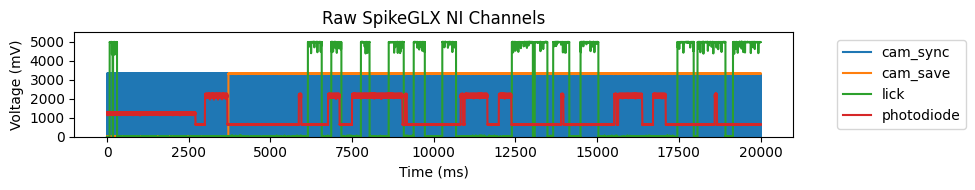

In [6]:
from spike_glx.read_SGLX import read_SGLX, plot_channels_raw

print('Reading SGLX meta and bin files...')
meta, chan_dict = read_SGLX()
print(' Complete.')
print('Plotting channels...')
plot_channels_raw(None, meta, chan_dict, signal_dict, tStart=0, tEnd=20)

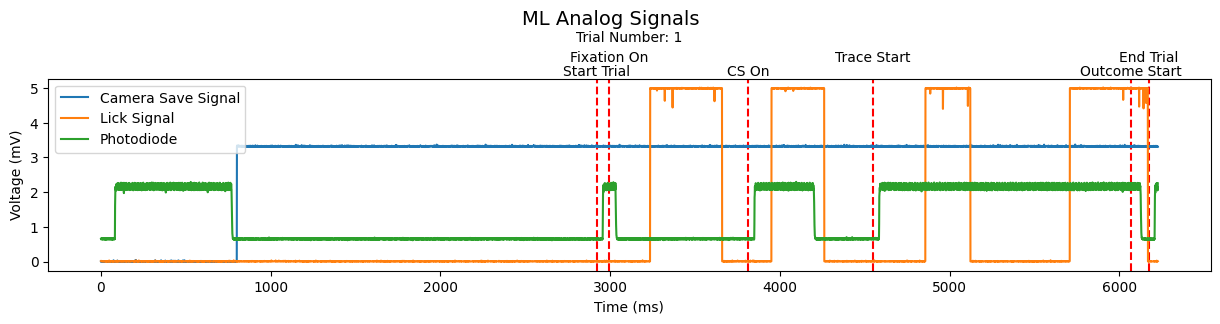

In [5]:
from spike_glx.read_SGLX import plot_analog_ML
# epochs = ['Start Trial', 'Fixation On', 'CS On',	
#           'Trace Start', 'Outcome Start', 'End Trial']
plot_analog_ML(session_obj.df, epochs, trial_num=1)

In [ ]:
from spike_glx.load_SGLX import load_sglx

# Load the spikeglx object
spikeglx_obj = load_sglx(session_obj.df, 
                         session_obj, 
                         file_container_obj, 
                         signal_dict, 
                         epochs)

### ML-SpikeGLX Session Correlation
To see just the correlation matrix for each trial in a session, run `plot_spikeglx_ml_corr` with the newly-generated `spikeglx_obj`.

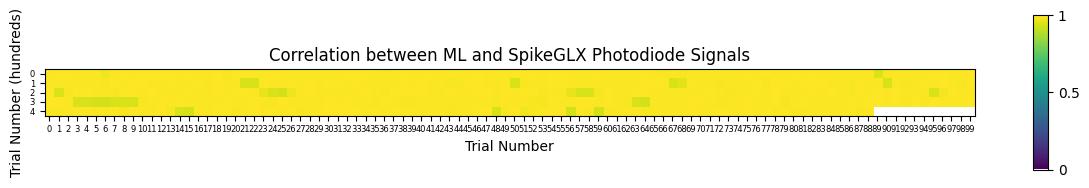

In [8]:
from spike_glx.read_SGLX import plot_spikeglx_ml_corr
plot_spikeglx_ml_corr(spikeglx_obj.ml_sglx_corr_matrix, 100)

***
## Process White Matter Videos

After generating a `SpikeGLX` object, you can segment all the White Matter videos by trial.

In [22]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 0,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False,               # 'thread_flag': False
          'exclude_camera': ['e3v83c5']}      # 'exclude_camera': ['e3v83c5']        

parse_wm_videos(**kwargs)

Included Cameras: dict_keys(['e3v831b', 'e3v8360', 'e3v83ad', 'e3v83c5', 'e3v83d6'])
  Excluded Camera(s): ['e3v83c5']
Parsing Trials for Videos: 0 - 490
  Epoch Start: Trace Start
  Epoch End: Outcome Start
  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 450 | Frame End: 632


Cam: e3v831b | Trial: 0 | Frames: 450-632:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 450 | Frame End: 632


Cam: e3v8360 | Trial: 0 | Frames: 450-632:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 450 | Frame End: 632


Cam: e3v83ad | Trial: 0 | Frames: 450-632:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 450 | Frame End: 632


Cam: e3v83d6 | Trial: 0 | Frames: 450-632:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 1033 | Frame End: 1214


Cam: e3v831b | Trial: 1 | Frames: 1033-1214:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 1033 | Frame End: 1214


Cam: e3v8360 | Trial: 1 | Frames: 1033-1214:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 1033 | Frame End: 1214


Cam: e3v83ad | Trial: 1 | Frames: 1033-1214:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 1033 | Frame End: 1214


Cam: e3v83d6 | Trial: 1 | Frames: 1033-1214:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 1599 | Frame End: 1780


Cam: e3v831b | Trial: 2 | Frames: 1599-1780:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 1599 | Frame End: 1780


Cam: e3v8360 | Trial: 2 | Frames: 1599-1780:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 1599 | Frame End: 1780


Cam: e3v83ad | Trial: 2 | Frames: 1599-1780:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 1599 | Frame End: 1780


Cam: e3v83d6 | Trial: 2 | Frames: 1599-1780:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 2178 | Frame End: 2358


Cam: e3v831b | Trial: 3 | Frames: 2178-2358:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 2178 | Frame End: 2358


Cam: e3v8360 | Trial: 3 | Frames: 2178-2358:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 2178 | Frame End: 2358


Cam: e3v83ad | Trial: 3 | Frames: 2178-2358:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 2178 | Frame End: 2358


Cam: e3v83d6 | Trial: 3 | Frames: 2178-2358:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 2757 | Frame End: 2939


Cam: e3v831b | Trial: 4 | Frames: 2757-2939:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 2757 | Frame End: 2939


Cam: e3v8360 | Trial: 4 | Frames: 2757-2939:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 2757 | Frame End: 2939


Cam: e3v83ad | Trial: 4 | Frames: 2757-2939:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 2757 | Frame End: 2939


Cam: e3v83d6 | Trial: 4 | Frames: 2757-2939:   0%|          | 0/182 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for trial 5
Epochs not found for trial 5
  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for trial 5
Epochs not found for trial 5
  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for trial 5
Epochs not found for trial 5
  Something went wrong with video parsing for trial 5
  Something went wrong with video parsing for tri

Cam: e3v831b | Trial: 7 | Frames: 9624-9805:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 9624 | Frame End: 9805


Cam: e3v8360 | Trial: 7 | Frames: 9624-9805:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 9624 | Frame End: 9805


Cam: e3v83ad | Trial: 7 | Frames: 9624-9805:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 9624 | Frame End: 9805


Cam: e3v83d6 | Trial: 7 | Frames: 9624-9805:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 10186 | Frame End: 10367


Cam: e3v831b | Trial: 8 | Frames: 10186-10367:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 10186 | Frame End: 10367


Cam: e3v8360 | Trial: 8 | Frames: 10186-10367:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 10186 | Frame End: 10367


Cam: e3v83ad | Trial: 8 | Frames: 10186-10367:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 10186 | Frame End: 10367


Cam: e3v83d6 | Trial: 8 | Frames: 10186-10367:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 10873 | Frame End: 11053


Cam: e3v831b | Trial: 9 | Frames: 10873-11053:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 10873 | Frame End: 11053


Cam: e3v8360 | Trial: 9 | Frames: 10873-11053:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 10873 | Frame End: 11053


Cam: e3v83ad | Trial: 9 | Frames: 10873-11053:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 10873 | Frame End: 11053


Cam: e3v83d6 | Trial: 9 | Frames: 10873-11053:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 11711 | Frame End: 11744


Cam: e3v831b | Trial: 10 | Frames: 11711-11744:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 11711 | Frame End: 11744


Cam: e3v8360 | Trial: 10 | Frames: 11711-11744:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 11711 | Frame End: 11744


Cam: e3v83ad | Trial: 10 | Frames: 11711-11744:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 11711 | Frame End: 11744


Cam: e3v83d6 | Trial: 10 | Frames: 11711-11744:   0%|          | 0/33 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 11
  Something went wrong with video parsing for trial 11
  Something went wrong with video parsing for trial 11
  Something went wrong with video parsing for trial 11
  Something went wrong with video parsing for trial 11
Epochs not found for trial 11
  Something went wrong with video parsing for trial 11
  Something went wrong with video parsing for trial 11
  Something went wrong with video parsing for trial 11
  Something went wrong with video parsing for trial 11
  Something went wrong with video parsing for trial 11
Epochs not found for trial 11
  Something went wrong with video parsing for trial 11
  Something went wrong with video parsing for trial 11
  Something went wrong with video parsing for trial 11
  Something went wrong with video parsing for trial 11
  Something went wrong with video parsing for trial 11
Epochs not found for trial 11
  Something went wrong with video parsing for trial 11
  Something went wrong with vi

Cam: e3v831b | Trial: 13 | Frames: 14081-14262:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 14081 | Frame End: 14262


Cam: e3v8360 | Trial: 13 | Frames: 14081-14262:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 14081 | Frame End: 14262


Cam: e3v83ad | Trial: 13 | Frames: 14081-14262:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 14081 | Frame End: 14262


Cam: e3v83d6 | Trial: 13 | Frames: 14081-14262:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 14756 | Frame End: 14936


Cam: e3v831b | Trial: 14 | Frames: 14756-14936:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 14756 | Frame End: 14936


Cam: e3v8360 | Trial: 14 | Frames: 14756-14936:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 14756 | Frame End: 14936


Cam: e3v83ad | Trial: 14 | Frames: 14756-14936:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 14756 | Frame End: 14936


Cam: e3v83d6 | Trial: 14 | Frames: 14756-14936:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 15550 | Frame End: 15730


Cam: e3v831b | Trial: 15 | Frames: 15550-15730:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 15550 | Frame End: 15730


Cam: e3v8360 | Trial: 15 | Frames: 15550-15730:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 15550 | Frame End: 15730


Cam: e3v83ad | Trial: 15 | Frames: 15550-15730:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 15550 | Frame End: 15730


Cam: e3v83d6 | Trial: 15 | Frames: 15550-15730:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 16353 | Frame End: 16535


Cam: e3v831b | Trial: 16 | Frames: 16353-16535:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 16353 | Frame End: 16535


Cam: e3v8360 | Trial: 16 | Frames: 16353-16535:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 16353 | Frame End: 16535


Cam: e3v83ad | Trial: 16 | Frames: 16353-16535:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 16353 | Frame End: 16535


Cam: e3v83d6 | Trial: 16 | Frames: 16353-16535:   0%|          | 0/182 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 17
  Something went wrong with video parsing for trial 17
  Something went wrong with video parsing for trial 17
  Something went wrong with video parsing for trial 17
  Something went wrong with video parsing for trial 17
Epochs not found for trial 17
  Something went wrong with video parsing for trial 17
  Something went wrong with video parsing for trial 17
  Something went wrong with video parsing for trial 17
  Something went wrong with video parsing for trial 17
  Something went wrong with video parsing for trial 17
Epochs not found for trial 17
  Something went wrong with video parsing for trial 17
  Something went wrong with video parsing for trial 17
  Something went wrong with video parsing for trial 17
  Something went wrong with video parsing for trial 17
  Something went wrong with video parsing for trial 17
Epochs not found for trial 17
  Something went wrong with video parsing for trial 17
  Something went wrong with vi

Cam: e3v831b | Trial: 19 | Frames: 19282-19313:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 19282 | Frame End: 19313


Cam: e3v8360 | Trial: 19 | Frames: 19282-19313:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 19282 | Frame End: 19313


Cam: e3v83ad | Trial: 19 | Frames: 19282-19313:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 19282 | Frame End: 19313


Cam: e3v83d6 | Trial: 19 | Frames: 19282-19313:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 19811 | Frame End: 19991


Cam: e3v831b | Trial: 20 | Frames: 19811-19991:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 19811 | Frame End: 19991


Cam: e3v8360 | Trial: 20 | Frames: 19811-19991:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 19811 | Frame End: 19991


Cam: e3v83ad | Trial: 20 | Frames: 19811-19991:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 19811 | Frame End: 19991


Cam: e3v83d6 | Trial: 20 | Frames: 19811-19991:   0%|          | 0/180 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 21
  Something went wrong with video parsing for trial 21
  Something went wrong with video parsing for trial 21
  Something went wrong with video parsing for trial 21
  Something went wrong with video parsing for trial 21
Epochs not found for trial 21
  Something went wrong with video parsing for trial 21
  Something went wrong with video parsing for trial 21
  Something went wrong with video parsing for trial 21
  Something went wrong with video parsing for trial 21
  Something went wrong with video parsing for trial 21
Epochs not found for trial 21
  Something went wrong with video parsing for trial 21
  Something went wrong with video parsing for trial 21
  Something went wrong with video parsing for trial 21
  Something went wrong with video parsing for trial 21
  Something went wrong with video parsing for trial 21
Epochs not found for trial 21
  Something went wrong with video parsing for trial 21
  Something went wrong with vi

Cam: e3v831b | Trial: 22 | Frames: 21018-21200:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 21018 | Frame End: 21200


Cam: e3v8360 | Trial: 22 | Frames: 21018-21200:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 21018 | Frame End: 21200


Cam: e3v83ad | Trial: 22 | Frames: 21018-21200:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 21018 | Frame End: 21200


Cam: e3v83d6 | Trial: 22 | Frames: 21018-21200:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 22361 | Frame End: 22540


Cam: e3v831b | Trial: 23 | Frames: 22361-22540:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 22361 | Frame End: 22540


Cam: e3v8360 | Trial: 23 | Frames: 22361-22540:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 22361 | Frame End: 22540


Cam: e3v83ad | Trial: 23 | Frames: 22361-22540:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 22361 | Frame End: 22540


Cam: e3v83d6 | Trial: 23 | Frames: 22361-22540:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 23449 | Frame End: 23629


Cam: e3v831b | Trial: 24 | Frames: 23449-23629:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 23449 | Frame End: 23629


Cam: e3v8360 | Trial: 24 | Frames: 23449-23629:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 23449 | Frame End: 23629


Cam: e3v83ad | Trial: 24 | Frames: 23449-23629:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 23449 | Frame End: 23629


Cam: e3v83d6 | Trial: 24 | Frames: 23449-23629:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 24134 | Frame End: 24312


Cam: e3v831b | Trial: 25 | Frames: 24134-24312:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 24134 | Frame End: 24312


Cam: e3v8360 | Trial: 25 | Frames: 24134-24312:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 24134 | Frame End: 24312


Cam: e3v83ad | Trial: 25 | Frames: 24134-24312:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 24134 | Frame End: 24312


Cam: e3v83d6 | Trial: 25 | Frames: 24134-24312:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 25198 | Frame End: 25378


Cam: e3v831b | Trial: 26 | Frames: 25198-25378:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 25198 | Frame End: 25378


Cam: e3v8360 | Trial: 26 | Frames: 25198-25378:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 25198 | Frame End: 25378


Cam: e3v83ad | Trial: 26 | Frames: 25198-25378:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 25198 | Frame End: 25378


Cam: e3v83d6 | Trial: 26 | Frames: 25198-25378:   0%|          | 0/180 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 27
  Something went wrong with video parsing for trial 27
  Something went wrong with video parsing for trial 27
  Something went wrong with video parsing for trial 27
  Something went wrong with video parsing for trial 27
Epochs not found for trial 27
  Something went wrong with video parsing for trial 27
  Something went wrong with video parsing for trial 27
  Something went wrong with video parsing for trial 27
  Something went wrong with video parsing for trial 27
  Something went wrong with video parsing for trial 27
Epochs not found for trial 27
  Something went wrong with video parsing for trial 27
  Something went wrong with video parsing for trial 27
  Something went wrong with video parsing for trial 27
  Something went wrong with video parsing for trial 27
  Something went wrong with video parsing for trial 27
Epochs not found for trial 27
  Something went wrong with video parsing for trial 27
  Something went wrong with vi

Cam: e3v831b | Trial: 28 | Frames: 26470-26498:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 26470 | Frame End: 26498


Cam: e3v8360 | Trial: 28 | Frames: 26470-26498:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 26470 | Frame End: 26498


Cam: e3v83ad | Trial: 28 | Frames: 26470-26498:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 26470 | Frame End: 26498


Cam: e3v83d6 | Trial: 28 | Frames: 26470-26498:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 27082 | Frame End: 27111


Cam: e3v831b | Trial: 29 | Frames: 27082-27111:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 27082 | Frame End: 27111


Cam: e3v8360 | Trial: 29 | Frames: 27082-27111:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 27082 | Frame End: 27111


Cam: e3v83ad | Trial: 29 | Frames: 27082-27111:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 27082 | Frame End: 27111


Cam: e3v83d6 | Trial: 29 | Frames: 27082-27111:   0%|          | 0/29 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 30
  Something went wrong with video parsing for trial 30
  Something went wrong with video parsing for trial 30
  Something went wrong with video parsing for trial 30
  Something went wrong with video parsing for trial 30
Epochs not found for trial 30
  Something went wrong with video parsing for trial 30
  Something went wrong with video parsing for trial 30
  Something went wrong with video parsing for trial 30
  Something went wrong with video parsing for trial 30
  Something went wrong with video parsing for trial 30
Epochs not found for trial 30
  Something went wrong with video parsing for trial 30
  Something went wrong with video parsing for trial 30
  Something went wrong with video parsing for trial 30
  Something went wrong with video parsing for trial 30
  Something went wrong with video parsing for trial 30
Epochs not found for trial 30
  Something went wrong with video parsing for trial 30
  Something went wrong with vi

Cam: e3v831b | Trial: 31 | Frames: 29009-29193:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 29009 | Frame End: 29193


Cam: e3v8360 | Trial: 31 | Frames: 29009-29193:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 29009 | Frame End: 29193


Cam: e3v83ad | Trial: 31 | Frames: 29009-29193:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 29009 | Frame End: 29193


Cam: e3v83d6 | Trial: 31 | Frames: 29009-29193:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 30387 | Frame End: 30565


Cam: e3v831b | Trial: 32 | Frames: 30387-30565:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 30387 | Frame End: 30565


Cam: e3v8360 | Trial: 32 | Frames: 30387-30565:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 30387 | Frame End: 30565


Cam: e3v83ad | Trial: 32 | Frames: 30387-30565:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 30387 | Frame End: 30565


Cam: e3v83d6 | Trial: 32 | Frames: 30387-30565:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 31490 | Frame End: 31671


Cam: e3v831b | Trial: 33 | Frames: 31490-31671:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 31490 | Frame End: 31671


Cam: e3v8360 | Trial: 33 | Frames: 31490-31671:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 31490 | Frame End: 31671


Cam: e3v83ad | Trial: 33 | Frames: 31490-31671:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 31490 | Frame End: 31671


Cam: e3v83d6 | Trial: 33 | Frames: 31490-31671:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 32164 | Frame End: 32342


Cam: e3v831b | Trial: 34 | Frames: 32164-32342:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 32164 | Frame End: 32342


Cam: e3v8360 | Trial: 34 | Frames: 32164-32342:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 32164 | Frame End: 32342


Cam: e3v83ad | Trial: 34 | Frames: 32164-32342:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 32164 | Frame End: 32342


Cam: e3v83d6 | Trial: 34 | Frames: 32164-32342:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 32951 | Frame End: 33134


Cam: e3v831b | Trial: 35 | Frames: 32951-33134:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 32951 | Frame End: 33134


Cam: e3v8360 | Trial: 35 | Frames: 32951-33134:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 32951 | Frame End: 33134


Cam: e3v83ad | Trial: 35 | Frames: 32951-33134:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 32951 | Frame End: 33134


Cam: e3v83d6 | Trial: 35 | Frames: 32951-33134:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 34274 | Frame End: 34307


Cam: e3v831b | Trial: 36 | Frames: 34274-34307:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 34274 | Frame End: 34307


Cam: e3v8360 | Trial: 36 | Frames: 34274-34307:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 34274 | Frame End: 34307


Cam: e3v83ad | Trial: 36 | Frames: 34274-34307:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 34274 | Frame End: 34307


Cam: e3v83d6 | Trial: 36 | Frames: 34274-34307:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 35465 | Frame End: 35647


Cam: e3v831b | Trial: 37 | Frames: 35465-35647:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 35465 | Frame End: 35647


Cam: e3v8360 | Trial: 37 | Frames: 35465-35647:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 35465 | Frame End: 35647


Cam: e3v83ad | Trial: 37 | Frames: 35465-35647:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 35465 | Frame End: 35647


Cam: e3v83d6 | Trial: 37 | Frames: 35465-35647:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 36796 | Frame End: 36978


Cam: e3v831b | Trial: 38 | Frames: 36796-36978:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 36796 | Frame End: 36978


Cam: e3v8360 | Trial: 38 | Frames: 36796-36978:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 36796 | Frame End: 36978


Cam: e3v83ad | Trial: 38 | Frames: 36796-36978:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 36796 | Frame End: 36978


Cam: e3v83d6 | Trial: 38 | Frames: 36796-36978:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 37481 | Frame End: 37664


Cam: e3v831b | Trial: 39 | Frames: 37481-37664:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 37481 | Frame End: 37664


Cam: e3v8360 | Trial: 39 | Frames: 37481-37664:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 37481 | Frame End: 37664


Cam: e3v83ad | Trial: 39 | Frames: 37481-37664:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 37481 | Frame End: 37664


Cam: e3v83d6 | Trial: 39 | Frames: 37481-37664:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 38820 | Frame End: 39002


Cam: e3v831b | Trial: 40 | Frames: 38820-39002:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 38820 | Frame End: 39002


Cam: e3v8360 | Trial: 40 | Frames: 38820-39002:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 38820 | Frame End: 39002


Cam: e3v83ad | Trial: 40 | Frames: 38820-39002:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 38820 | Frame End: 39002


Cam: e3v83d6 | Trial: 40 | Frames: 38820-39002:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 40159 | Frame End: 40337


Cam: e3v831b | Trial: 41 | Frames: 40159-40337:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 40159 | Frame End: 40337


Cam: e3v8360 | Trial: 41 | Frames: 40159-40337:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 40159 | Frame End: 40337


Cam: e3v83ad | Trial: 41 | Frames: 40159-40337:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 40159 | Frame End: 40337


Cam: e3v83d6 | Trial: 41 | Frames: 40159-40337:   0%|          | 0/178 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 42
  Something went wrong with video parsing for trial 42
  Something went wrong with video parsing for trial 42
  Something went wrong with video parsing for trial 42
  Something went wrong with video parsing for trial 42
Epochs not found for trial 42
  Something went wrong with video parsing for trial 42
  Something went wrong with video parsing for trial 42
  Something went wrong with video parsing for trial 42
  Something went wrong with video parsing for trial 42
  Something went wrong with video parsing for trial 42
Epochs not found for trial 42
  Something went wrong with video parsing for trial 42
  Something went wrong with video parsing for trial 42
  Something went wrong with video parsing for trial 42
  Something went wrong with video parsing for trial 42
  Something went wrong with video parsing for trial 42
Epochs not found for trial 42
  Something went wrong with video parsing for trial 42
  Something went wrong with vi

Cam: e3v831b | Trial: 43 | Frames: 41429-41457:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 41429 | Frame End: 41457


Cam: e3v8360 | Trial: 43 | Frames: 41429-41457:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 41429 | Frame End: 41457


Cam: e3v83ad | Trial: 43 | Frames: 41429-41457:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 41429 | Frame End: 41457


Cam: e3v83d6 | Trial: 43 | Frames: 41429-41457:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 42344 | Frame End: 42524


Cam: e3v831b | Trial: 44 | Frames: 42344-42524:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 42344 | Frame End: 42524


Cam: e3v8360 | Trial: 44 | Frames: 42344-42524:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 42344 | Frame End: 42524


Cam: e3v83ad | Trial: 44 | Frames: 42344-42524:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 42344 | Frame End: 42524


Cam: e3v83d6 | Trial: 44 | Frames: 42344-42524:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 43022 | Frame End: 43200


Cam: e3v831b | Trial: 45 | Frames: 43022-43200:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 43022 | Frame End: 43200


Cam: e3v8360 | Trial: 45 | Frames: 43022-43200:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 43022 | Frame End: 43200


Cam: e3v83ad | Trial: 45 | Frames: 43022-43200:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 43022 | Frame End: 43200


Cam: e3v83d6 | Trial: 45 | Frames: 43022-43200:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 44067 | Frame End: 44096


Cam: e3v831b | Trial: 46 | Frames: 44067-44096:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 44067 | Frame End: 44096


Cam: e3v8360 | Trial: 46 | Frames: 44067-44096:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 44067 | Frame End: 44096


Cam: e3v83ad | Trial: 46 | Frames: 44067-44096:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 44067 | Frame End: 44096


Cam: e3v83d6 | Trial: 46 | Frames: 44067-44096:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 44713 | Frame End: 44897


Cam: e3v831b | Trial: 47 | Frames: 44713-44897:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 44713 | Frame End: 44897


Cam: e3v8360 | Trial: 47 | Frames: 44713-44897:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 44713 | Frame End: 44897


Cam: e3v83ad | Trial: 47 | Frames: 44713-44897:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 44713 | Frame End: 44897


Cam: e3v83d6 | Trial: 47 | Frames: 44713-44897:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 46059 | Frame End: 46238


Cam: e3v831b | Trial: 48 | Frames: 46059-46238:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 46059 | Frame End: 46238


Cam: e3v8360 | Trial: 48 | Frames: 46059-46238:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 46059 | Frame End: 46238


Cam: e3v83ad | Trial: 48 | Frames: 46059-46238:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 46059 | Frame End: 46238


Cam: e3v83d6 | Trial: 48 | Frames: 46059-46238:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 47139 | Frame End: 47318


Cam: e3v831b | Trial: 49 | Frames: 47139-47318:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 47139 | Frame End: 47318


Cam: e3v8360 | Trial: 49 | Frames: 47139-47318:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 47139 | Frame End: 47318


Cam: e3v83ad | Trial: 49 | Frames: 47139-47318:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 47139 | Frame End: 47318


Cam: e3v83d6 | Trial: 49 | Frames: 47139-47318:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 47936 | Frame End: 48115


Cam: e3v831b | Trial: 50 | Frames: 47936-48115:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 47936 | Frame End: 48115


Cam: e3v8360 | Trial: 50 | Frames: 47936-48115:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 47936 | Frame End: 48115


Cam: e3v83ad | Trial: 50 | Frames: 47936-48115:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 47936 | Frame End: 48115


Cam: e3v83d6 | Trial: 50 | Frames: 47936-48115:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 48736 | Frame End: 48915


Cam: e3v831b | Trial: 51 | Frames: 48736-48915:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 48736 | Frame End: 48915


Cam: e3v8360 | Trial: 51 | Frames: 48736-48915:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 48736 | Frame End: 48915


Cam: e3v83ad | Trial: 51 | Frames: 48736-48915:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 48736 | Frame End: 48915


Cam: e3v83d6 | Trial: 51 | Frames: 48736-48915:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 49381 | Frame End: 49412


Cam: e3v831b | Trial: 52 | Frames: 49381-49412:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 49381 | Frame End: 49412


Cam: e3v8360 | Trial: 52 | Frames: 49381-49412:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 49381 | Frame End: 49412


Cam: e3v83ad | Trial: 52 | Frames: 49381-49412:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 49381 | Frame End: 49412


Cam: e3v83d6 | Trial: 52 | Frames: 49381-49412:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 49905 | Frame End: 50085


Cam: e3v831b | Trial: 53 | Frames: 49905-50085:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 49905 | Frame End: 50085


Cam: e3v8360 | Trial: 53 | Frames: 49905-50085:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 49905 | Frame End: 50085


Cam: e3v83ad | Trial: 53 | Frames: 49905-50085:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 49905 | Frame End: 50085


Cam: e3v83d6 | Trial: 53 | Frames: 49905-50085:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 50718 | Frame End: 50898


Cam: e3v831b | Trial: 54 | Frames: 50718-50898:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 50718 | Frame End: 50898


Cam: e3v8360 | Trial: 54 | Frames: 50718-50898:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 50718 | Frame End: 50898


Cam: e3v83ad | Trial: 54 | Frames: 50718-50898:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 50718 | Frame End: 50898


Cam: e3v83d6 | Trial: 54 | Frames: 50718-50898:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 51793 | Frame End: 51974


Cam: e3v831b | Trial: 55 | Frames: 51793-51974:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 51793 | Frame End: 51974


Cam: e3v8360 | Trial: 55 | Frames: 51793-51974:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 51793 | Frame End: 51974


Cam: e3v83ad | Trial: 55 | Frames: 51793-51974:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 51793 | Frame End: 51974


Cam: e3v83d6 | Trial: 55 | Frames: 51793-51974:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 52471 | Frame End: 52650


Cam: e3v831b | Trial: 56 | Frames: 52471-52650:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 52471 | Frame End: 52650


Cam: e3v8360 | Trial: 56 | Frames: 52471-52650:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 52471 | Frame End: 52650


Cam: e3v83ad | Trial: 56 | Frames: 52471-52650:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 52471 | Frame End: 52650


Cam: e3v83d6 | Trial: 56 | Frames: 52471-52650:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 53560 | Frame End: 53740


Cam: e3v831b | Trial: 57 | Frames: 53560-53740:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 53560 | Frame End: 53740


Cam: e3v8360 | Trial: 57 | Frames: 53560-53740:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 53560 | Frame End: 53740


Cam: e3v83ad | Trial: 57 | Frames: 53560-53740:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 53560 | Frame End: 53740


Cam: e3v83d6 | Trial: 57 | Frames: 53560-53740:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 54243 | Frame End: 54427


Cam: e3v831b | Trial: 58 | Frames: 54243-54427:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 54243 | Frame End: 54427


Cam: e3v8360 | Trial: 58 | Frames: 54243-54427:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 54243 | Frame End: 54427


Cam: e3v83ad | Trial: 58 | Frames: 54243-54427:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 54243 | Frame End: 54427


Cam: e3v83d6 | Trial: 58 | Frames: 54243-54427:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 55611 | Frame End: 55791


Cam: e3v831b | Trial: 59 | Frames: 55611-55791:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 55611 | Frame End: 55791


Cam: e3v8360 | Trial: 59 | Frames: 55611-55791:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 55611 | Frame End: 55791


Cam: e3v83ad | Trial: 59 | Frames: 55611-55791:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 55611 | Frame End: 55791


Cam: e3v83d6 | Trial: 59 | Frames: 55611-55791:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 56412 | Frame End: 56594


Cam: e3v831b | Trial: 60 | Frames: 56412-56594:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 56412 | Frame End: 56594


Cam: e3v8360 | Trial: 60 | Frames: 56412-56594:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 56412 | Frame End: 56594


Cam: e3v83ad | Trial: 60 | Frames: 56412-56594:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 56412 | Frame End: 56594


Cam: e3v83d6 | Trial: 60 | Frames: 56412-56594:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 57766 | Frame End: 57946


Cam: e3v831b | Trial: 61 | Frames: 57766-57946:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 57766 | Frame End: 57946


Cam: e3v8360 | Trial: 61 | Frames: 57766-57946:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 57766 | Frame End: 57946


Cam: e3v83ad | Trial: 61 | Frames: 57766-57946:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 57766 | Frame End: 57946


Cam: e3v83d6 | Trial: 61 | Frames: 57766-57946:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 58421 | Frame End: 58450


Cam: e3v831b | Trial: 62 | Frames: 58421-58450:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 58421 | Frame End: 58450


Cam: e3v8360 | Trial: 62 | Frames: 58421-58450:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 58421 | Frame End: 58450


Cam: e3v83ad | Trial: 62 | Frames: 58421-58450:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 58421 | Frame End: 58450


Cam: e3v83d6 | Trial: 62 | Frames: 58421-58450:   0%|          | 0/29 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 63
  Something went wrong with video parsing for trial 63
  Something went wrong with video parsing for trial 63
  Something went wrong with video parsing for trial 63
  Something went wrong with video parsing for trial 63
Epochs not found for trial 63
  Something went wrong with video parsing for trial 63
  Something went wrong with video parsing for trial 63
  Something went wrong with video parsing for trial 63
  Something went wrong with video parsing for trial 63
  Something went wrong with video parsing for trial 63
Epochs not found for trial 63
  Something went wrong with video parsing for trial 63
  Something went wrong with video parsing for trial 63
  Something went wrong with video parsing for trial 63
  Something went wrong with video parsing for trial 63
  Something went wrong with video parsing for trial 63
Epochs not found for trial 63
  Something went wrong with video parsing for trial 63
  Something went wrong with vi

Cam: e3v831b | Trial: 65 | Frames: 60472-60652:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 60472 | Frame End: 60652


Cam: e3v8360 | Trial: 65 | Frames: 60472-60652:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 60472 | Frame End: 60652


Cam: e3v83ad | Trial: 65 | Frames: 60472-60652:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 60472 | Frame End: 60652


Cam: e3v83d6 | Trial: 65 | Frames: 60472-60652:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 61143 | Frame End: 61175


Cam: e3v831b | Trial: 66 | Frames: 61143-61175:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 61143 | Frame End: 61175


Cam: e3v8360 | Trial: 66 | Frames: 61143-61175:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 61143 | Frame End: 61175


Cam: e3v83ad | Trial: 66 | Frames: 61143-61175:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 61143 | Frame End: 61175


Cam: e3v83d6 | Trial: 66 | Frames: 61143-61175:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 62304 | Frame End: 62335


Cam: e3v831b | Trial: 67 | Frames: 62304-62335:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 62304 | Frame End: 62335


Cam: e3v8360 | Trial: 67 | Frames: 62304-62335:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 62304 | Frame End: 62335


Cam: e3v83ad | Trial: 67 | Frames: 62304-62335:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 62304 | Frame End: 62335


Cam: e3v83d6 | Trial: 67 | Frames: 62304-62335:   0%|          | 0/31 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 68
  Something went wrong with video parsing for trial 68
  Something went wrong with video parsing for trial 68
  Something went wrong with video parsing for trial 68
  Something went wrong with video parsing for trial 68
Epochs not found for trial 68
  Something went wrong with video parsing for trial 68
  Something went wrong with video parsing for trial 68
  Something went wrong with video parsing for trial 68
  Something went wrong with video parsing for trial 68
  Something went wrong with video parsing for trial 68
Epochs not found for trial 68
  Something went wrong with video parsing for trial 68
  Something went wrong with video parsing for trial 68
  Something went wrong with video parsing for trial 68
  Something went wrong with video parsing for trial 68
  Something went wrong with video parsing for trial 68
Epochs not found for trial 68
  Something went wrong with video parsing for trial 68
  Something went wrong with vi

Cam: e3v831b | Trial: 70 | Frames: 63738-63922:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 63738 | Frame End: 63922


Cam: e3v8360 | Trial: 70 | Frames: 63738-63922:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 63738 | Frame End: 63922


Cam: e3v83ad | Trial: 70 | Frames: 63738-63922:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 63738 | Frame End: 63922


Cam: e3v83d6 | Trial: 70 | Frames: 63738-63922:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 65083 | Frame End: 65262


Cam: e3v831b | Trial: 71 | Frames: 65083-65262:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 65083 | Frame End: 65262


Cam: e3v8360 | Trial: 71 | Frames: 65083-65262:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 65083 | Frame End: 65262


Cam: e3v83ad | Trial: 71 | Frames: 65083-65262:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 65083 | Frame End: 65262


Cam: e3v83d6 | Trial: 71 | Frames: 65083-65262:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 72
  Something went wrong with video parsing for trial 72
  Something went wrong with video parsing for trial 72
  Something went wrong with video parsing for trial 72
  Something went wrong with video parsing for trial 72
Epochs not found for trial 72
  Something went wrong with video parsing for trial 72
  Something went wrong with video parsing for trial 72
  Something went wrong with video parsing for trial 72
  Something went wrong with video parsing for trial 72
  Something went wrong with video parsing for trial 72
Epochs not found for trial 72
  Something went wrong with video parsing for trial 72
  Something went wrong with video parsing for trial 72
  Something went wrong with video parsing for trial 72
  Something went wrong with video parsing for trial 72
  Something went wrong with video parsing for trial 72
Epochs not found for trial 72
  Something went wrong with video parsing for trial 72
  Something went wrong with vi

Cam: e3v831b | Trial: 73 | Frames: 66674-66853:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 66674 | Frame End: 66853


Cam: e3v8360 | Trial: 73 | Frames: 66674-66853:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 66674 | Frame End: 66853


Cam: e3v83ad | Trial: 73 | Frames: 66674-66853:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 66674 | Frame End: 66853


Cam: e3v83d6 | Trial: 73 | Frames: 66674-66853:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 67729 | Frame End: 67757


Cam: e3v831b | Trial: 74 | Frames: 67729-67757:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 67729 | Frame End: 67757


Cam: e3v8360 | Trial: 74 | Frames: 67729-67757:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 67729 | Frame End: 67757


Cam: e3v83ad | Trial: 74 | Frames: 67729-67757:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 67729 | Frame End: 67757


Cam: e3v83d6 | Trial: 74 | Frames: 67729-67757:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 68625 | Frame End: 68654


Cam: e3v831b | Trial: 75 | Frames: 68625-68654:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 68625 | Frame End: 68654


Cam: e3v8360 | Trial: 75 | Frames: 68625-68654:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 68625 | Frame End: 68654


Cam: e3v83ad | Trial: 75 | Frames: 68625-68654:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 68625 | Frame End: 68654


Cam: e3v83d6 | Trial: 75 | Frames: 68625-68654:   0%|          | 0/29 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 76
  Something went wrong with video parsing for trial 76
  Something went wrong with video parsing for trial 76
  Something went wrong with video parsing for trial 76
  Something went wrong with video parsing for trial 76
Epochs not found for trial 76
  Something went wrong with video parsing for trial 76
  Something went wrong with video parsing for trial 76
  Something went wrong with video parsing for trial 76
  Something went wrong with video parsing for trial 76
  Something went wrong with video parsing for trial 76
Epochs not found for trial 76
  Something went wrong with video parsing for trial 76
  Something went wrong with video parsing for trial 76
  Something went wrong with video parsing for trial 76
  Something went wrong with video parsing for trial 76
  Something went wrong with video parsing for trial 76
Epochs not found for trial 76
  Something went wrong with video parsing for trial 76
  Something went wrong with vi

Cam: e3v831b | Trial: 77 | Frames: 70021-70050:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 70021 | Frame End: 70050


Cam: e3v8360 | Trial: 77 | Frames: 70021-70050:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 70021 | Frame End: 70050


Cam: e3v83ad | Trial: 77 | Frames: 70021-70050:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 70021 | Frame End: 70050


Cam: e3v83d6 | Trial: 77 | Frames: 70021-70050:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 70929 | Frame End: 70958


Cam: e3v831b | Trial: 78 | Frames: 70929-70958:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 70929 | Frame End: 70958


Cam: e3v8360 | Trial: 78 | Frames: 70929-70958:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 70929 | Frame End: 70958


Cam: e3v83ad | Trial: 78 | Frames: 70929-70958:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 70929 | Frame End: 70958


Cam: e3v83d6 | Trial: 78 | Frames: 70929-70958:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 71453 | Frame End: 71632


Cam: e3v831b | Trial: 79 | Frames: 71453-71632:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 71453 | Frame End: 71632


Cam: e3v8360 | Trial: 79 | Frames: 71453-71632:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 71453 | Frame End: 71632


Cam: e3v83ad | Trial: 79 | Frames: 71453-71632:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 71453 | Frame End: 71632


Cam: e3v83d6 | Trial: 79 | Frames: 71453-71632:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 72248 | Frame End: 72427


Cam: e3v831b | Trial: 80 | Frames: 72248-72427:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 72248 | Frame End: 72427


Cam: e3v8360 | Trial: 80 | Frames: 72248-72427:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 72248 | Frame End: 72427


Cam: e3v83ad | Trial: 80 | Frames: 72248-72427:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 72248 | Frame End: 72427


Cam: e3v83d6 | Trial: 80 | Frames: 72248-72427:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 73024 | Frame End: 73053


Cam: e3v831b | Trial: 81 | Frames: 73024-73053:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 73024 | Frame End: 73053


Cam: e3v8360 | Trial: 81 | Frames: 73024-73053:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 73024 | Frame End: 73053


Cam: e3v83ad | Trial: 81 | Frames: 73024-73053:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 73024 | Frame End: 73053


Cam: e3v83d6 | Trial: 81 | Frames: 73024-73053:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 73948 | Frame End: 74130


Cam: e3v831b | Trial: 82 | Frames: 73948-74130:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 73948 | Frame End: 74130


Cam: e3v8360 | Trial: 82 | Frames: 73948-74130:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 73948 | Frame End: 74130


Cam: e3v83ad | Trial: 82 | Frames: 73948-74130:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 73948 | Frame End: 74130


Cam: e3v83d6 | Trial: 82 | Frames: 73948-74130:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 74650 | Frame End: 74829


Cam: e3v831b | Trial: 83 | Frames: 74650-74829:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 74650 | Frame End: 74829


Cam: e3v8360 | Trial: 83 | Frames: 74650-74829:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 74650 | Frame End: 74829


Cam: e3v83ad | Trial: 83 | Frames: 74650-74829:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 74650 | Frame End: 74829


Cam: e3v83d6 | Trial: 83 | Frames: 74650-74829:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 75706 | Frame End: 75737


Cam: e3v831b | Trial: 84 | Frames: 75706-75737:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 75706 | Frame End: 75737


Cam: e3v8360 | Trial: 84 | Frames: 75706-75737:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 75706 | Frame End: 75737


Cam: e3v83ad | Trial: 84 | Frames: 75706-75737:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 75706 | Frame End: 75737


Cam: e3v83d6 | Trial: 84 | Frames: 75706-75737:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 76211 | Frame End: 76240


Cam: e3v831b | Trial: 85 | Frames: 76211-76240:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 76211 | Frame End: 76240


Cam: e3v8360 | Trial: 85 | Frames: 76211-76240:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 76211 | Frame End: 76240


Cam: e3v83ad | Trial: 85 | Frames: 76211-76240:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 76211 | Frame End: 76240


Cam: e3v83d6 | Trial: 85 | Frames: 76211-76240:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 77142 | Frame End: 77321


Cam: e3v831b | Trial: 86 | Frames: 77142-77321:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 77142 | Frame End: 77321


Cam: e3v8360 | Trial: 86 | Frames: 77142-77321:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 77142 | Frame End: 77321


Cam: e3v83ad | Trial: 86 | Frames: 77142-77321:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 77142 | Frame End: 77321


Cam: e3v83d6 | Trial: 86 | Frames: 77142-77321:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 77819 | Frame End: 77997


Cam: e3v831b | Trial: 87 | Frames: 77819-77997:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 77819 | Frame End: 77997


Cam: e3v8360 | Trial: 87 | Frames: 77819-77997:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 77819 | Frame End: 77997


Cam: e3v83ad | Trial: 87 | Frames: 77819-77997:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 77819 | Frame End: 77997


Cam: e3v83d6 | Trial: 87 | Frames: 77819-77997:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 78863 | Frame End: 79042


Cam: e3v831b | Trial: 88 | Frames: 78863-79042:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 78863 | Frame End: 79042


Cam: e3v8360 | Trial: 88 | Frames: 78863-79042:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 78863 | Frame End: 79042


Cam: e3v83ad | Trial: 88 | Frames: 78863-79042:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 78863 | Frame End: 79042


Cam: e3v83d6 | Trial: 88 | Frames: 78863-79042:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 89
  Something went wrong with video parsing for trial 89
  Something went wrong with video parsing for trial 89
  Something went wrong with video parsing for trial 89
  Something went wrong with video parsing for trial 89
Epochs not found for trial 89
  Something went wrong with video parsing for trial 89
  Something went wrong with video parsing for trial 89
  Something went wrong with video parsing for trial 89
  Something went wrong with video parsing for trial 89
  Something went wrong with video parsing for trial 89
Epochs not found for trial 89
  Something went wrong with video parsing for trial 89
  Something went wrong with video parsing for trial 89
  Something went wrong with video parsing for trial 89
  Something went wrong with video parsing for trial 89
  Something went wrong with video parsing for trial 89
Epochs not found for trial 89
  Something went wrong with video parsing for trial 89
  Something went wrong with vi

Cam: e3v831b | Trial: 90 | Frames: 86759-86938:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 86759 | Frame End: 86938


Cam: e3v8360 | Trial: 90 | Frames: 86759-86938:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 86759 | Frame End: 86938


Cam: e3v83ad | Trial: 90 | Frames: 86759-86938:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 86759 | Frame End: 86938


Cam: e3v83d6 | Trial: 90 | Frames: 86759-86938:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 87835 | Frame End: 88014


Cam: e3v831b | Trial: 91 | Frames: 87835-88014:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 87835 | Frame End: 88014


Cam: e3v8360 | Trial: 91 | Frames: 87835-88014:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 87835 | Frame End: 88014


Cam: e3v83ad | Trial: 91 | Frames: 87835-88014:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 87835 | Frame End: 88014


Cam: e3v83d6 | Trial: 91 | Frames: 87835-88014:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 88919 | Frame End: 89101


Cam: e3v831b | Trial: 92 | Frames: 88919-89101:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 88919 | Frame End: 89101


Cam: e3v8360 | Trial: 92 | Frames: 88919-89101:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 88919 | Frame End: 89101


Cam: e3v83ad | Trial: 92 | Frames: 88919-89101:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 88919 | Frame End: 89101


Cam: e3v83d6 | Trial: 92 | Frames: 88919-89101:   0%|          | 0/182 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 93
  Something went wrong with video parsing for trial 93
  Something went wrong with video parsing for trial 93
  Something went wrong with video parsing for trial 93
  Something went wrong with video parsing for trial 93
Epochs not found for trial 93
  Something went wrong with video parsing for trial 93
  Something went wrong with video parsing for trial 93
  Something went wrong with video parsing for trial 93
  Something went wrong with video parsing for trial 93
  Something went wrong with video parsing for trial 93
Epochs not found for trial 93
  Something went wrong with video parsing for trial 93
  Something went wrong with video parsing for trial 93
  Something went wrong with video parsing for trial 93
  Something went wrong with video parsing for trial 93
  Something went wrong with video parsing for trial 93
Epochs not found for trial 93
  Something went wrong with video parsing for trial 93
  Something went wrong with vi

Cam: e3v831b | Trial: 95 | Frames: 91149-91177:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 91149 | Frame End: 91177


Cam: e3v8360 | Trial: 95 | Frames: 91149-91177:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 91149 | Frame End: 91177


Cam: e3v83ad | Trial: 95 | Frames: 91149-91177:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 91149 | Frame End: 91177


Cam: e3v83d6 | Trial: 95 | Frames: 91149-91177:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 92049 | Frame End: 92228


Cam: e3v831b | Trial: 96 | Frames: 92049-92228:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 92049 | Frame End: 92228


Cam: e3v8360 | Trial: 96 | Frames: 92049-92228:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 92049 | Frame End: 92228


Cam: e3v83ad | Trial: 96 | Frames: 92049-92228:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 92049 | Frame End: 92228


Cam: e3v83d6 | Trial: 96 | Frames: 92049-92228:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 92849 | Frame End: 93027


Cam: e3v831b | Trial: 97 | Frames: 92849-93027:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 92849 | Frame End: 93027


Cam: e3v8360 | Trial: 97 | Frames: 92849-93027:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 92849 | Frame End: 93027


Cam: e3v83ad | Trial: 97 | Frames: 92849-93027:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 92849 | Frame End: 93027


Cam: e3v83d6 | Trial: 97 | Frames: 92849-93027:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 93931 | Frame End: 94109


Cam: e3v831b | Trial: 98 | Frames: 93931-94109:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 93931 | Frame End: 94109


Cam: e3v8360 | Trial: 98 | Frames: 93931-94109:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 93931 | Frame End: 94109


Cam: e3v83ad | Trial: 98 | Frames: 93931-94109:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 93931 | Frame End: 94109


Cam: e3v83d6 | Trial: 98 | Frames: 93931-94109:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 94756 | Frame End: 94936


Cam: e3v831b | Trial: 99 | Frames: 94756-94936:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 94756 | Frame End: 94936


Cam: e3v8360 | Trial: 99 | Frames: 94756-94936:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 94756 | Frame End: 94936


Cam: e3v83ad | Trial: 99 | Frames: 94756-94936:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 94756 | Frame End: 94936


Cam: e3v83d6 | Trial: 99 | Frames: 94756-94936:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 95408 | Frame End: 95586


Cam: e3v831b | Trial: 100 | Frames: 95408-95586:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 95408 | Frame End: 95586


Cam: e3v8360 | Trial: 100 | Frames: 95408-95586:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 95408 | Frame End: 95586


Cam: e3v83ad | Trial: 100 | Frames: 95408-95586:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 95408 | Frame End: 95586


Cam: e3v83d6 | Trial: 100 | Frames: 95408-95586:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 96527 | Frame End: 96709


Cam: e3v831b | Trial: 101 | Frames: 96527-96709:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 96527 | Frame End: 96709


Cam: e3v8360 | Trial: 101 | Frames: 96527-96709:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 96527 | Frame End: 96709


Cam: e3v83ad | Trial: 101 | Frames: 96527-96709:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 96527 | Frame End: 96709


Cam: e3v83d6 | Trial: 101 | Frames: 96527-96709:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 97842 | Frame End: 98021


Cam: e3v831b | Trial: 102 | Frames: 97842-98021:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 97842 | Frame End: 98021


Cam: e3v8360 | Trial: 102 | Frames: 97842-98021:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 97842 | Frame End: 98021


Cam: e3v83ad | Trial: 102 | Frames: 97842-98021:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 97842 | Frame End: 98021


Cam: e3v83d6 | Trial: 102 | Frames: 97842-98021:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 98514 | Frame End: 98697


Cam: e3v831b | Trial: 103 | Frames: 98514-98697:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 98514 | Frame End: 98697


Cam: e3v8360 | Trial: 103 | Frames: 98514-98697:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 98514 | Frame End: 98697


Cam: e3v83ad | Trial: 103 | Frames: 98514-98697:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 98514 | Frame End: 98697


Cam: e3v83d6 | Trial: 103 | Frames: 98514-98697:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 99854 | Frame End: 100036


Cam: e3v831b | Trial: 104 | Frames: 99854-100036:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 99854 | Frame End: 100036


Cam: e3v8360 | Trial: 104 | Frames: 99854-100036:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 99854 | Frame End: 100036


Cam: e3v83ad | Trial: 104 | Frames: 99854-100036:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 99854 | Frame End: 100036


Cam: e3v83d6 | Trial: 104 | Frames: 99854-100036:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 101197 | Frame End: 101375


Cam: e3v831b | Trial: 105 | Frames: 101197-101375:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 101197 | Frame End: 101375


Cam: e3v8360 | Trial: 105 | Frames: 101197-101375:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 101197 | Frame End: 101375


Cam: e3v83ad | Trial: 105 | Frames: 101197-101375:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 101197 | Frame End: 101375


Cam: e3v83d6 | Trial: 105 | Frames: 101197-101375:   0%|          | 0/178 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 106
  Something went wrong with video parsing for trial 106
  Something went wrong with video parsing for trial 106
  Something went wrong with video parsing for trial 106
  Something went wrong with video parsing for trial 106
Epochs not found for trial 106
  Something went wrong with video parsing for trial 106
  Something went wrong with video parsing for trial 106
  Something went wrong with video parsing for trial 106
  Something went wrong with video parsing for trial 106
  Something went wrong with video parsing for trial 106
Epochs not found for trial 106
  Something went wrong with video parsing for trial 106
  Something went wrong with video parsing for trial 106
  Something went wrong with video parsing for trial 106
  Something went wrong with video parsing for trial 106
  Something went wrong with video parsing for trial 106
Epochs not found for trial 106
  Something went wrong with video parsing for trial 106
  Something

Cam: e3v831b | Trial: 107 | Frames: 102474-102503:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 102474 | Frame End: 102503


Cam: e3v8360 | Trial: 107 | Frames: 102474-102503:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 102474 | Frame End: 102503


Cam: e3v83ad | Trial: 107 | Frames: 102474-102503:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 102474 | Frame End: 102503


Cam: e3v83d6 | Trial: 107 | Frames: 102474-102503:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 103394 | Frame End: 103574


Cam: e3v831b | Trial: 108 | Frames: 103394-103574:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 103394 | Frame End: 103574


Cam: e3v8360 | Trial: 108 | Frames: 103394-103574:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 103394 | Frame End: 103574


Cam: e3v83ad | Trial: 108 | Frames: 103394-103574:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 103394 | Frame End: 103574


Cam: e3v83d6 | Trial: 108 | Frames: 103394-103574:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 104073 | Frame End: 104252


Cam: e3v831b | Trial: 109 | Frames: 104073-104252:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 104073 | Frame End: 104252


Cam: e3v8360 | Trial: 109 | Frames: 104073-104252:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 104073 | Frame End: 104252


Cam: e3v83ad | Trial: 109 | Frames: 104073-104252:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 104073 | Frame End: 104252


Cam: e3v83d6 | Trial: 109 | Frames: 104073-104252:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 105139 | Frame End: 105318


Cam: e3v831b | Trial: 110 | Frames: 105139-105318:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 105139 | Frame End: 105318


Cam: e3v8360 | Trial: 110 | Frames: 105139-105318:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 105139 | Frame End: 105318


Cam: e3v83ad | Trial: 110 | Frames: 105139-105318:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 105139 | Frame End: 105318


Cam: e3v83d6 | Trial: 110 | Frames: 105139-105318:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 111
  Something went wrong with video parsing for trial 111
  Something went wrong with video parsing for trial 111
  Something went wrong with video parsing for trial 111
  Something went wrong with video parsing for trial 111
Epochs not found for trial 111
  Something went wrong with video parsing for trial 111
  Something went wrong with video parsing for trial 111
  Something went wrong with video parsing for trial 111
  Something went wrong with video parsing for trial 111
  Something went wrong with video parsing for trial 111
Epochs not found for trial 111
  Something went wrong with video parsing for trial 111
  Something went wrong with video parsing for trial 111
  Something went wrong with video parsing for trial 111
  Something went wrong with video parsing for trial 111
  Something went wrong with video parsing for trial 111
Epochs not found for trial 111
  Something went wrong with video parsing for trial 111
  Something

Cam: e3v831b | Trial: 112 | Frames: 106311-106493:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 106311 | Frame End: 106493


Cam: e3v8360 | Trial: 112 | Frames: 106311-106493:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 106311 | Frame End: 106493


Cam: e3v83ad | Trial: 112 | Frames: 106311-106493:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 106311 | Frame End: 106493


Cam: e3v83d6 | Trial: 112 | Frames: 106311-106493:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 107646 | Frame End: 107826


Cam: e3v831b | Trial: 113 | Frames: 107646-107826:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 107646 | Frame End: 107826


Cam: e3v8360 | Trial: 113 | Frames: 107646-107826:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 107646 | Frame End: 107826


Cam: e3v83ad | Trial: 113 | Frames: 107646-107826:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 107646 | Frame End: 107826


Cam: e3v83d6 | Trial: 113 | Frames: 107646-107826:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 108333 | Frame End: 108513


Cam: e3v831b | Trial: 114 | Frames: 108333-108513:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 108333 | Frame End: 108513


Cam: e3v8360 | Trial: 114 | Frames: 108333-108513:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 108333 | Frame End: 108513


Cam: e3v83ad | Trial: 114 | Frames: 108333-108513:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 108333 | Frame End: 108513


Cam: e3v83d6 | Trial: 114 | Frames: 108333-108513:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 109017 | Frame End: 109199


Cam: e3v831b | Trial: 115 | Frames: 109017-109199:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 109017 | Frame End: 109199


Cam: e3v8360 | Trial: 115 | Frames: 109017-109199:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 109017 | Frame End: 109199


Cam: e3v83ad | Trial: 115 | Frames: 109017-109199:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 109017 | Frame End: 109199


Cam: e3v83d6 | Trial: 115 | Frames: 109017-109199:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 110377 | Frame End: 110556


Cam: e3v831b | Trial: 116 | Frames: 110377-110556:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 110377 | Frame End: 110556


Cam: e3v8360 | Trial: 116 | Frames: 110377-110556:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 110377 | Frame End: 110556


Cam: e3v83ad | Trial: 116 | Frames: 110377-110556:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 110377 | Frame End: 110556


Cam: e3v83d6 | Trial: 116 | Frames: 110377-110556:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 111165 | Frame End: 111345


Cam: e3v831b | Trial: 117 | Frames: 111165-111345:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 111165 | Frame End: 111345


Cam: e3v8360 | Trial: 117 | Frames: 111165-111345:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 111165 | Frame End: 111345


Cam: e3v83ad | Trial: 117 | Frames: 111165-111345:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 111165 | Frame End: 111345


Cam: e3v83d6 | Trial: 117 | Frames: 111165-111345:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 112279 | Frame End: 112457


Cam: e3v831b | Trial: 118 | Frames: 112279-112457:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 112279 | Frame End: 112457


Cam: e3v8360 | Trial: 118 | Frames: 112279-112457:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 112279 | Frame End: 112457


Cam: e3v83ad | Trial: 118 | Frames: 112279-112457:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 112279 | Frame End: 112457


Cam: e3v83d6 | Trial: 118 | Frames: 112279-112457:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 113360 | Frame End: 113542


Cam: e3v831b | Trial: 119 | Frames: 113360-113542:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 113360 | Frame End: 113542


Cam: e3v8360 | Trial: 119 | Frames: 113360-113542:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 113360 | Frame End: 113542


Cam: e3v83ad | Trial: 119 | Frames: 113360-113542:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 113360 | Frame End: 113542


Cam: e3v83d6 | Trial: 119 | Frames: 113360-113542:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 114695 | Frame End: 114875


Cam: e3v831b | Trial: 120 | Frames: 114695-114875:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 114695 | Frame End: 114875


Cam: e3v8360 | Trial: 120 | Frames: 114695-114875:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 114695 | Frame End: 114875


Cam: e3v83ad | Trial: 120 | Frames: 114695-114875:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 114695 | Frame End: 114875


Cam: e3v83d6 | Trial: 120 | Frames: 114695-114875:   0%|          | 0/180 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 121
  Something went wrong with video parsing for trial 121
  Something went wrong with video parsing for trial 121
  Something went wrong with video parsing for trial 121
  Something went wrong with video parsing for trial 121
Epochs not found for trial 121
  Something went wrong with video parsing for trial 121
  Something went wrong with video parsing for trial 121
  Something went wrong with video parsing for trial 121
  Something went wrong with video parsing for trial 121
  Something went wrong with video parsing for trial 121
Epochs not found for trial 121
  Something went wrong with video parsing for trial 121
  Something went wrong with video parsing for trial 121
  Something went wrong with video parsing for trial 121
  Something went wrong with video parsing for trial 121
  Something went wrong with video parsing for trial 121
Epochs not found for trial 121
  Something went wrong with video parsing for trial 121
  Something

Cam: e3v831b | Trial: 123 | Frames: 128130-128308:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 128130 | Frame End: 128308


Cam: e3v8360 | Trial: 123 | Frames: 128130-128308:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 128130 | Frame End: 128308


Cam: e3v83ad | Trial: 123 | Frames: 128130-128308:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 128130 | Frame End: 128308


Cam: e3v83d6 | Trial: 123 | Frames: 128130-128308:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 129196 | Frame End: 129224


Cam: e3v831b | Trial: 124 | Frames: 129196-129224:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 129196 | Frame End: 129224


Cam: e3v8360 | Trial: 124 | Frames: 129196-129224:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 129196 | Frame End: 129224


Cam: e3v83ad | Trial: 124 | Frames: 129196-129224:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 129196 | Frame End: 129224


Cam: e3v83d6 | Trial: 124 | Frames: 129196-129224:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 130121 | Frame End: 130300


Cam: e3v831b | Trial: 125 | Frames: 130121-130300:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 130121 | Frame End: 130300


Cam: e3v8360 | Trial: 125 | Frames: 130121-130300:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 130121 | Frame End: 130300


Cam: e3v83ad | Trial: 125 | Frames: 130121-130300:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 130121 | Frame End: 130300


Cam: e3v83d6 | Trial: 125 | Frames: 130121-130300:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 131199 | Frame End: 131378


Cam: e3v831b | Trial: 126 | Frames: 131199-131378:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 131199 | Frame End: 131378


Cam: e3v8360 | Trial: 126 | Frames: 131199-131378:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 131199 | Frame End: 131378


Cam: e3v83ad | Trial: 126 | Frames: 131199-131378:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 131199 | Frame End: 131378


Cam: e3v83d6 | Trial: 126 | Frames: 131199-131378:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 131992 | Frame End: 132174


Cam: e3v831b | Trial: 127 | Frames: 131992-132174:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 131992 | Frame End: 132174


Cam: e3v8360 | Trial: 127 | Frames: 131992-132174:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 131992 | Frame End: 132174


Cam: e3v83ad | Trial: 127 | Frames: 131992-132174:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 131992 | Frame End: 132174


Cam: e3v83d6 | Trial: 127 | Frames: 131992-132174:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 133328 | Frame End: 133507


Cam: e3v831b | Trial: 128 | Frames: 133328-133507:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 133328 | Frame End: 133507


Cam: e3v8360 | Trial: 128 | Frames: 133328-133507:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 133328 | Frame End: 133507


Cam: e3v83ad | Trial: 128 | Frames: 133328-133507:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 133328 | Frame End: 133507


Cam: e3v83d6 | Trial: 128 | Frames: 133328-133507:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 134402 | Frame End: 134581


Cam: e3v831b | Trial: 129 | Frames: 134402-134581:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 134402 | Frame End: 134581


Cam: e3v8360 | Trial: 129 | Frames: 134402-134581:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 134402 | Frame End: 134581


Cam: e3v83ad | Trial: 129 | Frames: 134402-134581:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 134402 | Frame End: 134581


Cam: e3v83d6 | Trial: 129 | Frames: 134402-134581:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 135195 | Frame End: 135373


Cam: e3v831b | Trial: 130 | Frames: 135195-135373:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 135195 | Frame End: 135373


Cam: e3v8360 | Trial: 130 | Frames: 135195-135373:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 135195 | Frame End: 135373


Cam: e3v83ad | Trial: 130 | Frames: 135195-135373:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 135195 | Frame End: 135373


Cam: e3v83d6 | Trial: 130 | Frames: 135195-135373:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 136004 | Frame End: 136184


Cam: e3v831b | Trial: 131 | Frames: 136004-136184:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 136004 | Frame End: 136184


Cam: e3v8360 | Trial: 131 | Frames: 136004-136184:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 136004 | Frame End: 136184


Cam: e3v83ad | Trial: 131 | Frames: 136004-136184:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 136004 | Frame End: 136184


Cam: e3v83d6 | Trial: 131 | Frames: 136004-136184:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 136653 | Frame End: 136682


Cam: e3v831b | Trial: 132 | Frames: 136653-136682:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 136653 | Frame End: 136682


Cam: e3v8360 | Trial: 132 | Frames: 136653-136682:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 136653 | Frame End: 136682


Cam: e3v83ad | Trial: 132 | Frames: 136653-136682:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 136653 | Frame End: 136682


Cam: e3v83d6 | Trial: 132 | Frames: 136653-136682:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 137593 | Frame End: 137772


Cam: e3v831b | Trial: 133 | Frames: 137593-137772:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 137593 | Frame End: 137772


Cam: e3v8360 | Trial: 133 | Frames: 137593-137772:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 137593 | Frame End: 137772


Cam: e3v83ad | Trial: 133 | Frames: 137593-137772:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 137593 | Frame End: 137772


Cam: e3v83d6 | Trial: 133 | Frames: 137593-137772:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 138263 | Frame End: 138443


Cam: e3v831b | Trial: 134 | Frames: 138263-138443:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 138263 | Frame End: 138443


Cam: e3v8360 | Trial: 134 | Frames: 138263-138443:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 138263 | Frame End: 138443


Cam: e3v83ad | Trial: 134 | Frames: 138263-138443:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 138263 | Frame End: 138443


Cam: e3v83d6 | Trial: 134 | Frames: 138263-138443:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 139334 | Frame End: 139517


Cam: e3v831b | Trial: 135 | Frames: 139334-139517:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 139334 | Frame End: 139517


Cam: e3v8360 | Trial: 135 | Frames: 139334-139517:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 139334 | Frame End: 139517


Cam: e3v83ad | Trial: 135 | Frames: 139334-139517:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 139334 | Frame End: 139517


Cam: e3v83d6 | Trial: 135 | Frames: 139334-139517:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 140673 | Frame End: 140856


Cam: e3v831b | Trial: 136 | Frames: 140673-140856:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 140673 | Frame End: 140856


Cam: e3v8360 | Trial: 136 | Frames: 140673-140856:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 140673 | Frame End: 140856


Cam: e3v83ad | Trial: 136 | Frames: 140673-140856:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 140673 | Frame End: 140856


Cam: e3v83d6 | Trial: 136 | Frames: 140673-140856:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 142014 | Frame End: 142193


Cam: e3v831b | Trial: 137 | Frames: 142014-142193:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 142014 | Frame End: 142193


Cam: e3v8360 | Trial: 137 | Frames: 142014-142193:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 142014 | Frame End: 142193


Cam: e3v83ad | Trial: 137 | Frames: 142014-142193:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 142014 | Frame End: 142193


Cam: e3v83d6 | Trial: 137 | Frames: 142014-142193:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 142833 | Frame End: 143012


Cam: e3v831b | Trial: 138 | Frames: 142833-143012:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 142833 | Frame End: 143012


Cam: e3v8360 | Trial: 138 | Frames: 142833-143012:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 142833 | Frame End: 143012


Cam: e3v83ad | Trial: 138 | Frames: 142833-143012:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 142833 | Frame End: 143012


Cam: e3v83d6 | Trial: 138 | Frames: 142833-143012:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v831b-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 143508 | Frame End: 143689


Cam: e3v831b | Trial: 139 | Frames: 143508-143689:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v8360-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 143508 | Frame End: 143689


Cam: e3v8360 | Trial: 139 | Frames: 143508-143689:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83ad-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 143508 | Frame End: 143689


Cam: e3v83ad | Trial: 139 | Frames: 143508-143689:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_154516\\e3v83d6-20240205T154514-160515.avi']
  Video Index 0 | Frame Start: 143508 | Frame End: 143689


Cam: e3v83d6 | Trial: 139 | Frames: 143508-143689:   0%|          | 0/181 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 140
  Something went wrong with video parsing for trial 140
  Something went wrong with video parsing for trial 140
  Something went wrong with video parsing for trial 140
  Something went wrong with video parsing for trial 140
Epochs not found for trial 140
  Something went wrong with video parsing for trial 140
  Something went wrong with video parsing for trial 140
  Something went wrong with video parsing for trial 140
  Something went wrong with video parsing for trial 140
  Something went wrong with video parsing for trial 140
Epochs not found for trial 140
  Something went wrong with video parsing for trial 140
  Something went wrong with video parsing for trial 140
  Something went wrong with video parsing for trial 140
  Something went wrong with video parsing for trial 140
  Something went wrong with video parsing for trial 140
Epochs not found for trial 140
  Something went wrong with video parsing for trial 140
  Something

Cam: e3v831b | Trial: 141 | Frames: 566-745:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 566 | Frame End: 745


Cam: e3v8360 | Trial: 141 | Frames: 566-745:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 566 | Frame End: 745


Cam: e3v83ad | Trial: 141 | Frames: 566-745:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 566 | Frame End: 745


Cam: e3v83d6 | Trial: 141 | Frames: 566-745:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 1648 | Frame End: 1829


Cam: e3v831b | Trial: 142 | Frames: 1648-1829:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 1648 | Frame End: 1829


Cam: e3v8360 | Trial: 142 | Frames: 1648-1829:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 1648 | Frame End: 1829


Cam: e3v83ad | Trial: 142 | Frames: 1648-1829:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 1648 | Frame End: 1829


Cam: e3v83d6 | Trial: 142 | Frames: 1648-1829:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 2955 | Frame End: 2988


Cam: e3v831b | Trial: 143 | Frames: 2955-2988:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 2955 | Frame End: 2988


Cam: e3v8360 | Trial: 143 | Frames: 2955-2988:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 2955 | Frame End: 2988


Cam: e3v83ad | Trial: 143 | Frames: 2955-2988:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 2955 | Frame End: 2988


Cam: e3v83d6 | Trial: 143 | Frames: 2955-2988:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 4122 | Frame End: 4151


Cam: e3v831b | Trial: 144 | Frames: 4122-4151:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 4122 | Frame End: 4151


Cam: e3v8360 | Trial: 144 | Frames: 4122-4151:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 4122 | Frame End: 4151


Cam: e3v83ad | Trial: 144 | Frames: 4122-4151:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 4122 | Frame End: 4151


Cam: e3v83d6 | Trial: 144 | Frames: 4122-4151:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 5080 | Frame End: 5260


Cam: e3v831b | Trial: 145 | Frames: 5080-5260:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 5080 | Frame End: 5260


Cam: e3v8360 | Trial: 145 | Frames: 5080-5260:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 5080 | Frame End: 5260


Cam: e3v83ad | Trial: 145 | Frames: 5080-5260:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 5080 | Frame End: 5260


Cam: e3v83d6 | Trial: 145 | Frames: 5080-5260:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 6126 | Frame End: 6155


Cam: e3v831b | Trial: 146 | Frames: 6126-6155:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 6126 | Frame End: 6155


Cam: e3v8360 | Trial: 146 | Frames: 6126-6155:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 6126 | Frame End: 6155


Cam: e3v83ad | Trial: 146 | Frames: 6126-6155:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 6126 | Frame End: 6155


Cam: e3v83d6 | Trial: 146 | Frames: 6126-6155:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 7000 | Frame End: 7033


Cam: e3v831b | Trial: 147 | Frames: 7000-7033:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 7000 | Frame End: 7033


Cam: e3v8360 | Trial: 147 | Frames: 7000-7033:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 7000 | Frame End: 7033


Cam: e3v83ad | Trial: 147 | Frames: 7000-7033:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 7000 | Frame End: 7033


Cam: e3v83d6 | Trial: 147 | Frames: 7000-7033:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 8224 | Frame End: 8403


Cam: e3v831b | Trial: 148 | Frames: 8224-8403:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 8224 | Frame End: 8403


Cam: e3v8360 | Trial: 148 | Frames: 8224-8403:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 8224 | Frame End: 8403


Cam: e3v83ad | Trial: 148 | Frames: 8224-8403:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 8224 | Frame End: 8403


Cam: e3v83d6 | Trial: 148 | Frames: 8224-8403:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 149
  Something went wrong with video parsing for trial 149
  Something went wrong with video parsing for trial 149
  Something went wrong with video parsing for trial 149
  Something went wrong with video parsing for trial 149
Epochs not found for trial 149
  Something went wrong with video parsing for trial 149
  Something went wrong with video parsing for trial 149
  Something went wrong with video parsing for trial 149
  Something went wrong with video parsing for trial 149
  Something went wrong with video parsing for trial 149
Epochs not found for trial 149
  Something went wrong with video parsing for trial 149
  Something went wrong with video parsing for trial 149
  Something went wrong with video parsing for trial 149
  Something went wrong with video parsing for trial 149
  Something went wrong with video parsing for trial 149
Epochs not found for trial 149
  Something went wrong with video parsing for trial 149
  Something

Cam: e3v831b | Trial: 151 | Frames: 16376-16404:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 16376 | Frame End: 16404


Cam: e3v8360 | Trial: 151 | Frames: 16376-16404:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 16376 | Frame End: 16404


Cam: e3v83ad | Trial: 151 | Frames: 16376-16404:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 16376 | Frame End: 16404


Cam: e3v83d6 | Trial: 151 | Frames: 16376-16404:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 17315 | Frame End: 17494


Cam: e3v831b | Trial: 152 | Frames: 17315-17494:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 17315 | Frame End: 17494


Cam: e3v8360 | Trial: 152 | Frames: 17315-17494:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 17315 | Frame End: 17494


Cam: e3v83ad | Trial: 152 | Frames: 17315-17494:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 17315 | Frame End: 17494


Cam: e3v83d6 | Trial: 152 | Frames: 17315-17494:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 18384 | Frame End: 18566


Cam: e3v831b | Trial: 153 | Frames: 18384-18566:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 18384 | Frame End: 18566


Cam: e3v8360 | Trial: 153 | Frames: 18384-18566:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 18384 | Frame End: 18566


Cam: e3v83ad | Trial: 153 | Frames: 18384-18566:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 18384 | Frame End: 18566


Cam: e3v83d6 | Trial: 153 | Frames: 18384-18566:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 19723 | Frame End: 19901


Cam: e3v831b | Trial: 154 | Frames: 19723-19901:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 19723 | Frame End: 19901


Cam: e3v8360 | Trial: 154 | Frames: 19723-19901:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 19723 | Frame End: 19901


Cam: e3v83ad | Trial: 154 | Frames: 19723-19901:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 19723 | Frame End: 19901


Cam: e3v83d6 | Trial: 154 | Frames: 19723-19901:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 20493 | Frame End: 20522


Cam: e3v831b | Trial: 155 | Frames: 20493-20522:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 20493 | Frame End: 20522


Cam: e3v8360 | Trial: 155 | Frames: 20493-20522:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 20493 | Frame End: 20522


Cam: e3v83ad | Trial: 155 | Frames: 20493-20522:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 20493 | Frame End: 20522


Cam: e3v83d6 | Trial: 155 | Frames: 20493-20522:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 21398 | Frame End: 21426


Cam: e3v831b | Trial: 156 | Frames: 21398-21426:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 21398 | Frame End: 21426


Cam: e3v8360 | Trial: 156 | Frames: 21398-21426:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 21398 | Frame End: 21426


Cam: e3v83ad | Trial: 156 | Frames: 21398-21426:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 21398 | Frame End: 21426


Cam: e3v83d6 | Trial: 156 | Frames: 21398-21426:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 22322 | Frame End: 22506


Cam: e3v831b | Trial: 157 | Frames: 22322-22506:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 22322 | Frame End: 22506


Cam: e3v8360 | Trial: 157 | Frames: 22322-22506:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 22322 | Frame End: 22506


Cam: e3v83ad | Trial: 157 | Frames: 22322-22506:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 22322 | Frame End: 22506


Cam: e3v83d6 | Trial: 157 | Frames: 22322-22506:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 23656 | Frame End: 23836


Cam: e3v831b | Trial: 158 | Frames: 23656-23836:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 23656 | Frame End: 23836


Cam: e3v8360 | Trial: 158 | Frames: 23656-23836:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 23656 | Frame End: 23836


Cam: e3v83ad | Trial: 158 | Frames: 23656-23836:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 23656 | Frame End: 23836


Cam: e3v83d6 | Trial: 158 | Frames: 23656-23836:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 24334 | Frame End: 24512


Cam: e3v831b | Trial: 159 | Frames: 24334-24512:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 24334 | Frame End: 24512


Cam: e3v8360 | Trial: 159 | Frames: 24334-24512:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 24334 | Frame End: 24512


Cam: e3v83ad | Trial: 159 | Frames: 24334-24512:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 24334 | Frame End: 24512


Cam: e3v83d6 | Trial: 159 | Frames: 24334-24512:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 25105 | Frame End: 25283


Cam: e3v831b | Trial: 160 | Frames: 25105-25283:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 25105 | Frame End: 25283


Cam: e3v8360 | Trial: 160 | Frames: 25105-25283:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 25105 | Frame End: 25283


Cam: e3v83ad | Trial: 160 | Frames: 25105-25283:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 25105 | Frame End: 25283


Cam: e3v83d6 | Trial: 160 | Frames: 25105-25283:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 26299 | Frame End: 26327


Cam: e3v831b | Trial: 161 | Frames: 26299-26327:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 26299 | Frame End: 26327


Cam: e3v8360 | Trial: 161 | Frames: 26299-26327:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 26299 | Frame End: 26327


Cam: e3v83ad | Trial: 161 | Frames: 26299-26327:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 26299 | Frame End: 26327


Cam: e3v83d6 | Trial: 161 | Frames: 26299-26327:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 26826 | Frame End: 27007


Cam: e3v831b | Trial: 162 | Frames: 26826-27007:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 26826 | Frame End: 27007


Cam: e3v8360 | Trial: 162 | Frames: 26826-27007:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 26826 | Frame End: 27007


Cam: e3v83ad | Trial: 162 | Frames: 26826-27007:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 26826 | Frame End: 27007


Cam: e3v83d6 | Trial: 162 | Frames: 26826-27007:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 27484 | Frame End: 27513


Cam: e3v831b | Trial: 163 | Frames: 27484-27513:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 27484 | Frame End: 27513


Cam: e3v8360 | Trial: 163 | Frames: 27484-27513:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 27484 | Frame End: 27513


Cam: e3v83ad | Trial: 163 | Frames: 27484-27513:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 27484 | Frame End: 27513


Cam: e3v83d6 | Trial: 163 | Frames: 27484-27513:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 28007 | Frame End: 28186


Cam: e3v831b | Trial: 164 | Frames: 28007-28186:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 28007 | Frame End: 28186


Cam: e3v8360 | Trial: 164 | Frames: 28007-28186:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 28007 | Frame End: 28186


Cam: e3v83ad | Trial: 164 | Frames: 28007-28186:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 28007 | Frame End: 28186


Cam: e3v83d6 | Trial: 164 | Frames: 28007-28186:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 28661 | Frame End: 28690


Cam: e3v831b | Trial: 165 | Frames: 28661-28690:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 28661 | Frame End: 28690


Cam: e3v8360 | Trial: 165 | Frames: 28661-28690:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 28661 | Frame End: 28690


Cam: e3v83ad | Trial: 165 | Frames: 28661-28690:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 28661 | Frame End: 28690


Cam: e3v83d6 | Trial: 165 | Frames: 28661-28690:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 29599 | Frame End: 29778


Cam: e3v831b | Trial: 166 | Frames: 29599-29778:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 29599 | Frame End: 29778


Cam: e3v8360 | Trial: 166 | Frames: 29599-29778:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 29599 | Frame End: 29778


Cam: e3v83ad | Trial: 166 | Frames: 29599-29778:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 29599 | Frame End: 29778


Cam: e3v83d6 | Trial: 166 | Frames: 29599-29778:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 167
  Something went wrong with video parsing for trial 167
  Something went wrong with video parsing for trial 167
  Something went wrong with video parsing for trial 167
  Something went wrong with video parsing for trial 167
Epochs not found for trial 167
  Something went wrong with video parsing for trial 167
  Something went wrong with video parsing for trial 167
  Something went wrong with video parsing for trial 167
  Something went wrong with video parsing for trial 167
  Something went wrong with video parsing for trial 167
Epochs not found for trial 167
  Something went wrong with video parsing for trial 167
  Something went wrong with video parsing for trial 167
  Something went wrong with video parsing for trial 167
  Something went wrong with video parsing for trial 167
  Something went wrong with video parsing for trial 167
Epochs not found for trial 167
  Something went wrong with video parsing for trial 167
  Something

Cam: e3v831b | Trial: 168 | Frames: 41589-41617:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 41589 | Frame End: 41617


Cam: e3v8360 | Trial: 168 | Frames: 41589-41617:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 41589 | Frame End: 41617


Cam: e3v83ad | Trial: 168 | Frames: 41589-41617:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 41589 | Frame End: 41617


Cam: e3v83d6 | Trial: 168 | Frames: 41589-41617:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 42506 | Frame End: 42685


Cam: e3v831b | Trial: 169 | Frames: 42506-42685:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 42506 | Frame End: 42685


Cam: e3v8360 | Trial: 169 | Frames: 42506-42685:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 42506 | Frame End: 42685


Cam: e3v83ad | Trial: 169 | Frames: 42506-42685:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 42506 | Frame End: 42685


Cam: e3v83d6 | Trial: 169 | Frames: 42506-42685:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 43300 | Frame End: 43480


Cam: e3v831b | Trial: 170 | Frames: 43300-43480:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 43300 | Frame End: 43480


Cam: e3v8360 | Trial: 170 | Frames: 43300-43480:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 43300 | Frame End: 43480


Cam: e3v83ad | Trial: 170 | Frames: 43300-43480:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 43300 | Frame End: 43480


Cam: e3v83d6 | Trial: 170 | Frames: 43300-43480:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 44370 | Frame End: 44553


Cam: e3v831b | Trial: 171 | Frames: 44370-44553:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 44370 | Frame End: 44553


Cam: e3v8360 | Trial: 171 | Frames: 44370-44553:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 44370 | Frame End: 44553


Cam: e3v83ad | Trial: 171 | Frames: 44370-44553:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 44370 | Frame End: 44553


Cam: e3v83d6 | Trial: 171 | Frames: 44370-44553:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 45660 | Frame End: 45688


Cam: e3v831b | Trial: 172 | Frames: 45660-45688:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 45660 | Frame End: 45688


Cam: e3v8360 | Trial: 172 | Frames: 45660-45688:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 45660 | Frame End: 45688


Cam: e3v83ad | Trial: 172 | Frames: 45660-45688:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 45660 | Frame End: 45688


Cam: e3v83d6 | Trial: 172 | Frames: 45660-45688:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 46280 | Frame End: 46309


Cam: e3v831b | Trial: 173 | Frames: 46280-46309:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 46280 | Frame End: 46309


Cam: e3v8360 | Trial: 173 | Frames: 46280-46309:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 46280 | Frame End: 46309


Cam: e3v83ad | Trial: 173 | Frames: 46280-46309:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 46280 | Frame End: 46309


Cam: e3v83d6 | Trial: 173 | Frames: 46280-46309:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 47200 | Frame End: 47382


Cam: e3v831b | Trial: 174 | Frames: 47200-47382:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 47200 | Frame End: 47382


Cam: e3v8360 | Trial: 174 | Frames: 47200-47382:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 47200 | Frame End: 47382


Cam: e3v83ad | Trial: 174 | Frames: 47200-47382:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 47200 | Frame End: 47382


Cam: e3v83d6 | Trial: 174 | Frames: 47200-47382:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 48541 | Frame End: 48721


Cam: e3v831b | Trial: 175 | Frames: 48541-48721:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 48541 | Frame End: 48721


Cam: e3v8360 | Trial: 175 | Frames: 48541-48721:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 48541 | Frame End: 48721


Cam: e3v83ad | Trial: 175 | Frames: 48541-48721:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 48541 | Frame End: 48721


Cam: e3v83d6 | Trial: 175 | Frames: 48541-48721:   0%|          | 0/180 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 176
  Something went wrong with video parsing for trial 176
  Something went wrong with video parsing for trial 176
  Something went wrong with video parsing for trial 176
  Something went wrong with video parsing for trial 176
Epochs not found for trial 176
  Something went wrong with video parsing for trial 176
  Something went wrong with video parsing for trial 176
  Something went wrong with video parsing for trial 176
  Something went wrong with video parsing for trial 176
  Something went wrong with video parsing for trial 176
Epochs not found for trial 176
  Something went wrong with video parsing for trial 176
  Something went wrong with video parsing for trial 176
  Something went wrong with video parsing for trial 176
  Something went wrong with video parsing for trial 176
  Something went wrong with video parsing for trial 176
Epochs not found for trial 176
  Something went wrong with video parsing for trial 176
  Something

Cam: e3v831b | Trial: 177 | Frames: 49698-49728:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 49698 | Frame End: 49728


Cam: e3v8360 | Trial: 177 | Frames: 49698-49728:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 49698 | Frame End: 49728


Cam: e3v83ad | Trial: 177 | Frames: 49698-49728:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 49698 | Frame End: 49728


Cam: e3v83d6 | Trial: 177 | Frames: 49698-49728:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 50902 | Frame End: 51083


Cam: e3v831b | Trial: 178 | Frames: 50902-51083:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 50902 | Frame End: 51083


Cam: e3v8360 | Trial: 178 | Frames: 50902-51083:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 50902 | Frame End: 51083


Cam: e3v83ad | Trial: 178 | Frames: 50902-51083:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 50902 | Frame End: 51083


Cam: e3v83d6 | Trial: 178 | Frames: 50902-51083:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 51580 | Frame End: 51759


Cam: e3v831b | Trial: 179 | Frames: 51580-51759:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 51580 | Frame End: 51759


Cam: e3v8360 | Trial: 179 | Frames: 51580-51759:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 51580 | Frame End: 51759


Cam: e3v83ad | Trial: 179 | Frames: 51580-51759:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 51580 | Frame End: 51759


Cam: e3v83d6 | Trial: 179 | Frames: 51580-51759:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 52372 | Frame End: 52551


Cam: e3v831b | Trial: 180 | Frames: 52372-52551:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 52372 | Frame End: 52551


Cam: e3v8360 | Trial: 180 | Frames: 52372-52551:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 52372 | Frame End: 52551


Cam: e3v83ad | Trial: 180 | Frames: 52372-52551:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 52372 | Frame End: 52551


Cam: e3v83d6 | Trial: 180 | Frames: 52372-52551:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 53444 | Frame End: 53473


Cam: e3v831b | Trial: 181 | Frames: 53444-53473:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 53444 | Frame End: 53473


Cam: e3v8360 | Trial: 181 | Frames: 53444-53473:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 53444 | Frame End: 53473


Cam: e3v83ad | Trial: 181 | Frames: 53444-53473:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 53444 | Frame End: 53473


Cam: e3v83d6 | Trial: 181 | Frames: 53444-53473:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 54331 | Frame End: 54360


Cam: e3v831b | Trial: 182 | Frames: 54331-54360:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 54331 | Frame End: 54360


Cam: e3v8360 | Trial: 182 | Frames: 54331-54360:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 54331 | Frame End: 54360


Cam: e3v83ad | Trial: 182 | Frames: 54331-54360:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 54331 | Frame End: 54360


Cam: e3v83d6 | Trial: 182 | Frames: 54331-54360:   0%|          | 0/29 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 183
  Something went wrong with video parsing for trial 183
  Something went wrong with video parsing for trial 183
  Something went wrong with video parsing for trial 183
  Something went wrong with video parsing for trial 183
Epochs not found for trial 183
  Something went wrong with video parsing for trial 183
  Something went wrong with video parsing for trial 183
  Something went wrong with video parsing for trial 183
  Something went wrong with video parsing for trial 183
  Something went wrong with video parsing for trial 183
Epochs not found for trial 183
  Something went wrong with video parsing for trial 183
  Something went wrong with video parsing for trial 183
  Something went wrong with video parsing for trial 183
  Something went wrong with video parsing for trial 183
  Something went wrong with video parsing for trial 183
Epochs not found for trial 183
  Something went wrong with video parsing for trial 183
  Something

Cam: e3v831b | Trial: 184 | Frames: 55372-55552:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 55372 | Frame End: 55552


Cam: e3v8360 | Trial: 184 | Frames: 55372-55552:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 55372 | Frame End: 55552


Cam: e3v83ad | Trial: 184 | Frames: 55372-55552:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 55372 | Frame End: 55552


Cam: e3v83d6 | Trial: 184 | Frames: 55372-55552:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 56450 | Frame End: 56631


Cam: e3v831b | Trial: 185 | Frames: 56450-56631:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 56450 | Frame End: 56631


Cam: e3v8360 | Trial: 185 | Frames: 56450-56631:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 56450 | Frame End: 56631


Cam: e3v83ad | Trial: 185 | Frames: 56450-56631:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 56450 | Frame End: 56631


Cam: e3v83d6 | Trial: 185 | Frames: 56450-56631:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 57117 | Frame End: 57148


Cam: e3v831b | Trial: 186 | Frames: 57117-57148:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 57117 | Frame End: 57148


Cam: e3v8360 | Trial: 186 | Frames: 57117-57148:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 57117 | Frame End: 57148


Cam: e3v83ad | Trial: 186 | Frames: 57117-57148:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 57117 | Frame End: 57148


Cam: e3v83d6 | Trial: 186 | Frames: 57117-57148:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 58310 | Frame End: 58491


Cam: e3v831b | Trial: 187 | Frames: 58310-58491:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 58310 | Frame End: 58491


Cam: e3v8360 | Trial: 187 | Frames: 58310-58491:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 58310 | Frame End: 58491


Cam: e3v83ad | Trial: 187 | Frames: 58310-58491:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 58310 | Frame End: 58491


Cam: e3v83d6 | Trial: 187 | Frames: 58310-58491:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 58958 | Frame End: 59137


Cam: e3v831b | Trial: 188 | Frames: 58958-59137:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 58958 | Frame End: 59137


Cam: e3v8360 | Trial: 188 | Frames: 58958-59137:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 58958 | Frame End: 59137


Cam: e3v83ad | Trial: 188 | Frames: 58958-59137:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 58958 | Frame End: 59137


Cam: e3v83d6 | Trial: 188 | Frames: 58958-59137:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 189
  Something went wrong with video parsing for trial 189
  Something went wrong with video parsing for trial 189
  Something went wrong with video parsing for trial 189
  Something went wrong with video parsing for trial 189
Epochs not found for trial 189
  Something went wrong with video parsing for trial 189
  Something went wrong with video parsing for trial 189
  Something went wrong with video parsing for trial 189
  Something went wrong with video parsing for trial 189
  Something went wrong with video parsing for trial 189
Epochs not found for trial 189
  Something went wrong with video parsing for trial 189
  Something went wrong with video parsing for trial 189
  Something went wrong with video parsing for trial 189
  Something went wrong with video parsing for trial 189
  Something went wrong with video parsing for trial 189
Epochs not found for trial 189
  Something went wrong with video parsing for trial 189
  Something

Cam: e3v831b | Trial: 191 | Frames: 67034-67213:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 67034 | Frame End: 67213


Cam: e3v8360 | Trial: 191 | Frames: 67034-67213:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 67034 | Frame End: 67213


Cam: e3v83ad | Trial: 191 | Frames: 67034-67213:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 67034 | Frame End: 67213


Cam: e3v83d6 | Trial: 191 | Frames: 67034-67213:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 192
  Something went wrong with video parsing for trial 192
  Something went wrong with video parsing for trial 192
  Something went wrong with video parsing for trial 192
  Something went wrong with video parsing for trial 192
Epochs not found for trial 192
  Something went wrong with video parsing for trial 192
  Something went wrong with video parsing for trial 192
  Something went wrong with video parsing for trial 192
  Something went wrong with video parsing for trial 192
  Something went wrong with video parsing for trial 192
Epochs not found for trial 192
  Something went wrong with video parsing for trial 192
  Something went wrong with video parsing for trial 192
  Something went wrong with video parsing for trial 192
  Something went wrong with video parsing for trial 192
  Something went wrong with video parsing for trial 192
Epochs not found for trial 192
  Something went wrong with video parsing for trial 192
  Something

Cam: e3v831b | Trial: 193 | Frames: 68209-68388:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 68209 | Frame End: 68388


Cam: e3v8360 | Trial: 193 | Frames: 68209-68388:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 68209 | Frame End: 68388


Cam: e3v83ad | Trial: 193 | Frames: 68209-68388:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 68209 | Frame End: 68388


Cam: e3v83d6 | Trial: 193 | Frames: 68209-68388:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 68883 | Frame End: 69061


Cam: e3v831b | Trial: 194 | Frames: 68883-69061:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 68883 | Frame End: 69061


Cam: e3v8360 | Trial: 194 | Frames: 68883-69061:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 68883 | Frame End: 69061


Cam: e3v83ad | Trial: 194 | Frames: 68883-69061:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 68883 | Frame End: 69061


Cam: e3v83d6 | Trial: 194 | Frames: 68883-69061:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 69720 | Frame End: 69902


Cam: e3v831b | Trial: 195 | Frames: 69720-69902:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 69720 | Frame End: 69902


Cam: e3v8360 | Trial: 195 | Frames: 69720-69902:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 69720 | Frame End: 69902


Cam: e3v83ad | Trial: 195 | Frames: 69720-69902:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 69720 | Frame End: 69902


Cam: e3v83d6 | Trial: 195 | Frames: 69720-69902:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 71061 | Frame End: 71242


Cam: e3v831b | Trial: 196 | Frames: 71061-71242:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 71061 | Frame End: 71242


Cam: e3v8360 | Trial: 196 | Frames: 71061-71242:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 71061 | Frame End: 71242


Cam: e3v83ad | Trial: 196 | Frames: 71061-71242:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 71061 | Frame End: 71242


Cam: e3v83d6 | Trial: 196 | Frames: 71061-71242:   0%|          | 0/181 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 197
  Something went wrong with video parsing for trial 197
  Something went wrong with video parsing for trial 197
  Something went wrong with video parsing for trial 197
  Something went wrong with video parsing for trial 197
Epochs not found for trial 197
  Something went wrong with video parsing for trial 197
  Something went wrong with video parsing for trial 197
  Something went wrong with video parsing for trial 197
  Something went wrong with video parsing for trial 197
  Something went wrong with video parsing for trial 197
Epochs not found for trial 197
  Something went wrong with video parsing for trial 197
  Something went wrong with video parsing for trial 197
  Something went wrong with video parsing for trial 197
  Something went wrong with video parsing for trial 197
  Something went wrong with video parsing for trial 197
Epochs not found for trial 197
  Something went wrong with video parsing for trial 197
  Something

Cam: e3v831b | Trial: 198 | Frames: 72212-72240:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 72212 | Frame End: 72240


Cam: e3v8360 | Trial: 198 | Frames: 72212-72240:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 72212 | Frame End: 72240


Cam: e3v83ad | Trial: 198 | Frames: 72212-72240:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 72212 | Frame End: 72240


Cam: e3v83d6 | Trial: 198 | Frames: 72212-72240:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 72850 | Frame End: 73029


Cam: e3v831b | Trial: 199 | Frames: 72850-73029:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 72850 | Frame End: 73029


Cam: e3v8360 | Trial: 199 | Frames: 72850-73029:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 72850 | Frame End: 73029


Cam: e3v83ad | Trial: 199 | Frames: 72850-73029:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 72850 | Frame End: 73029


Cam: e3v83d6 | Trial: 199 | Frames: 72850-73029:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 73656 | Frame End: 73837


Cam: e3v831b | Trial: 200 | Frames: 73656-73837:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 73656 | Frame End: 73837


Cam: e3v8360 | Trial: 200 | Frames: 73656-73837:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 73656 | Frame End: 73837


Cam: e3v83ad | Trial: 200 | Frames: 73656-73837:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 73656 | Frame End: 73837


Cam: e3v83d6 | Trial: 200 | Frames: 73656-73837:   0%|          | 0/181 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 201
  Something went wrong with video parsing for trial 201
  Something went wrong with video parsing for trial 201
  Something went wrong with video parsing for trial 201
  Something went wrong with video parsing for trial 201
Epochs not found for trial 201
  Something went wrong with video parsing for trial 201
  Something went wrong with video parsing for trial 201
  Something went wrong with video parsing for trial 201
  Something went wrong with video parsing for trial 201
  Something went wrong with video parsing for trial 201
Epochs not found for trial 201
  Something went wrong with video parsing for trial 201
  Something went wrong with video parsing for trial 201
  Something went wrong with video parsing for trial 201
  Something went wrong with video parsing for trial 201
  Something went wrong with video parsing for trial 201
Epochs not found for trial 201
  Something went wrong with video parsing for trial 201
  Something

Cam: e3v831b | Trial: 202 | Frames: 81264-81447:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 81264 | Frame End: 81447


Cam: e3v8360 | Trial: 202 | Frames: 81264-81447:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 81264 | Frame End: 81447


Cam: e3v83ad | Trial: 202 | Frames: 81264-81447:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 81264 | Frame End: 81447


Cam: e3v83d6 | Trial: 202 | Frames: 81264-81447:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 82607 | Frame End: 82786


Cam: e3v831b | Trial: 203 | Frames: 82607-82786:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 82607 | Frame End: 82786


Cam: e3v8360 | Trial: 203 | Frames: 82607-82786:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 82607 | Frame End: 82786


Cam: e3v83ad | Trial: 203 | Frames: 82607-82786:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 82607 | Frame End: 82786


Cam: e3v83d6 | Trial: 203 | Frames: 82607-82786:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 83677 | Frame End: 83856


Cam: e3v831b | Trial: 204 | Frames: 83677-83856:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 83677 | Frame End: 83856


Cam: e3v8360 | Trial: 204 | Frames: 83677-83856:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 83677 | Frame End: 83856


Cam: e3v83ad | Trial: 204 | Frames: 83677-83856:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 83677 | Frame End: 83856


Cam: e3v83d6 | Trial: 204 | Frames: 83677-83856:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 205
  Something went wrong with video parsing for trial 205
  Something went wrong with video parsing for trial 205
  Something went wrong with video parsing for trial 205
  Something went wrong with video parsing for trial 205
Epochs not found for trial 205
  Something went wrong with video parsing for trial 205
  Something went wrong with video parsing for trial 205
  Something went wrong with video parsing for trial 205
  Something went wrong with video parsing for trial 205
  Something went wrong with video parsing for trial 205
Epochs not found for trial 205
  Something went wrong with video parsing for trial 205
  Something went wrong with video parsing for trial 205
  Something went wrong with video parsing for trial 205
  Something went wrong with video parsing for trial 205
  Something went wrong with video parsing for trial 205
Epochs not found for trial 205
  Something went wrong with video parsing for trial 205
  Something

Cam: e3v831b | Trial: 206 | Frames: 85218-85247:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 85218 | Frame End: 85247


Cam: e3v8360 | Trial: 206 | Frames: 85218-85247:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 85218 | Frame End: 85247


Cam: e3v83ad | Trial: 206 | Frames: 85218-85247:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 85218 | Frame End: 85247


Cam: e3v83d6 | Trial: 206 | Frames: 85218-85247:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 85832 | Frame End: 85865


Cam: e3v831b | Trial: 207 | Frames: 85832-85865:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 85832 | Frame End: 85865


Cam: e3v8360 | Trial: 207 | Frames: 85832-85865:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 85832 | Frame End: 85865


Cam: e3v83ad | Trial: 207 | Frames: 85832-85865:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 85832 | Frame End: 85865


Cam: e3v83d6 | Trial: 207 | Frames: 85832-85865:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 87013 | Frame End: 87193


Cam: e3v831b | Trial: 208 | Frames: 87013-87193:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 87013 | Frame End: 87193


Cam: e3v8360 | Trial: 208 | Frames: 87013-87193:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 87013 | Frame End: 87193


Cam: e3v83ad | Trial: 208 | Frames: 87013-87193:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 87013 | Frame End: 87193


Cam: e3v83d6 | Trial: 208 | Frames: 87013-87193:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 88083 | Frame End: 88262


Cam: e3v831b | Trial: 209 | Frames: 88083-88262:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 88083 | Frame End: 88262


Cam: e3v8360 | Trial: 209 | Frames: 88083-88262:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 88083 | Frame End: 88262


Cam: e3v83ad | Trial: 209 | Frames: 88083-88262:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 88083 | Frame End: 88262


Cam: e3v83d6 | Trial: 209 | Frames: 88083-88262:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 88863 | Frame End: 88893


Cam: e3v831b | Trial: 210 | Frames: 88863-88893:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 88863 | Frame End: 88893


Cam: e3v8360 | Trial: 210 | Frames: 88863-88893:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 88863 | Frame End: 88893


Cam: e3v83ad | Trial: 210 | Frames: 88863-88893:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 88863 | Frame End: 88893


Cam: e3v83d6 | Trial: 210 | Frames: 88863-88893:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 89400 | Frame End: 89579


Cam: e3v831b | Trial: 211 | Frames: 89400-89579:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 89400 | Frame End: 89579


Cam: e3v8360 | Trial: 211 | Frames: 89400-89579:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 89400 | Frame End: 89579


Cam: e3v83ad | Trial: 211 | Frames: 89400-89579:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 89400 | Frame End: 89579


Cam: e3v83d6 | Trial: 211 | Frames: 89400-89579:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 90187 | Frame End: 90369


Cam: e3v831b | Trial: 212 | Frames: 90187-90369:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 90187 | Frame End: 90369


Cam: e3v8360 | Trial: 212 | Frames: 90187-90369:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 90187 | Frame End: 90369


Cam: e3v83ad | Trial: 212 | Frames: 90187-90369:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 90187 | Frame End: 90369


Cam: e3v83d6 | Trial: 212 | Frames: 90187-90369:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 91519 | Frame End: 91700


Cam: e3v831b | Trial: 213 | Frames: 91519-91700:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 91519 | Frame End: 91700


Cam: e3v8360 | Trial: 213 | Frames: 91519-91700:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 91519 | Frame End: 91700


Cam: e3v83ad | Trial: 213 | Frames: 91519-91700:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 91519 | Frame End: 91700


Cam: e3v83d6 | Trial: 213 | Frames: 91519-91700:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 92198 | Frame End: 92381


Cam: e3v831b | Trial: 214 | Frames: 92198-92381:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 92198 | Frame End: 92381


Cam: e3v8360 | Trial: 214 | Frames: 92198-92381:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 92198 | Frame End: 92381


Cam: e3v83ad | Trial: 214 | Frames: 92198-92381:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 92198 | Frame End: 92381


Cam: e3v83d6 | Trial: 214 | Frames: 92198-92381:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 93525 | Frame End: 93557


Cam: e3v831b | Trial: 215 | Frames: 93525-93557:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 93525 | Frame End: 93557


Cam: e3v8360 | Trial: 215 | Frames: 93525-93557:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 93525 | Frame End: 93557


Cam: e3v83ad | Trial: 215 | Frames: 93525-93557:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 93525 | Frame End: 93557


Cam: e3v83d6 | Trial: 215 | Frames: 93525-93557:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 94056 | Frame End: 94235


Cam: e3v831b | Trial: 216 | Frames: 94056-94235:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 94056 | Frame End: 94235


Cam: e3v8360 | Trial: 216 | Frames: 94056-94235:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 94056 | Frame End: 94235


Cam: e3v83ad | Trial: 216 | Frames: 94056-94235:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 94056 | Frame End: 94235


Cam: e3v83d6 | Trial: 216 | Frames: 94056-94235:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 94863 | Frame End: 95042


Cam: e3v831b | Trial: 217 | Frames: 94863-95042:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 94863 | Frame End: 95042


Cam: e3v8360 | Trial: 217 | Frames: 94863-95042:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 94863 | Frame End: 95042


Cam: e3v83ad | Trial: 217 | Frames: 94863-95042:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 94863 | Frame End: 95042


Cam: e3v83d6 | Trial: 217 | Frames: 94863-95042:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 95538 | Frame End: 95716


Cam: e3v831b | Trial: 218 | Frames: 95538-95716:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 95538 | Frame End: 95716


Cam: e3v8360 | Trial: 218 | Frames: 95538-95716:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 95538 | Frame End: 95716


Cam: e3v83ad | Trial: 218 | Frames: 95538-95716:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 95538 | Frame End: 95716


Cam: e3v83d6 | Trial: 218 | Frames: 95538-95716:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 96584 | Frame End: 96613


Cam: e3v831b | Trial: 219 | Frames: 96584-96613:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 96584 | Frame End: 96613


Cam: e3v8360 | Trial: 219 | Frames: 96584-96613:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 96584 | Frame End: 96613


Cam: e3v83ad | Trial: 219 | Frames: 96584-96613:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 96584 | Frame End: 96613


Cam: e3v83d6 | Trial: 219 | Frames: 96584-96613:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 97507 | Frame End: 97686


Cam: e3v831b | Trial: 220 | Frames: 97507-97686:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 97507 | Frame End: 97686


Cam: e3v8360 | Trial: 220 | Frames: 97507-97686:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 97507 | Frame End: 97686


Cam: e3v83ad | Trial: 220 | Frames: 97507-97686:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 97507 | Frame End: 97686


Cam: e3v83d6 | Trial: 220 | Frames: 97507-97686:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 98301 | Frame End: 98479


Cam: e3v831b | Trial: 221 | Frames: 98301-98479:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 98301 | Frame End: 98479


Cam: e3v8360 | Trial: 221 | Frames: 98301-98479:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 98301 | Frame End: 98479


Cam: e3v83ad | Trial: 221 | Frames: 98301-98479:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 98301 | Frame End: 98479


Cam: e3v83d6 | Trial: 221 | Frames: 98301-98479:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 99093 | Frame End: 99272


Cam: e3v831b | Trial: 222 | Frames: 99093-99272:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 99093 | Frame End: 99272


Cam: e3v8360 | Trial: 222 | Frames: 99093-99272:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 99093 | Frame End: 99272


Cam: e3v83ad | Trial: 222 | Frames: 99093-99272:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 99093 | Frame End: 99272


Cam: e3v83d6 | Trial: 222 | Frames: 99093-99272:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 223
  Something went wrong with video parsing for trial 223
  Something went wrong with video parsing for trial 223
  Something went wrong with video parsing for trial 223
  Something went wrong with video parsing for trial 223
Epochs not found for trial 223
  Something went wrong with video parsing for trial 223
  Something went wrong with video parsing for trial 223
  Something went wrong with video parsing for trial 223
  Something went wrong with video parsing for trial 223
  Something went wrong with video parsing for trial 223
Epochs not found for trial 223
  Something went wrong with video parsing for trial 223
  Something went wrong with video parsing for trial 223
  Something went wrong with video parsing for trial 223
  Something went wrong with video parsing for trial 223
  Something went wrong with video parsing for trial 223
Epochs not found for trial 223
  Something went wrong with video parsing for trial 223
  Something

Cam: e3v831b | Trial: 226 | Frames: 122071-122101:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 122071 | Frame End: 122101


Cam: e3v8360 | Trial: 226 | Frames: 122071-122101:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 122071 | Frame End: 122101


Cam: e3v83ad | Trial: 226 | Frames: 122071-122101:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 122071 | Frame End: 122101


Cam: e3v83d6 | Trial: 226 | Frames: 122071-122101:   0%|          | 0/30 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 227
  Something went wrong with video parsing for trial 227
  Something went wrong with video parsing for trial 227
  Something went wrong with video parsing for trial 227
  Something went wrong with video parsing for trial 227
Epochs not found for trial 227
  Something went wrong with video parsing for trial 227
  Something went wrong with video parsing for trial 227
  Something went wrong with video parsing for trial 227
  Something went wrong with video parsing for trial 227
  Something went wrong with video parsing for trial 227
Epochs not found for trial 227
  Something went wrong with video parsing for trial 227
  Something went wrong with video parsing for trial 227
  Something went wrong with video parsing for trial 227
  Something went wrong with video parsing for trial 227
  Something went wrong with video parsing for trial 227
Epochs not found for trial 227
  Something went wrong with video parsing for trial 227
  Something

Cam: e3v831b | Trial: 228 | Frames: 123133-123311:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 123133 | Frame End: 123311


Cam: e3v8360 | Trial: 228 | Frames: 123133-123311:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 123133 | Frame End: 123311


Cam: e3v83ad | Trial: 228 | Frames: 123133-123311:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 123133 | Frame End: 123311


Cam: e3v83d6 | Trial: 228 | Frames: 123133-123311:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 124204 | Frame End: 124385


Cam: e3v831b | Trial: 229 | Frames: 124204-124385:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 124204 | Frame End: 124385


Cam: e3v8360 | Trial: 229 | Frames: 124204-124385:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 124204 | Frame End: 124385


Cam: e3v83ad | Trial: 229 | Frames: 124204-124385:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 124204 | Frame End: 124385


Cam: e3v83d6 | Trial: 229 | Frames: 124204-124385:   0%|          | 0/181 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 230
  Something went wrong with video parsing for trial 230
  Something went wrong with video parsing for trial 230
  Something went wrong with video parsing for trial 230
  Something went wrong with video parsing for trial 230
Epochs not found for trial 230
  Something went wrong with video parsing for trial 230
  Something went wrong with video parsing for trial 230
  Something went wrong with video parsing for trial 230
  Something went wrong with video parsing for trial 230
  Something went wrong with video parsing for trial 230
Epochs not found for trial 230
  Something went wrong with video parsing for trial 230
  Something went wrong with video parsing for trial 230
  Something went wrong with video parsing for trial 230
  Something went wrong with video parsing for trial 230
  Something went wrong with video parsing for trial 230
Epochs not found for trial 230
  Something went wrong with video parsing for trial 230
  Something

Cam: e3v831b | Trial: 231 | Frames: 125976-126158:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 125976 | Frame End: 126158


Cam: e3v8360 | Trial: 231 | Frames: 125976-126158:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 125976 | Frame End: 126158


Cam: e3v83ad | Trial: 231 | Frames: 125976-126158:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 125976 | Frame End: 126158


Cam: e3v83d6 | Trial: 231 | Frames: 125976-126158:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 127315 | Frame End: 127497


Cam: e3v831b | Trial: 232 | Frames: 127315-127497:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 127315 | Frame End: 127497


Cam: e3v8360 | Trial: 232 | Frames: 127315-127497:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 127315 | Frame End: 127497


Cam: e3v83ad | Trial: 232 | Frames: 127315-127497:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 127315 | Frame End: 127497


Cam: e3v83d6 | Trial: 232 | Frames: 127315-127497:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 128663 | Frame End: 128842


Cam: e3v831b | Trial: 233 | Frames: 128663-128842:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 128663 | Frame End: 128842


Cam: e3v8360 | Trial: 233 | Frames: 128663-128842:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 128663 | Frame End: 128842


Cam: e3v83ad | Trial: 233 | Frames: 128663-128842:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 128663 | Frame End: 128842


Cam: e3v83d6 | Trial: 233 | Frames: 128663-128842:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 129834 | Frame End: 130013


Cam: e3v831b | Trial: 234 | Frames: 129834-130013:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 129834 | Frame End: 130013


Cam: e3v8360 | Trial: 234 | Frames: 129834-130013:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 129834 | Frame End: 130013


Cam: e3v83ad | Trial: 234 | Frames: 129834-130013:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 129834 | Frame End: 130013


Cam: e3v83d6 | Trial: 234 | Frames: 129834-130013:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 130479 | Frame End: 130510


Cam: e3v831b | Trial: 235 | Frames: 130479-130510:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 130479 | Frame End: 130510


Cam: e3v8360 | Trial: 235 | Frames: 130479-130510:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 130479 | Frame End: 130510


Cam: e3v83ad | Trial: 235 | Frames: 130479-130510:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 130479 | Frame End: 130510


Cam: e3v83d6 | Trial: 235 | Frames: 130479-130510:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 131645 | Frame End: 131676


Cam: e3v831b | Trial: 236 | Frames: 131645-131676:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 131645 | Frame End: 131676


Cam: e3v8360 | Trial: 236 | Frames: 131645-131676:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 131645 | Frame End: 131676


Cam: e3v83ad | Trial: 236 | Frames: 131645-131676:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 131645 | Frame End: 131676


Cam: e3v83d6 | Trial: 236 | Frames: 131645-131676:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 132263 | Frame End: 132292


Cam: e3v831b | Trial: 237 | Frames: 132263-132292:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 132263 | Frame End: 132292


Cam: e3v8360 | Trial: 237 | Frames: 132263-132292:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 132263 | Frame End: 132292


Cam: e3v83ad | Trial: 237 | Frames: 132263-132292:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 132263 | Frame End: 132292


Cam: e3v83d6 | Trial: 237 | Frames: 132263-132292:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 133179 | Frame End: 133358


Cam: e3v831b | Trial: 238 | Frames: 133179-133358:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 133179 | Frame End: 133358


Cam: e3v8360 | Trial: 238 | Frames: 133179-133358:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 133179 | Frame End: 133358


Cam: e3v83ad | Trial: 238 | Frames: 133179-133358:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 133179 | Frame End: 133358


Cam: e3v83d6 | Trial: 238 | Frames: 133179-133358:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 239
  Something went wrong with video parsing for trial 239
  Something went wrong with video parsing for trial 239
  Something went wrong with video parsing for trial 239
  Something went wrong with video parsing for trial 239
Epochs not found for trial 239
  Something went wrong with video parsing for trial 239
  Something went wrong with video parsing for trial 239
  Something went wrong with video parsing for trial 239
  Something went wrong with video parsing for trial 239
  Something went wrong with video parsing for trial 239
Epochs not found for trial 239
  Something went wrong with video parsing for trial 239
  Something went wrong with video parsing for trial 239
  Something went wrong with video parsing for trial 239
  Something went wrong with video parsing for trial 239
  Something went wrong with video parsing for trial 239
Epochs not found for trial 239
  Something went wrong with video parsing for trial 239
  Something

Cam: e3v831b | Trial: 240 | Frames: 134401-134581:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 134401 | Frame End: 134581


Cam: e3v8360 | Trial: 240 | Frames: 134401-134581:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 134401 | Frame End: 134581


Cam: e3v83ad | Trial: 240 | Frames: 134401-134581:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 134401 | Frame End: 134581


Cam: e3v83d6 | Trial: 240 | Frames: 134401-134581:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 135470 | Frame End: 135653


Cam: e3v831b | Trial: 241 | Frames: 135470-135653:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 135470 | Frame End: 135653


Cam: e3v8360 | Trial: 241 | Frames: 135470-135653:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 135470 | Frame End: 135653


Cam: e3v83ad | Trial: 241 | Frames: 135470-135653:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 135470 | Frame End: 135653


Cam: e3v83d6 | Trial: 241 | Frames: 135470-135653:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 136834 | Frame End: 137012


Cam: e3v831b | Trial: 242 | Frames: 136834-137012:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 136834 | Frame End: 137012


Cam: e3v8360 | Trial: 242 | Frames: 136834-137012:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 136834 | Frame End: 137012


Cam: e3v83ad | Trial: 242 | Frames: 136834-137012:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 136834 | Frame End: 137012


Cam: e3v83d6 | Trial: 242 | Frames: 136834-137012:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 137653 | Frame End: 137833


Cam: e3v831b | Trial: 243 | Frames: 137653-137833:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 137653 | Frame End: 137833


Cam: e3v8360 | Trial: 243 | Frames: 137653-137833:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 137653 | Frame End: 137833


Cam: e3v83ad | Trial: 243 | Frames: 137653-137833:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 137653 | Frame End: 137833


Cam: e3v83d6 | Trial: 243 | Frames: 137653-137833:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 138292 | Frame End: 138320


Cam: e3v831b | Trial: 244 | Frames: 138292-138320:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 138292 | Frame End: 138320


Cam: e3v8360 | Trial: 244 | Frames: 138292-138320:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 138292 | Frame End: 138320


Cam: e3v83ad | Trial: 244 | Frames: 138292-138320:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 138292 | Frame End: 138320


Cam: e3v83d6 | Trial: 244 | Frames: 138292-138320:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 138934 | Frame End: 139116


Cam: e3v831b | Trial: 245 | Frames: 138934-139116:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 138934 | Frame End: 139116


Cam: e3v8360 | Trial: 245 | Frames: 138934-139116:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 138934 | Frame End: 139116


Cam: e3v83ad | Trial: 245 | Frames: 138934-139116:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 138934 | Frame End: 139116


Cam: e3v83d6 | Trial: 245 | Frames: 138934-139116:   0%|          | 0/182 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 246
  Something went wrong with video parsing for trial 246
  Something went wrong with video parsing for trial 246
  Something went wrong with video parsing for trial 246
  Something went wrong with video parsing for trial 246
Epochs not found for trial 246
  Something went wrong with video parsing for trial 246
  Something went wrong with video parsing for trial 246
  Something went wrong with video parsing for trial 246
  Something went wrong with video parsing for trial 246
  Something went wrong with video parsing for trial 246
Epochs not found for trial 246
  Something went wrong with video parsing for trial 246
  Something went wrong with video parsing for trial 246
  Something went wrong with video parsing for trial 246
  Something went wrong with video parsing for trial 246
  Something went wrong with video parsing for trial 246
Epochs not found for trial 246
  Something went wrong with video parsing for trial 246
  Something

Cam: e3v831b | Trial: 247 | Frames: 140687-140866:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 140687 | Frame End: 140866


Cam: e3v8360 | Trial: 247 | Frames: 140687-140866:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 140687 | Frame End: 140866


Cam: e3v83ad | Trial: 247 | Frames: 140687-140866:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 140687 | Frame End: 140866


Cam: e3v83d6 | Trial: 247 | Frames: 140687-140866:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 141493 | Frame End: 141672


Cam: e3v831b | Trial: 248 | Frames: 141493-141672:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 141493 | Frame End: 141672


Cam: e3v8360 | Trial: 248 | Frames: 141493-141672:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 141493 | Frame End: 141672


Cam: e3v83ad | Trial: 248 | Frames: 141493-141672:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 141493 | Frame End: 141672


Cam: e3v83d6 | Trial: 248 | Frames: 141493-141672:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 142550 | Frame End: 142579


Cam: e3v831b | Trial: 249 | Frames: 142550-142579:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 142550 | Frame End: 142579


Cam: e3v8360 | Trial: 249 | Frames: 142550-142579:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 142550 | Frame End: 142579


Cam: e3v83ad | Trial: 249 | Frames: 142550-142579:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 142550 | Frame End: 142579


Cam: e3v83d6 | Trial: 249 | Frames: 142550-142579:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 143476 | Frame End: 143655


Cam: e3v831b | Trial: 250 | Frames: 143476-143655:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T160515-162516.avi']
  Video Index 0 | Frame Start: 143476 | Frame End: 143655


Cam: e3v8360 | Trial: 250 | Frames: 143476-143655:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 143476 | Frame End: 143655


Cam: e3v83ad | Trial: 250 | Frames: 143476-143655:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T160515-162515.avi']
  Video Index 0 | Frame Start: 143476 | Frame End: 143655


Cam: e3v83d6 | Trial: 250 | Frames: 143476-143655:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 262 | Frame End: 443


Cam: e3v831b | Trial: 251 | Frames: 262-443:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 142 | Frame End: 323


Cam: e3v8360 | Trial: 251 | Frames: 142-323:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 262 | Frame End: 443


Cam: e3v83ad | Trial: 251 | Frames: 262-443:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 262 | Frame End: 443


Cam: e3v83d6 | Trial: 251 | Frames: 262-443:   0%|          | 0/181 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 252
  Something went wrong with video parsing for trial 252
  Something went wrong with video parsing for trial 252
  Something went wrong with video parsing for trial 252
  Something went wrong with video parsing for trial 252
Epochs not found for trial 252
  Something went wrong with video parsing for trial 252
  Something went wrong with video parsing for trial 252
  Something went wrong with video parsing for trial 252
  Something went wrong with video parsing for trial 252
  Something went wrong with video parsing for trial 252
Epochs not found for trial 252
  Something went wrong with video parsing for trial 252
  Something went wrong with video parsing for trial 252
  Something went wrong with video parsing for trial 252
  Something went wrong with video parsing for trial 252
  Something went wrong with video parsing for trial 252
Epochs not found for trial 252
  Something went wrong with video parsing for trial 252
  Something

Cam: e3v831b | Trial: 253 | Frames: 1427-1455:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 1307 | Frame End: 1335


Cam: e3v8360 | Trial: 253 | Frames: 1307-1335:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 1427 | Frame End: 1455


Cam: e3v83ad | Trial: 253 | Frames: 1427-1455:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 1427 | Frame End: 1455


Cam: e3v83d6 | Trial: 253 | Frames: 1427-1455:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 2353 | Frame End: 2533


Cam: e3v831b | Trial: 254 | Frames: 2353-2533:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 2233 | Frame End: 2413


Cam: e3v8360 | Trial: 254 | Frames: 2233-2413:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 2353 | Frame End: 2533


Cam: e3v83ad | Trial: 254 | Frames: 2353-2533:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 2353 | Frame End: 2533


Cam: e3v83d6 | Trial: 254 | Frames: 2353-2533:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 3047 | Frame End: 3225


Cam: e3v831b | Trial: 255 | Frames: 3047-3225:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 2927 | Frame End: 3105


Cam: e3v8360 | Trial: 255 | Frames: 2927-3105:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 3047 | Frame End: 3225


Cam: e3v83ad | Trial: 255 | Frames: 3047-3225:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 3047 | Frame End: 3225


Cam: e3v83d6 | Trial: 255 | Frames: 3047-3225:   0%|          | 0/178 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 256
  Something went wrong with video parsing for trial 256
  Something went wrong with video parsing for trial 256
  Something went wrong with video parsing for trial 256
  Something went wrong with video parsing for trial 256
Epochs not found for trial 256
  Something went wrong with video parsing for trial 256
  Something went wrong with video parsing for trial 256
  Something went wrong with video parsing for trial 256
  Something went wrong with video parsing for trial 256
  Something went wrong with video parsing for trial 256
Epochs not found for trial 256
  Something went wrong with video parsing for trial 256
  Something went wrong with video parsing for trial 256
  Something went wrong with video parsing for trial 256
  Something went wrong with video parsing for trial 256
  Something went wrong with video parsing for trial 256
Epochs not found for trial 256
  Something went wrong with video parsing for trial 256
  Something

Cam: e3v831b | Trial: 259 | Frames: 25256-25436:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 25136 | Frame End: 25316


Cam: e3v8360 | Trial: 259 | Frames: 25136-25316:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 25256 | Frame End: 25436


Cam: e3v83ad | Trial: 259 | Frames: 25256-25436:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 25256 | Frame End: 25436


Cam: e3v83d6 | Trial: 259 | Frames: 25256-25436:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 25931 | Frame End: 26109


Cam: e3v831b | Trial: 260 | Frames: 25931-26109:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 25811 | Frame End: 25989


Cam: e3v8360 | Trial: 260 | Frames: 25811-25989:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 25931 | Frame End: 26109


Cam: e3v83ad | Trial: 260 | Frames: 25931-26109:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 25931 | Frame End: 26109


Cam: e3v83d6 | Trial: 260 | Frames: 25931-26109:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 26974 | Frame End: 27156


Cam: e3v831b | Trial: 261 | Frames: 26974-27156:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 26854 | Frame End: 27036


Cam: e3v8360 | Trial: 261 | Frames: 26854-27036:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 26974 | Frame End: 27156


Cam: e3v83ad | Trial: 261 | Frames: 26974-27156:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 26974 | Frame End: 27156


Cam: e3v83d6 | Trial: 261 | Frames: 26974-27156:   0%|          | 0/182 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 262
  Something went wrong with video parsing for trial 262
  Something went wrong with video parsing for trial 262
  Something went wrong with video parsing for trial 262
  Something went wrong with video parsing for trial 262
Epochs not found for trial 262
  Something went wrong with video parsing for trial 262
  Something went wrong with video parsing for trial 262
  Something went wrong with video parsing for trial 262
  Something went wrong with video parsing for trial 262
  Something went wrong with video parsing for trial 262
Epochs not found for trial 262
  Something went wrong with video parsing for trial 262
  Something went wrong with video parsing for trial 262
  Something went wrong with video parsing for trial 262
  Something went wrong with video parsing for trial 262
  Something went wrong with video parsing for trial 262
Epochs not found for trial 262
  Something went wrong with video parsing for trial 262
  Something

Cam: e3v831b | Trial: 263 | Frames: 28803-28982:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 28683 | Frame End: 28862


Cam: e3v8360 | Trial: 263 | Frames: 28683-28862:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 28803 | Frame End: 28982


Cam: e3v83ad | Trial: 263 | Frames: 28803-28982:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 28803 | Frame End: 28982


Cam: e3v83d6 | Trial: 263 | Frames: 28803-28982:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 29928 | Frame End: 30108


Cam: e3v831b | Trial: 264 | Frames: 29928-30108:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 29808 | Frame End: 29988


Cam: e3v8360 | Trial: 264 | Frames: 29808-29988:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 29928 | Frame End: 30108


Cam: e3v83ad | Trial: 264 | Frames: 29928-30108:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 29928 | Frame End: 30108


Cam: e3v83d6 | Trial: 264 | Frames: 29928-30108:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 30614 | Frame End: 30792


Cam: e3v831b | Trial: 265 | Frames: 30614-30792:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 30494 | Frame End: 30672


Cam: e3v8360 | Trial: 265 | Frames: 30494-30672:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 30614 | Frame End: 30792


Cam: e3v83ad | Trial: 265 | Frames: 30614-30792:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 30614 | Frame End: 30792


Cam: e3v83d6 | Trial: 265 | Frames: 30614-30792:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 31686 | Frame End: 31865


Cam: e3v831b | Trial: 266 | Frames: 31686-31865:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 31566 | Frame End: 31745


Cam: e3v8360 | Trial: 266 | Frames: 31566-31745:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 31686 | Frame End: 31865


Cam: e3v83ad | Trial: 266 | Frames: 31686-31865:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 31686 | Frame End: 31865


Cam: e3v83d6 | Trial: 266 | Frames: 31686-31865:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 32482 | Frame End: 32664


Cam: e3v831b | Trial: 267 | Frames: 32482-32664:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 32362 | Frame End: 32544


Cam: e3v8360 | Trial: 267 | Frames: 32362-32544:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 32482 | Frame End: 32664


Cam: e3v83ad | Trial: 267 | Frames: 32482-32664:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 32482 | Frame End: 32664


Cam: e3v83d6 | Trial: 267 | Frames: 32482-32664:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 34640 | Frame End: 34818


Cam: e3v831b | Trial: 268 | Frames: 34640-34818:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 34520 | Frame End: 34698


Cam: e3v8360 | Trial: 268 | Frames: 34520-34698:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 34640 | Frame End: 34818


Cam: e3v83ad | Trial: 268 | Frames: 34640-34818:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 34640 | Frame End: 34818


Cam: e3v83d6 | Trial: 268 | Frames: 34640-34818:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 35311 | Frame End: 35491


Cam: e3v831b | Trial: 269 | Frames: 35311-35491:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 35191 | Frame End: 35371


Cam: e3v8360 | Trial: 269 | Frames: 35191-35371:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 35311 | Frame End: 35491


Cam: e3v83ad | Trial: 269 | Frames: 35311-35491:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 35311 | Frame End: 35491


Cam: e3v83d6 | Trial: 269 | Frames: 35311-35491:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 36105 | Frame End: 36286


Cam: e3v831b | Trial: 270 | Frames: 36105-36286:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 35985 | Frame End: 36166


Cam: e3v8360 | Trial: 270 | Frames: 35985-36166:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 36105 | Frame End: 36286


Cam: e3v83ad | Trial: 270 | Frames: 36105-36286:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 36105 | Frame End: 36286


Cam: e3v83d6 | Trial: 270 | Frames: 36105-36286:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 37449 | Frame End: 37628


Cam: e3v831b | Trial: 271 | Frames: 37449-37628:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 37329 | Frame End: 37508


Cam: e3v8360 | Trial: 271 | Frames: 37329-37508:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 37449 | Frame End: 37628


Cam: e3v83ad | Trial: 271 | Frames: 37449-37628:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 37449 | Frame End: 37628


Cam: e3v83d6 | Trial: 271 | Frames: 37449-37628:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 272
  Something went wrong with video parsing for trial 272
  Something went wrong with video parsing for trial 272
  Something went wrong with video parsing for trial 272
  Something went wrong with video parsing for trial 272
Epochs not found for trial 272
  Something went wrong with video parsing for trial 272
  Something went wrong with video parsing for trial 272
  Something went wrong with video parsing for trial 272
  Something went wrong with video parsing for trial 272
  Something went wrong with video parsing for trial 272
Epochs not found for trial 272
  Something went wrong with video parsing for trial 272
  Something went wrong with video parsing for trial 272
  Something went wrong with video parsing for trial 272
  Something went wrong with video parsing for trial 272
  Something went wrong with video parsing for trial 272
Epochs not found for trial 272
  Something went wrong with video parsing for trial 272
  Something

Cam: e3v831b | Trial: 273 | Frames: 38672-38705:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 38552 | Frame End: 38585


Cam: e3v8360 | Trial: 273 | Frames: 38552-38585:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 38672 | Frame End: 38705


Cam: e3v83ad | Trial: 273 | Frames: 38672-38705:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 38672 | Frame End: 38705


Cam: e3v83d6 | Trial: 273 | Frames: 38672-38705:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 39858 | Frame End: 40041


Cam: e3v831b | Trial: 274 | Frames: 39858-40041:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 39738 | Frame End: 39921


Cam: e3v8360 | Trial: 274 | Frames: 39738-39921:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 39858 | Frame End: 40041


Cam: e3v83ad | Trial: 274 | Frames: 39858-40041:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 39858 | Frame End: 40041


Cam: e3v83d6 | Trial: 274 | Frames: 39858-40041:   0%|          | 0/183 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 275
  Something went wrong with video parsing for trial 275
  Something went wrong with video parsing for trial 275
  Something went wrong with video parsing for trial 275
  Something went wrong with video parsing for trial 275
Epochs not found for trial 275
  Something went wrong with video parsing for trial 275
  Something went wrong with video parsing for trial 275
  Something went wrong with video parsing for trial 275
  Something went wrong with video parsing for trial 275
  Something went wrong with video parsing for trial 275
Epochs not found for trial 275
  Something went wrong with video parsing for trial 275
  Something went wrong with video parsing for trial 275
  Something went wrong with video parsing for trial 275
  Something went wrong with video parsing for trial 275
  Something went wrong with video parsing for trial 275
Epochs not found for trial 275
  Something went wrong with video parsing for trial 275
  Something

Cam: e3v831b | Trial: 276 | Frames: 41575-41754:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 41455 | Frame End: 41634


Cam: e3v8360 | Trial: 276 | Frames: 41455-41634:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 41575 | Frame End: 41754


Cam: e3v83ad | Trial: 276 | Frames: 41575-41754:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 41575 | Frame End: 41754


Cam: e3v83d6 | Trial: 276 | Frames: 41575-41754:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 42366 | Frame End: 42547


Cam: e3v831b | Trial: 277 | Frames: 42366-42547:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 42246 | Frame End: 42427


Cam: e3v8360 | Trial: 277 | Frames: 42246-42427:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 42366 | Frame End: 42547


Cam: e3v83ad | Trial: 277 | Frames: 42366-42547:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 42366 | Frame End: 42547


Cam: e3v83d6 | Trial: 277 | Frames: 42366-42547:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 43047 | Frame End: 43226


Cam: e3v831b | Trial: 278 | Frames: 43047-43226:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 42927 | Frame End: 43106


Cam: e3v8360 | Trial: 278 | Frames: 42927-43106:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 43047 | Frame End: 43226


Cam: e3v83ad | Trial: 278 | Frames: 43047-43226:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 43047 | Frame End: 43226


Cam: e3v83d6 | Trial: 278 | Frames: 43047-43226:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 43728 | Frame End: 43906


Cam: e3v831b | Trial: 279 | Frames: 43728-43906:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 43608 | Frame End: 43786


Cam: e3v8360 | Trial: 279 | Frames: 43608-43786:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 43728 | Frame End: 43906


Cam: e3v83ad | Trial: 279 | Frames: 43728-43906:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 43728 | Frame End: 43906


Cam: e3v83d6 | Trial: 279 | Frames: 43728-43906:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 44826 | Frame End: 45005


Cam: e3v831b | Trial: 280 | Frames: 44826-45005:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 44706 | Frame End: 44885


Cam: e3v8360 | Trial: 280 | Frames: 44706-44885:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 44826 | Frame End: 45005


Cam: e3v83ad | Trial: 280 | Frames: 44826-45005:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 44826 | Frame End: 45005


Cam: e3v83d6 | Trial: 280 | Frames: 44826-45005:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 45898 | Frame End: 46077


Cam: e3v831b | Trial: 281 | Frames: 45898-46077:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 45778 | Frame End: 45957


Cam: e3v8360 | Trial: 281 | Frames: 45778-45957:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 45898 | Frame End: 46077


Cam: e3v83ad | Trial: 281 | Frames: 45898-46077:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 45898 | Frame End: 46077


Cam: e3v83d6 | Trial: 281 | Frames: 45898-46077:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 46995 | Frame End: 47173


Cam: e3v831b | Trial: 282 | Frames: 46995-47173:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 46875 | Frame End: 47053


Cam: e3v8360 | Trial: 282 | Frames: 46875-47053:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 46995 | Frame End: 47173


Cam: e3v83ad | Trial: 282 | Frames: 46995-47173:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 46995 | Frame End: 47173


Cam: e3v83d6 | Trial: 282 | Frames: 46995-47173:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 47790 | Frame End: 47970


Cam: e3v831b | Trial: 283 | Frames: 47790-47970:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 47670 | Frame End: 47850


Cam: e3v8360 | Trial: 283 | Frames: 47670-47850:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 47790 | Frame End: 47970


Cam: e3v83ad | Trial: 283 | Frames: 47790-47970:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 47790 | Frame End: 47970


Cam: e3v83d6 | Trial: 283 | Frames: 47790-47970:   0%|          | 0/180 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 284
  Something went wrong with video parsing for trial 284
  Something went wrong with video parsing for trial 284
  Something went wrong with video parsing for trial 284
  Something went wrong with video parsing for trial 284
Epochs not found for trial 284
  Something went wrong with video parsing for trial 284
  Something went wrong with video parsing for trial 284
  Something went wrong with video parsing for trial 284
  Something went wrong with video parsing for trial 284
  Something went wrong with video parsing for trial 284
Epochs not found for trial 284
  Something went wrong with video parsing for trial 284
  Something went wrong with video parsing for trial 284
  Something went wrong with video parsing for trial 284
  Something went wrong with video parsing for trial 284
  Something went wrong with video parsing for trial 284
Epochs not found for trial 284
  Something went wrong with video parsing for trial 284
  Something

Cam: e3v831b | Trial: 285 | Frames: 48984-49162:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 48864 | Frame End: 49042


Cam: e3v8360 | Trial: 285 | Frames: 48864-49042:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 48984 | Frame End: 49162


Cam: e3v83ad | Trial: 285 | Frames: 48984-49162:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 48984 | Frame End: 49162


Cam: e3v83d6 | Trial: 285 | Frames: 48984-49162:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 49749 | Frame End: 49778


Cam: e3v831b | Trial: 286 | Frames: 49749-49778:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 49629 | Frame End: 49658


Cam: e3v8360 | Trial: 286 | Frames: 49629-49658:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 49749 | Frame End: 49778


Cam: e3v83ad | Trial: 286 | Frames: 49749-49778:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 49749 | Frame End: 49778


Cam: e3v83d6 | Trial: 286 | Frames: 49749-49778:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 50662 | Frame End: 50840


Cam: e3v831b | Trial: 287 | Frames: 50662-50840:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 50542 | Frame End: 50720


Cam: e3v8360 | Trial: 287 | Frames: 50542-50720:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 50662 | Frame End: 50840


Cam: e3v83ad | Trial: 287 | Frames: 50662-50840:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 50662 | Frame End: 50840


Cam: e3v83d6 | Trial: 287 | Frames: 50662-50840:   0%|          | 0/178 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 288
  Something went wrong with video parsing for trial 288
  Something went wrong with video parsing for trial 288
  Something went wrong with video parsing for trial 288
  Something went wrong with video parsing for trial 288
Epochs not found for trial 288
  Something went wrong with video parsing for trial 288
  Something went wrong with video parsing for trial 288
  Something went wrong with video parsing for trial 288
  Something went wrong with video parsing for trial 288
  Something went wrong with video parsing for trial 288
Epochs not found for trial 288
  Something went wrong with video parsing for trial 288
  Something went wrong with video parsing for trial 288
  Something went wrong with video parsing for trial 288
  Something went wrong with video parsing for trial 288
  Something went wrong with video parsing for trial 288
Epochs not found for trial 288
  Something went wrong with video parsing for trial 288
  Something

Cam: e3v831b | Trial: 290 | Frames: 52839-53019:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 52719 | Frame End: 52899


Cam: e3v8360 | Trial: 290 | Frames: 52719-52899:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 52839 | Frame End: 53019


Cam: e3v83ad | Trial: 290 | Frames: 52839-53019:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 52839 | Frame End: 53019


Cam: e3v83d6 | Trial: 290 | Frames: 52839-53019:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 53513 | Frame End: 53691


Cam: e3v831b | Trial: 291 | Frames: 53513-53691:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 53393 | Frame End: 53571


Cam: e3v8360 | Trial: 291 | Frames: 53393-53571:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 53513 | Frame End: 53691


Cam: e3v83ad | Trial: 291 | Frames: 53513-53691:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 53513 | Frame End: 53691


Cam: e3v83d6 | Trial: 291 | Frames: 53513-53691:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 54310 | Frame End: 54493


Cam: e3v831b | Trial: 292 | Frames: 54310-54493:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 54190 | Frame End: 54373


Cam: e3v8360 | Trial: 292 | Frames: 54190-54373:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 54310 | Frame End: 54493


Cam: e3v83ad | Trial: 292 | Frames: 54310-54493:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 54310 | Frame End: 54493


Cam: e3v83d6 | Trial: 292 | Frames: 54310-54493:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 55663 | Frame End: 55845


Cam: e3v831b | Trial: 293 | Frames: 55663-55845:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 55543 | Frame End: 55725


Cam: e3v8360 | Trial: 293 | Frames: 55543-55725:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 55663 | Frame End: 55845


Cam: e3v83ad | Trial: 293 | Frames: 55663-55845:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 55663 | Frame End: 55845


Cam: e3v83d6 | Trial: 293 | Frames: 55663-55845:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 57012 | Frame End: 57194


Cam: e3v831b | Trial: 294 | Frames: 57012-57194:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 56892 | Frame End: 57074


Cam: e3v8360 | Trial: 294 | Frames: 56892-57074:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 57012 | Frame End: 57194


Cam: e3v83ad | Trial: 294 | Frames: 57012-57194:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 57012 | Frame End: 57194


Cam: e3v83d6 | Trial: 294 | Frames: 57012-57194:   0%|          | 0/182 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 295
  Something went wrong with video parsing for trial 295
  Something went wrong with video parsing for trial 295
  Something went wrong with video parsing for trial 295
  Something went wrong with video parsing for trial 295
Epochs not found for trial 295
  Something went wrong with video parsing for trial 295
  Something went wrong with video parsing for trial 295
  Something went wrong with video parsing for trial 295
  Something went wrong with video parsing for trial 295
  Something went wrong with video parsing for trial 295
Epochs not found for trial 295
  Something went wrong with video parsing for trial 295
  Something went wrong with video parsing for trial 295
  Something went wrong with video parsing for trial 295
  Something went wrong with video parsing for trial 295
  Something went wrong with video parsing for trial 295
Epochs not found for trial 295
  Something went wrong with video parsing for trial 295
  Something

Cam: e3v831b | Trial: 296 | Frames: 67754-67932:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 67634 | Frame End: 67812


Cam: e3v8360 | Trial: 296 | Frames: 67634-67812:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 67754 | Frame End: 67932


Cam: e3v83ad | Trial: 296 | Frames: 67754-67932:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 67754 | Frame End: 67932


Cam: e3v83d6 | Trial: 296 | Frames: 67754-67932:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 68791 | Frame End: 68820


Cam: e3v831b | Trial: 297 | Frames: 68791-68820:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 68671 | Frame End: 68700


Cam: e3v8360 | Trial: 297 | Frames: 68671-68700:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 68791 | Frame End: 68820


Cam: e3v83ad | Trial: 297 | Frames: 68791-68820:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 68791 | Frame End: 68820


Cam: e3v83d6 | Trial: 297 | Frames: 68791-68820:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 69739 | Frame End: 69919


Cam: e3v831b | Trial: 298 | Frames: 69739-69919:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 69619 | Frame End: 69799


Cam: e3v8360 | Trial: 298 | Frames: 69619-69799:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 69739 | Frame End: 69919


Cam: e3v83ad | Trial: 298 | Frames: 69739-69919:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 69739 | Frame End: 69919


Cam: e3v83d6 | Trial: 298 | Frames: 69739-69919:   0%|          | 0/180 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 299
  Something went wrong with video parsing for trial 299
  Something went wrong with video parsing for trial 299
  Something went wrong with video parsing for trial 299
  Something went wrong with video parsing for trial 299
Epochs not found for trial 299
  Something went wrong with video parsing for trial 299
  Something went wrong with video parsing for trial 299
  Something went wrong with video parsing for trial 299
  Something went wrong with video parsing for trial 299
  Something went wrong with video parsing for trial 299
Epochs not found for trial 299
  Something went wrong with video parsing for trial 299
  Something went wrong with video parsing for trial 299
  Something went wrong with video parsing for trial 299
  Something went wrong with video parsing for trial 299
  Something went wrong with video parsing for trial 299
Epochs not found for trial 299
  Something went wrong with video parsing for trial 299
  Something

Cam: e3v831b | Trial: 300 | Frames: 71419-71598:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 71299 | Frame End: 71478


Cam: e3v8360 | Trial: 300 | Frames: 71299-71478:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 71419 | Frame End: 71598


Cam: e3v83ad | Trial: 300 | Frames: 71419-71598:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 71419 | Frame End: 71598


Cam: e3v83d6 | Trial: 300 | Frames: 71419-71598:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 72498 | Frame End: 72679


Cam: e3v831b | Trial: 301 | Frames: 72498-72679:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 72378 | Frame End: 72559


Cam: e3v8360 | Trial: 301 | Frames: 72378-72559:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 72498 | Frame End: 72679


Cam: e3v83ad | Trial: 301 | Frames: 72498-72679:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 72498 | Frame End: 72679


Cam: e3v83d6 | Trial: 301 | Frames: 72498-72679:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 73183 | Frame End: 73364


Cam: e3v831b | Trial: 302 | Frames: 73183-73364:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 73063 | Frame End: 73244


Cam: e3v8360 | Trial: 302 | Frames: 73063-73244:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 73183 | Frame End: 73364


Cam: e3v83ad | Trial: 302 | Frames: 73183-73364:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 73183 | Frame End: 73364


Cam: e3v83d6 | Trial: 302 | Frames: 73183-73364:   0%|          | 0/181 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 303
  Something went wrong with video parsing for trial 303
  Something went wrong with video parsing for trial 303
  Something went wrong with video parsing for trial 303
  Something went wrong with video parsing for trial 303
Epochs not found for trial 303
  Something went wrong with video parsing for trial 303
  Something went wrong with video parsing for trial 303
  Something went wrong with video parsing for trial 303
  Something went wrong with video parsing for trial 303
  Something went wrong with video parsing for trial 303
Epochs not found for trial 303
  Something went wrong with video parsing for trial 303
  Something went wrong with video parsing for trial 303
  Something went wrong with video parsing for trial 303
  Something went wrong with video parsing for trial 303
  Something went wrong with video parsing for trial 303
Epochs not found for trial 303
  Something went wrong with video parsing for trial 303
  Something

Cam: e3v831b | Trial: 310 | Frames: 120486-120664:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 120366 | Frame End: 120544


Cam: e3v8360 | Trial: 310 | Frames: 120366-120544:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 120486 | Frame End: 120664


Cam: e3v83ad | Trial: 310 | Frames: 120486-120664:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 120486 | Frame End: 120664


Cam: e3v83d6 | Trial: 310 | Frames: 120486-120664:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 121551 | Frame End: 121730


Cam: e3v831b | Trial: 311 | Frames: 121551-121730:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 121431 | Frame End: 121610


Cam: e3v8360 | Trial: 311 | Frames: 121431-121610:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 121551 | Frame End: 121730


Cam: e3v83ad | Trial: 311 | Frames: 121551-121730:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 121551 | Frame End: 121730


Cam: e3v83d6 | Trial: 311 | Frames: 121551-121730:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 122343 | Frame End: 122524


Cam: e3v831b | Trial: 312 | Frames: 122343-122524:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 122223 | Frame End: 122404


Cam: e3v8360 | Trial: 312 | Frames: 122223-122404:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 122343 | Frame End: 122524


Cam: e3v83ad | Trial: 312 | Frames: 122343-122524:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 122343 | Frame End: 122524


Cam: e3v83d6 | Trial: 312 | Frames: 122343-122524:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 123104 | Frame End: 123289


Cam: e3v831b | Trial: 313 | Frames: 123104-123289:   0%|          | 0/185 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 122984 | Frame End: 123169


Cam: e3v8360 | Trial: 313 | Frames: 122984-123169:   0%|          | 0/185 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 123104 | Frame End: 123289


Cam: e3v83ad | Trial: 313 | Frames: 123104-123289:   0%|          | 0/185 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 123104 | Frame End: 123289


Cam: e3v83d6 | Trial: 313 | Frames: 123104-123289:   0%|          | 0/185 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 124200 | Frame End: 124380


Cam: e3v831b | Trial: 314 | Frames: 124200-124380:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 124080 | Frame End: 124260


Cam: e3v8360 | Trial: 314 | Frames: 124080-124260:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 124200 | Frame End: 124380


Cam: e3v83ad | Trial: 314 | Frames: 124200-124380:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 124200 | Frame End: 124380


Cam: e3v83d6 | Trial: 314 | Frames: 124200-124380:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 124859 | Frame End: 124888


Cam: e3v831b | Trial: 315 | Frames: 124859-124888:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 124739 | Frame End: 124768


Cam: e3v8360 | Trial: 315 | Frames: 124739-124768:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 124859 | Frame End: 124888


Cam: e3v83ad | Trial: 315 | Frames: 124859-124888:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 124859 | Frame End: 124888


Cam: e3v83d6 | Trial: 315 | Frames: 124859-124888:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 125404 | Frame End: 125586


Cam: e3v831b | Trial: 316 | Frames: 125404-125586:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 125284 | Frame End: 125466


Cam: e3v8360 | Trial: 316 | Frames: 125284-125466:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 125404 | Frame End: 125586


Cam: e3v83ad | Trial: 316 | Frames: 125404-125586:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 125404 | Frame End: 125586


Cam: e3v83d6 | Trial: 316 | Frames: 125404-125586:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 126757 | Frame End: 126939


Cam: e3v831b | Trial: 317 | Frames: 126757-126939:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 126637 | Frame End: 126819


Cam: e3v8360 | Trial: 317 | Frames: 126637-126819:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 126757 | Frame End: 126939


Cam: e3v83ad | Trial: 317 | Frames: 126757-126939:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 126757 | Frame End: 126939


Cam: e3v83d6 | Trial: 317 | Frames: 126757-126939:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 128076 | Frame End: 128255


Cam: e3v831b | Trial: 318 | Frames: 128076-128255:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 127956 | Frame End: 128135


Cam: e3v8360 | Trial: 318 | Frames: 127956-128135:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 128076 | Frame End: 128255


Cam: e3v83ad | Trial: 318 | Frames: 128076-128255:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 128076 | Frame End: 128255


Cam: e3v83d6 | Trial: 318 | Frames: 128076-128255:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 128751 | Frame End: 128931


Cam: e3v831b | Trial: 319 | Frames: 128751-128931:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 128631 | Frame End: 128811


Cam: e3v8360 | Trial: 319 | Frames: 128631-128811:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 128751 | Frame End: 128931


Cam: e3v83ad | Trial: 319 | Frames: 128751-128931:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 128751 | Frame End: 128931


Cam: e3v83d6 | Trial: 319 | Frames: 128751-128931:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 129429 | Frame End: 129607


Cam: e3v831b | Trial: 320 | Frames: 129429-129607:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 129309 | Frame End: 129487


Cam: e3v8360 | Trial: 320 | Frames: 129309-129487:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 129429 | Frame End: 129607


Cam: e3v83ad | Trial: 320 | Frames: 129429-129607:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 129429 | Frame End: 129607


Cam: e3v83d6 | Trial: 320 | Frames: 129429-129607:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 130190 | Frame End: 130219


Cam: e3v831b | Trial: 321 | Frames: 130190-130219:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 130070 | Frame End: 130099


Cam: e3v8360 | Trial: 321 | Frames: 130070-130099:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 130190 | Frame End: 130219


Cam: e3v83ad | Trial: 321 | Frames: 130190-130219:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 130190 | Frame End: 130219


Cam: e3v83d6 | Trial: 321 | Frames: 130190-130219:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 131118 | Frame End: 131297


Cam: e3v831b | Trial: 322 | Frames: 131118-131297:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 130998 | Frame End: 131177


Cam: e3v8360 | Trial: 322 | Frames: 130998-131177:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 131118 | Frame End: 131297


Cam: e3v83ad | Trial: 322 | Frames: 131118-131297:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 131118 | Frame End: 131297


Cam: e3v83d6 | Trial: 322 | Frames: 131118-131297:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 132184 | Frame End: 132363


Cam: e3v831b | Trial: 323 | Frames: 132184-132363:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 132064 | Frame End: 132243


Cam: e3v8360 | Trial: 323 | Frames: 132064-132243:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 132184 | Frame End: 132363


Cam: e3v83ad | Trial: 323 | Frames: 132184-132363:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 132184 | Frame End: 132363


Cam: e3v83d6 | Trial: 323 | Frames: 132184-132363:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 132951 | Frame End: 132984


Cam: e3v831b | Trial: 324 | Frames: 132951-132984:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 132831 | Frame End: 132864


Cam: e3v8360 | Trial: 324 | Frames: 132831-132864:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 132951 | Frame End: 132984


Cam: e3v83ad | Trial: 324 | Frames: 132951-132984:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 132951 | Frame End: 132984


Cam: e3v83d6 | Trial: 324 | Frames: 132951-132984:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 134141 | Frame End: 134319


Cam: e3v831b | Trial: 325 | Frames: 134141-134319:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 134021 | Frame End: 134199


Cam: e3v8360 | Trial: 325 | Frames: 134021-134199:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 134141 | Frame End: 134319


Cam: e3v83ad | Trial: 325 | Frames: 134141-134319:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 134141 | Frame End: 134319


Cam: e3v83d6 | Trial: 325 | Frames: 134141-134319:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 134904 | Frame End: 134933


Cam: e3v831b | Trial: 326 | Frames: 134904-134933:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 134784 | Frame End: 134813


Cam: e3v8360 | Trial: 326 | Frames: 134784-134813:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 134904 | Frame End: 134933


Cam: e3v83ad | Trial: 326 | Frames: 134904-134933:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 134904 | Frame End: 134933


Cam: e3v83d6 | Trial: 326 | Frames: 134904-134933:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 135818 | Frame End: 135996


Cam: e3v831b | Trial: 327 | Frames: 135818-135996:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 135698 | Frame End: 135876


Cam: e3v8360 | Trial: 327 | Frames: 135698-135876:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 135818 | Frame End: 135996


Cam: e3v83ad | Trial: 327 | Frames: 135818-135996:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 135818 | Frame End: 135996


Cam: e3v83d6 | Trial: 327 | Frames: 135818-135996:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 136643 | Frame End: 136822


Cam: e3v831b | Trial: 328 | Frames: 136643-136822:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 136523 | Frame End: 136702


Cam: e3v8360 | Trial: 328 | Frames: 136523-136702:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 136643 | Frame End: 136822


Cam: e3v83ad | Trial: 328 | Frames: 136643-136822:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 136643 | Frame End: 136822


Cam: e3v83d6 | Trial: 328 | Frames: 136643-136822:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 329
  Something went wrong with video parsing for trial 329
  Something went wrong with video parsing for trial 329
  Something went wrong with video parsing for trial 329
  Something went wrong with video parsing for trial 329
Epochs not found for trial 329
  Something went wrong with video parsing for trial 329
  Something went wrong with video parsing for trial 329
  Something went wrong with video parsing for trial 329
  Something went wrong with video parsing for trial 329
  Something went wrong with video parsing for trial 329
Epochs not found for trial 329
  Something went wrong with video parsing for trial 329
  Something went wrong with video parsing for trial 329
  Something went wrong with video parsing for trial 329
  Something went wrong with video parsing for trial 329
  Something went wrong with video parsing for trial 329
Epochs not found for trial 329
  Something went wrong with video parsing for trial 329
  Something

Cam: e3v831b | Trial: 330 | Frames: 137907-138087:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 137787 | Frame End: 137967


Cam: e3v8360 | Trial: 330 | Frames: 137787-137967:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 137907 | Frame End: 138087


Cam: e3v83ad | Trial: 330 | Frames: 137907-138087:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 137907 | Frame End: 138087


Cam: e3v83d6 | Trial: 330 | Frames: 137907-138087:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 138586 | Frame End: 138765


Cam: e3v831b | Trial: 331 | Frames: 138586-138765:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 138466 | Frame End: 138645


Cam: e3v8360 | Trial: 331 | Frames: 138466-138645:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 138586 | Frame End: 138765


Cam: e3v83ad | Trial: 331 | Frames: 138586-138765:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 138586 | Frame End: 138765


Cam: e3v83d6 | Trial: 331 | Frames: 138586-138765:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 139389 | Frame End: 139569


Cam: e3v831b | Trial: 332 | Frames: 139389-139569:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 139269 | Frame End: 139449


Cam: e3v8360 | Trial: 332 | Frames: 139269-139449:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 139389 | Frame End: 139569


Cam: e3v83ad | Trial: 332 | Frames: 139389-139569:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 139389 | Frame End: 139569


Cam: e3v83d6 | Trial: 332 | Frames: 139389-139569:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 140075 | Frame End: 140254


Cam: e3v831b | Trial: 333 | Frames: 140075-140254:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 139955 | Frame End: 140134


Cam: e3v8360 | Trial: 333 | Frames: 139955-140134:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 140075 | Frame End: 140254


Cam: e3v83ad | Trial: 333 | Frames: 140075-140254:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 140075 | Frame End: 140254


Cam: e3v83d6 | Trial: 333 | Frames: 140075-140254:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 141145 | Frame End: 141327


Cam: e3v831b | Trial: 334 | Frames: 141145-141327:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 141025 | Frame End: 141207


Cam: e3v8360 | Trial: 334 | Frames: 141025-141207:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 141145 | Frame End: 141327


Cam: e3v83ad | Trial: 334 | Frames: 141145-141327:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 141145 | Frame End: 141327


Cam: e3v83d6 | Trial: 334 | Frames: 141145-141327:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 142465 | Frame End: 142493


Cam: e3v831b | Trial: 335 | Frames: 142465-142493:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 142345 | Frame End: 142373


Cam: e3v8360 | Trial: 335 | Frames: 142345-142373:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 142465 | Frame End: 142493


Cam: e3v83ad | Trial: 335 | Frames: 142465-142493:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 142465 | Frame End: 142493


Cam: e3v83d6 | Trial: 335 | Frames: 142465-142493:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 143323 | Frame End: 143352


Cam: e3v831b | Trial: 336 | Frames: 143323-143352:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T162516-164516.avi']
  Video Index 0 | Frame Start: 143203 | Frame End: 143232


Cam: e3v8360 | Trial: 336 | Frames: 143203-143232:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T162515-164515.avi']
  Video Index 0 | Frame Start: 143323 | Frame End: 143352


Cam: e3v83ad | Trial: 336 | Frames: 143323-143352:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T162515-164516.avi']
  Video Index 0 | Frame Start: 143323 | Frame End: 143352


Cam: e3v83d6 | Trial: 336 | Frames: 143323-143352:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 224 | Frame End: 406


Cam: e3v831b | Trial: 337 | Frames: 224-406:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 104 | Frame End: 286


Cam: e3v8360 | Trial: 337 | Frames: 104-286:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 224 | Frame End: 406


Cam: e3v83ad | Trial: 337 | Frames: 224-406:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 104 | Frame End: 286


Cam: e3v83d6 | Trial: 337 | Frames: 104-286:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 1547 | Frame End: 1579


Cam: e3v831b | Trial: 338 | Frames: 1547-1579:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 1427 | Frame End: 1459


Cam: e3v8360 | Trial: 338 | Frames: 1427-1459:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 1547 | Frame End: 1579


Cam: e3v83ad | Trial: 338 | Frames: 1547-1579:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 1427 | Frame End: 1459


Cam: e3v83d6 | Trial: 338 | Frames: 1427-1459:   0%|          | 0/32 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 339
  Something went wrong with video parsing for trial 339
  Something went wrong with video parsing for trial 339
  Something went wrong with video parsing for trial 339
  Something went wrong with video parsing for trial 339
Epochs not found for trial 339
  Something went wrong with video parsing for trial 339
  Something went wrong with video parsing for trial 339
  Something went wrong with video parsing for trial 339
  Something went wrong with video parsing for trial 339
  Something went wrong with video parsing for trial 339
Epochs not found for trial 339
  Something went wrong with video parsing for trial 339
  Something went wrong with video parsing for trial 339
  Something went wrong with video parsing for trial 339
  Something went wrong with video parsing for trial 339
  Something went wrong with video parsing for trial 339
Epochs not found for trial 339
  Something went wrong with video parsing for trial 339
  Something

Cam: e3v831b | Trial: 340 | Frames: 3321-3499:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 3201 | Frame End: 3379


Cam: e3v8360 | Trial: 340 | Frames: 3201-3379:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 3321 | Frame End: 3499


Cam: e3v83ad | Trial: 340 | Frames: 3321-3499:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 3201 | Frame End: 3379


Cam: e3v83d6 | Trial: 340 | Frames: 3201-3379:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 4390 | Frame End: 4572


Cam: e3v831b | Trial: 341 | Frames: 4390-4572:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 4270 | Frame End: 4452


Cam: e3v8360 | Trial: 341 | Frames: 4270-4452:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 4390 | Frame End: 4572


Cam: e3v83ad | Trial: 341 | Frames: 4390-4572:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 4270 | Frame End: 4452


Cam: e3v83d6 | Trial: 341 | Frames: 4270-4452:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 5790 | Frame End: 5970


Cam: e3v831b | Trial: 342 | Frames: 5790-5970:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 5670 | Frame End: 5850


Cam: e3v8360 | Trial: 342 | Frames: 5670-5850:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 5790 | Frame End: 5970


Cam: e3v83ad | Trial: 342 | Frames: 5790-5970:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 5670 | Frame End: 5850


Cam: e3v83d6 | Trial: 342 | Frames: 5670-5850:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 6590 | Frame End: 6772


Cam: e3v831b | Trial: 343 | Frames: 6590-6772:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 6470 | Frame End: 6652


Cam: e3v8360 | Trial: 343 | Frames: 6470-6652:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 6590 | Frame End: 6772


Cam: e3v83ad | Trial: 343 | Frames: 6590-6772:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 6470 | Frame End: 6652


Cam: e3v83d6 | Trial: 343 | Frames: 6470-6652:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 7956 | Frame End: 7988


Cam: e3v831b | Trial: 344 | Frames: 7956-7988:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 7836 | Frame End: 7868


Cam: e3v8360 | Trial: 344 | Frames: 7836-7868:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 7956 | Frame End: 7988


Cam: e3v83ad | Trial: 344 | Frames: 7956-7988:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 7836 | Frame End: 7868


Cam: e3v83d6 | Trial: 344 | Frames: 7836-7868:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 9153 | Frame End: 9332


Cam: e3v831b | Trial: 345 | Frames: 9153-9332:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 9033 | Frame End: 9212


Cam: e3v8360 | Trial: 345 | Frames: 9033-9212:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 9153 | Frame End: 9332


Cam: e3v83ad | Trial: 345 | Frames: 9153-9332:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 9033 | Frame End: 9212


Cam: e3v83d6 | Trial: 345 | Frames: 9033-9212:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 9925 | Frame End: 10105


Cam: e3v831b | Trial: 346 | Frames: 9925-10105:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 9805 | Frame End: 9985


Cam: e3v8360 | Trial: 346 | Frames: 9805-9985:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 9925 | Frame End: 10105


Cam: e3v83ad | Trial: 346 | Frames: 9925-10105:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 9805 | Frame End: 9985


Cam: e3v83d6 | Trial: 346 | Frames: 9805-9985:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 10605 | Frame End: 10787


Cam: e3v831b | Trial: 347 | Frames: 10605-10787:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 10485 | Frame End: 10667


Cam: e3v8360 | Trial: 347 | Frames: 10485-10667:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 10605 | Frame End: 10787


Cam: e3v83ad | Trial: 347 | Frames: 10605-10787:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 10485 | Frame End: 10667


Cam: e3v83d6 | Trial: 347 | Frames: 10485-10667:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 12072 | Frame End: 12105


Cam: e3v831b | Trial: 348 | Frames: 12072-12105:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 11952 | Frame End: 11985


Cam: e3v8360 | Trial: 348 | Frames: 11952-11985:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 12072 | Frame End: 12105


Cam: e3v83ad | Trial: 348 | Frames: 12072-12105:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 11952 | Frame End: 11985


Cam: e3v83d6 | Trial: 348 | Frames: 11952-11985:   0%|          | 0/33 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 349
  Something went wrong with video parsing for trial 349
  Something went wrong with video parsing for trial 349
  Something went wrong with video parsing for trial 349
  Something went wrong with video parsing for trial 349
Epochs not found for trial 349
  Something went wrong with video parsing for trial 349
  Something went wrong with video parsing for trial 349
  Something went wrong with video parsing for trial 349
  Something went wrong with video parsing for trial 349
  Something went wrong with video parsing for trial 349
Epochs not found for trial 349
  Something went wrong with video parsing for trial 349
  Something went wrong with video parsing for trial 349
  Something went wrong with video parsing for trial 349
  Something went wrong with video parsing for trial 349
  Something went wrong with video parsing for trial 349
Epochs not found for trial 349
  Something went wrong with video parsing for trial 349
  Something

Cam: e3v831b | Trial: 350 | Frames: 13748-13776:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 13628 | Frame End: 13656


Cam: e3v8360 | Trial: 350 | Frames: 13628-13656:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 13748 | Frame End: 13776


Cam: e3v83ad | Trial: 350 | Frames: 13748-13776:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 13628 | Frame End: 13656


Cam: e3v83d6 | Trial: 350 | Frames: 13628-13656:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 14639 | Frame End: 14667


Cam: e3v831b | Trial: 351 | Frames: 14639-14667:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 14519 | Frame End: 14547


Cam: e3v8360 | Trial: 351 | Frames: 14519-14547:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 14639 | Frame End: 14667


Cam: e3v83ad | Trial: 351 | Frames: 14639-14667:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 14519 | Frame End: 14547


Cam: e3v83d6 | Trial: 351 | Frames: 14519-14547:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 15261 | Frame End: 15293


Cam: e3v831b | Trial: 352 | Frames: 15261-15293:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 15141 | Frame End: 15173


Cam: e3v8360 | Trial: 352 | Frames: 15141-15173:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 15261 | Frame End: 15293


Cam: e3v83ad | Trial: 352 | Frames: 15261-15293:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 15141 | Frame End: 15173


Cam: e3v83d6 | Trial: 352 | Frames: 15141-15173:   0%|          | 0/32 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 353
  Something went wrong with video parsing for trial 353
  Something went wrong with video parsing for trial 353
  Something went wrong with video parsing for trial 353
  Something went wrong with video parsing for trial 353
Epochs not found for trial 353
  Something went wrong with video parsing for trial 353
  Something went wrong with video parsing for trial 353
  Something went wrong with video parsing for trial 353
  Something went wrong with video parsing for trial 353
  Something went wrong with video parsing for trial 353
Epochs not found for trial 353
  Something went wrong with video parsing for trial 353
  Something went wrong with video parsing for trial 353
  Something went wrong with video parsing for trial 353
  Something went wrong with video parsing for trial 353
  Something went wrong with video parsing for trial 353
Epochs not found for trial 353
  Something went wrong with video parsing for trial 353
  Something

Cam: e3v831b | Trial: 354 | Frames: 17717-17896:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 17597 | Frame End: 17776


Cam: e3v8360 | Trial: 354 | Frames: 17597-17776:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 17717 | Frame End: 17896


Cam: e3v83ad | Trial: 354 | Frames: 17717-17896:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 17597 | Frame End: 17776


Cam: e3v83d6 | Trial: 354 | Frames: 17597-17776:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 18758 | Frame End: 18786


Cam: e3v831b | Trial: 355 | Frames: 18758-18786:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 18638 | Frame End: 18666


Cam: e3v8360 | Trial: 355 | Frames: 18638-18666:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 18758 | Frame End: 18786


Cam: e3v83ad | Trial: 355 | Frames: 18758-18786:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 18638 | Frame End: 18666


Cam: e3v83d6 | Trial: 355 | Frames: 18638-18666:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 19410 | Frame End: 19590


Cam: e3v831b | Trial: 356 | Frames: 19410-19590:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 19290 | Frame End: 19470


Cam: e3v8360 | Trial: 356 | Frames: 19290-19470:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 19410 | Frame End: 19590


Cam: e3v83ad | Trial: 356 | Frames: 19410-19590:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 19290 | Frame End: 19470


Cam: e3v83d6 | Trial: 356 | Frames: 19290-19470:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 20452 | Frame End: 20481


Cam: e3v831b | Trial: 357 | Frames: 20452-20481:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 20332 | Frame End: 20361


Cam: e3v8360 | Trial: 357 | Frames: 20332-20361:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 20452 | Frame End: 20481


Cam: e3v83ad | Trial: 357 | Frames: 20452-20481:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 20332 | Frame End: 20361


Cam: e3v83d6 | Trial: 357 | Frames: 20332-20361:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 21374 | Frame End: 21553


Cam: e3v831b | Trial: 358 | Frames: 21374-21553:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 21254 | Frame End: 21433


Cam: e3v8360 | Trial: 358 | Frames: 21254-21433:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 21374 | Frame End: 21553


Cam: e3v83ad | Trial: 358 | Frames: 21374-21553:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 21254 | Frame End: 21433


Cam: e3v83d6 | Trial: 358 | Frames: 21254-21433:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 359
  Something went wrong with video parsing for trial 359
  Something went wrong with video parsing for trial 359
  Something went wrong with video parsing for trial 359
  Something went wrong with video parsing for trial 359
Epochs not found for trial 359
  Something went wrong with video parsing for trial 359
  Something went wrong with video parsing for trial 359
  Something went wrong with video parsing for trial 359
  Something went wrong with video parsing for trial 359
  Something went wrong with video parsing for trial 359
Epochs not found for trial 359
  Something went wrong with video parsing for trial 359
  Something went wrong with video parsing for trial 359
  Something went wrong with video parsing for trial 359
  Something went wrong with video parsing for trial 359
  Something went wrong with video parsing for trial 359
Epochs not found for trial 359
  Something went wrong with video parsing for trial 359
  Something

Cam: e3v831b | Trial: 360 | Frames: 22822-22850:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 22702 | Frame End: 22730


Cam: e3v8360 | Trial: 360 | Frames: 22702-22730:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 22822 | Frame End: 22850


Cam: e3v83ad | Trial: 360 | Frames: 22822-22850:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 22702 | Frame End: 22730


Cam: e3v83d6 | Trial: 360 | Frames: 22702-22730:   0%|          | 0/28 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 361
  Something went wrong with video parsing for trial 361
  Something went wrong with video parsing for trial 361
  Something went wrong with video parsing for trial 361
  Something went wrong with video parsing for trial 361
Epochs not found for trial 361
  Something went wrong with video parsing for trial 361
  Something went wrong with video parsing for trial 361
  Something went wrong with video parsing for trial 361
  Something went wrong with video parsing for trial 361
  Something went wrong with video parsing for trial 361
Epochs not found for trial 361
  Something went wrong with video parsing for trial 361
  Something went wrong with video parsing for trial 361
  Something went wrong with video parsing for trial 361
  Something went wrong with video parsing for trial 361
  Something went wrong with video parsing for trial 361
Epochs not found for trial 361
  Something went wrong with video parsing for trial 361
  Something

Cam: e3v831b | Trial: 362 | Frames: 24254-24434:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 24134 | Frame End: 24314


Cam: e3v8360 | Trial: 362 | Frames: 24134-24314:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 24254 | Frame End: 24434


Cam: e3v83ad | Trial: 362 | Frames: 24254-24434:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 24134 | Frame End: 24314


Cam: e3v83d6 | Trial: 362 | Frames: 24134-24314:   0%|          | 0/180 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 363
  Something went wrong with video parsing for trial 363
  Something went wrong with video parsing for trial 363
  Something went wrong with video parsing for trial 363
  Something went wrong with video parsing for trial 363
Epochs not found for trial 363
  Something went wrong with video parsing for trial 363
  Something went wrong with video parsing for trial 363
  Something went wrong with video parsing for trial 363
  Something went wrong with video parsing for trial 363
  Something went wrong with video parsing for trial 363
Epochs not found for trial 363
  Something went wrong with video parsing for trial 363
  Something went wrong with video parsing for trial 363
  Something went wrong with video parsing for trial 363
  Something went wrong with video parsing for trial 363
  Something went wrong with video parsing for trial 363
Epochs not found for trial 363
  Something went wrong with video parsing for trial 363
  Something

Cam: e3v831b | Trial: 365 | Frames: 38963-39141:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 38843 | Frame End: 39021


Cam: e3v8360 | Trial: 365 | Frames: 38843-39021:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 38963 | Frame End: 39141


Cam: e3v83ad | Trial: 365 | Frames: 38963-39141:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 38843 | Frame End: 39021


Cam: e3v83d6 | Trial: 365 | Frames: 38843-39021:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 40045 | Frame End: 40227


Cam: e3v831b | Trial: 366 | Frames: 40045-40227:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 39925 | Frame End: 40107


Cam: e3v8360 | Trial: 366 | Frames: 39925-40107:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 40045 | Frame End: 40227


Cam: e3v83ad | Trial: 366 | Frames: 40045-40227:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 39925 | Frame End: 40107


Cam: e3v83d6 | Trial: 366 | Frames: 39925-40107:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 41391 | Frame End: 41575


Cam: e3v831b | Trial: 367 | Frames: 41391-41575:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 41271 | Frame End: 41455


Cam: e3v8360 | Trial: 367 | Frames: 41271-41455:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 41391 | Frame End: 41575


Cam: e3v83ad | Trial: 367 | Frames: 41391-41575:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 41271 | Frame End: 41455


Cam: e3v83d6 | Trial: 367 | Frames: 41271-41455:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 42737 | Frame End: 42916


Cam: e3v831b | Trial: 368 | Frames: 42737-42916:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 42617 | Frame End: 42796


Cam: e3v8360 | Trial: 368 | Frames: 42617-42796:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 42737 | Frame End: 42916


Cam: e3v83ad | Trial: 368 | Frames: 42737-42916:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 42617 | Frame End: 42796


Cam: e3v83d6 | Trial: 368 | Frames: 42617-42796:   0%|          | 0/179 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 369
  Something went wrong with video parsing for trial 369
  Something went wrong with video parsing for trial 369
  Something went wrong with video parsing for trial 369
  Something went wrong with video parsing for trial 369
Epochs not found for trial 369
  Something went wrong with video parsing for trial 369
  Something went wrong with video parsing for trial 369
  Something went wrong with video parsing for trial 369
  Something went wrong with video parsing for trial 369
  Something went wrong with video parsing for trial 369
Epochs not found for trial 369
  Something went wrong with video parsing for trial 369
  Something went wrong with video parsing for trial 369
  Something went wrong with video parsing for trial 369
  Something went wrong with video parsing for trial 369
  Something went wrong with video parsing for trial 369
Epochs not found for trial 369
  Something went wrong with video parsing for trial 369
  Something

Cam: e3v831b | Trial: 371 | Frames: 44844-45022:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 44724 | Frame End: 44902


Cam: e3v8360 | Trial: 371 | Frames: 44724-44902:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 44844 | Frame End: 45022


Cam: e3v83ad | Trial: 371 | Frames: 44844-45022:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 44724 | Frame End: 44902


Cam: e3v83d6 | Trial: 371 | Frames: 44724-44902:   0%|          | 0/178 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 372
  Something went wrong with video parsing for trial 372
  Something went wrong with video parsing for trial 372
  Something went wrong with video parsing for trial 372
  Something went wrong with video parsing for trial 372
Epochs not found for trial 372
  Something went wrong with video parsing for trial 372
  Something went wrong with video parsing for trial 372
  Something went wrong with video parsing for trial 372
  Something went wrong with video parsing for trial 372
  Something went wrong with video parsing for trial 372
Epochs not found for trial 372
  Something went wrong with video parsing for trial 372
  Something went wrong with video parsing for trial 372
  Something went wrong with video parsing for trial 372
  Something went wrong with video parsing for trial 372
  Something went wrong with video parsing for trial 372
Epochs not found for trial 372
  Something went wrong with video parsing for trial 372
  Something

Cam: e3v831b | Trial: 373 | Frames: 46134-46312:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 46014 | Frame End: 46192


Cam: e3v8360 | Trial: 373 | Frames: 46014-46192:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 46134 | Frame End: 46312


Cam: e3v83ad | Trial: 373 | Frames: 46134-46312:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 46014 | Frame End: 46192


Cam: e3v83d6 | Trial: 373 | Frames: 46014-46192:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 47206 | Frame End: 47386


Cam: e3v831b | Trial: 374 | Frames: 47206-47386:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 47086 | Frame End: 47266


Cam: e3v8360 | Trial: 374 | Frames: 47086-47266:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 47206 | Frame End: 47386


Cam: e3v83ad | Trial: 374 | Frames: 47206-47386:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 47086 | Frame End: 47266


Cam: e3v83d6 | Trial: 374 | Frames: 47086-47266:   0%|          | 0/180 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 375
  Something went wrong with video parsing for trial 375
  Something went wrong with video parsing for trial 375
  Something went wrong with video parsing for trial 375
  Something went wrong with video parsing for trial 375
Epochs not found for trial 375
  Something went wrong with video parsing for trial 375
  Something went wrong with video parsing for trial 375
  Something went wrong with video parsing for trial 375
  Something went wrong with video parsing for trial 375
  Something went wrong with video parsing for trial 375
Epochs not found for trial 375
  Something went wrong with video parsing for trial 375
  Something went wrong with video parsing for trial 375
  Something went wrong with video parsing for trial 375
  Something went wrong with video parsing for trial 375
  Something went wrong with video parsing for trial 375
Epochs not found for trial 375
  Something went wrong with video parsing for trial 375
  Something

Cam: e3v831b | Trial: 376 | Frames: 48294-48473:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 48174 | Frame End: 48353


Cam: e3v8360 | Trial: 376 | Frames: 48174-48353:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 48294 | Frame End: 48473


Cam: e3v83ad | Trial: 376 | Frames: 48294-48473:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 48174 | Frame End: 48353


Cam: e3v83d6 | Trial: 376 | Frames: 48174-48353:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 49368 | Frame End: 49547


Cam: e3v831b | Trial: 377 | Frames: 49368-49547:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 49248 | Frame End: 49427


Cam: e3v8360 | Trial: 377 | Frames: 49248-49427:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 49368 | Frame End: 49547


Cam: e3v83ad | Trial: 377 | Frames: 49368-49547:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 49248 | Frame End: 49427


Cam: e3v83d6 | Trial: 377 | Frames: 49248-49427:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 50162 | Frame End: 50343


Cam: e3v831b | Trial: 378 | Frames: 50162-50343:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 50042 | Frame End: 50223


Cam: e3v8360 | Trial: 378 | Frames: 50042-50223:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 50162 | Frame End: 50343


Cam: e3v83ad | Trial: 378 | Frames: 50162-50343:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 50042 | Frame End: 50223


Cam: e3v83d6 | Trial: 378 | Frames: 50042-50223:   0%|          | 0/181 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 379
  Something went wrong with video parsing for trial 379
  Something went wrong with video parsing for trial 379
  Something went wrong with video parsing for trial 379
  Something went wrong with video parsing for trial 379
Epochs not found for trial 379
  Something went wrong with video parsing for trial 379
  Something went wrong with video parsing for trial 379
  Something went wrong with video parsing for trial 379
  Something went wrong with video parsing for trial 379
  Something went wrong with video parsing for trial 379
Epochs not found for trial 379
  Something went wrong with video parsing for trial 379
  Something went wrong with video parsing for trial 379
  Something went wrong with video parsing for trial 379
  Something went wrong with video parsing for trial 379
  Something went wrong with video parsing for trial 379
Epochs not found for trial 379
  Something went wrong with video parsing for trial 379
  Something

Cam: e3v831b | Trial: 380 | Frames: 52212-52392:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 52092 | Frame End: 52272


Cam: e3v8360 | Trial: 380 | Frames: 52092-52272:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 52212 | Frame End: 52392


Cam: e3v83ad | Trial: 380 | Frames: 52212-52392:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 52092 | Frame End: 52272


Cam: e3v83d6 | Trial: 380 | Frames: 52092-52272:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 52855 | Frame End: 52884


Cam: e3v831b | Trial: 381 | Frames: 52855-52884:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 52735 | Frame End: 52764


Cam: e3v8360 | Trial: 381 | Frames: 52735-52764:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 52855 | Frame End: 52884


Cam: e3v83ad | Trial: 381 | Frames: 52855-52884:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 52735 | Frame End: 52764


Cam: e3v83d6 | Trial: 381 | Frames: 52735-52764:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 53773 | Frame End: 53802


Cam: e3v831b | Trial: 382 | Frames: 53773-53802:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 53653 | Frame End: 53682


Cam: e3v8360 | Trial: 382 | Frames: 53653-53682:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 53773 | Frame End: 53802


Cam: e3v83ad | Trial: 382 | Frames: 53773-53802:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 53653 | Frame End: 53682


Cam: e3v83d6 | Trial: 382 | Frames: 53653-53682:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 54389 | Frame End: 54417


Cam: e3v831b | Trial: 383 | Frames: 54389-54417:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 54269 | Frame End: 54297


Cam: e3v8360 | Trial: 383 | Frames: 54269-54297:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 54389 | Frame End: 54417


Cam: e3v83ad | Trial: 383 | Frames: 54389-54417:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 54269 | Frame End: 54297


Cam: e3v83d6 | Trial: 383 | Frames: 54269-54297:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 55319 | Frame End: 55500


Cam: e3v831b | Trial: 384 | Frames: 55319-55500:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 55199 | Frame End: 55380


Cam: e3v8360 | Trial: 384 | Frames: 55199-55380:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 55319 | Frame End: 55500


Cam: e3v83ad | Trial: 384 | Frames: 55319-55500:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 55199 | Frame End: 55380


Cam: e3v83d6 | Trial: 384 | Frames: 55199-55380:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 56667 | Frame End: 56848


Cam: e3v831b | Trial: 385 | Frames: 56667-56848:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 56547 | Frame End: 56728


Cam: e3v8360 | Trial: 385 | Frames: 56547-56728:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 56667 | Frame End: 56848


Cam: e3v83ad | Trial: 385 | Frames: 56667-56848:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 56547 | Frame End: 56728


Cam: e3v83d6 | Trial: 385 | Frames: 56547-56728:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 58010 | Frame End: 58188


Cam: e3v831b | Trial: 386 | Frames: 58010-58188:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 57890 | Frame End: 58068


Cam: e3v8360 | Trial: 386 | Frames: 57890-58068:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 58010 | Frame End: 58188


Cam: e3v83ad | Trial: 386 | Frames: 58010-58188:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 57890 | Frame End: 58068


Cam: e3v83d6 | Trial: 386 | Frames: 57890-58068:   0%|          | 0/178 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 387
  Something went wrong with video parsing for trial 387
  Something went wrong with video parsing for trial 387
  Something went wrong with video parsing for trial 387
  Something went wrong with video parsing for trial 387
Epochs not found for trial 387
  Something went wrong with video parsing for trial 387
  Something went wrong with video parsing for trial 387
  Something went wrong with video parsing for trial 387
  Something went wrong with video parsing for trial 387
  Something went wrong with video parsing for trial 387
Epochs not found for trial 387
  Something went wrong with video parsing for trial 387
  Something went wrong with video parsing for trial 387
  Something went wrong with video parsing for trial 387
  Something went wrong with video parsing for trial 387
  Something went wrong with video parsing for trial 387
Epochs not found for trial 387
  Something went wrong with video parsing for trial 387
  Something

Cam: e3v831b | Trial: 388 | Frames: 59290-59318:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 59170 | Frame End: 59198


Cam: e3v8360 | Trial: 388 | Frames: 59170-59198:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 59290 | Frame End: 59318


Cam: e3v83ad | Trial: 388 | Frames: 59290-59318:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 59170 | Frame End: 59198


Cam: e3v83d6 | Trial: 388 | Frames: 59170-59198:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 60214 | Frame End: 60392


Cam: e3v831b | Trial: 389 | Frames: 60214-60392:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 60094 | Frame End: 60272


Cam: e3v8360 | Trial: 389 | Frames: 60094-60272:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 60214 | Frame End: 60392


Cam: e3v83ad | Trial: 389 | Frames: 60214-60392:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 60094 | Frame End: 60272


Cam: e3v83d6 | Trial: 389 | Frames: 60094-60272:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 61014 | Frame End: 61193


Cam: e3v831b | Trial: 390 | Frames: 61014-61193:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 60894 | Frame End: 61073


Cam: e3v8360 | Trial: 390 | Frames: 60894-61073:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 61014 | Frame End: 61193


Cam: e3v83ad | Trial: 390 | Frames: 61014-61193:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 60894 | Frame End: 61073


Cam: e3v83d6 | Trial: 390 | Frames: 60894-61073:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 61677 | Frame End: 61705


Cam: e3v831b | Trial: 391 | Frames: 61677-61705:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 61557 | Frame End: 61585


Cam: e3v8360 | Trial: 391 | Frames: 61557-61585:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 61677 | Frame End: 61705


Cam: e3v83ad | Trial: 391 | Frames: 61677-61705:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 61557 | Frame End: 61585


Cam: e3v83d6 | Trial: 391 | Frames: 61557-61585:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 62318 | Frame End: 62350


Cam: e3v831b | Trial: 392 | Frames: 62318-62350:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 62198 | Frame End: 62230


Cam: e3v8360 | Trial: 392 | Frames: 62198-62230:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 62318 | Frame End: 62350


Cam: e3v83ad | Trial: 392 | Frames: 62318-62350:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 62198 | Frame End: 62230


Cam: e3v83d6 | Trial: 392 | Frames: 62198-62230:   0%|          | 0/32 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 393
  Something went wrong with video parsing for trial 393
  Something went wrong with video parsing for trial 393
  Something went wrong with video parsing for trial 393
  Something went wrong with video parsing for trial 393
Epochs not found for trial 393
  Something went wrong with video parsing for trial 393
  Something went wrong with video parsing for trial 393
  Something went wrong with video parsing for trial 393
  Something went wrong with video parsing for trial 393
  Something went wrong with video parsing for trial 393
Epochs not found for trial 393
  Something went wrong with video parsing for trial 393
  Something went wrong with video parsing for trial 393
  Something went wrong with video parsing for trial 393
  Something went wrong with video parsing for trial 393
  Something went wrong with video parsing for trial 393
Epochs not found for trial 393
  Something went wrong with video parsing for trial 393
  Something

Cam: e3v831b | Trial: 395 | Frames: 64809-64990:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 64689 | Frame End: 64870


Cam: e3v8360 | Trial: 395 | Frames: 64689-64870:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 64809 | Frame End: 64990


Cam: e3v83ad | Trial: 395 | Frames: 64809-64990:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 64689 | Frame End: 64870


Cam: e3v83d6 | Trial: 395 | Frames: 64689-64870:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 65481 | Frame End: 65661


Cam: e3v831b | Trial: 396 | Frames: 65481-65661:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 65361 | Frame End: 65541


Cam: e3v8360 | Trial: 396 | Frames: 65361-65541:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 65481 | Frame End: 65661


Cam: e3v83ad | Trial: 396 | Frames: 65481-65661:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 65361 | Frame End: 65541


Cam: e3v83d6 | Trial: 396 | Frames: 65361-65541:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 66545 | Frame End: 66724


Cam: e3v831b | Trial: 397 | Frames: 66545-66724:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 66425 | Frame End: 66604


Cam: e3v8360 | Trial: 397 | Frames: 66425-66604:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 66545 | Frame End: 66724


Cam: e3v83ad | Trial: 397 | Frames: 66545-66724:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 66425 | Frame End: 66604


Cam: e3v83d6 | Trial: 397 | Frames: 66425-66604:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 67323 | Frame End: 67355


Cam: e3v831b | Trial: 398 | Frames: 67323-67355:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 67203 | Frame End: 67235


Cam: e3v8360 | Trial: 398 | Frames: 67203-67235:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 67323 | Frame End: 67355


Cam: e3v83ad | Trial: 398 | Frames: 67323-67355:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 67203 | Frame End: 67235


Cam: e3v83d6 | Trial: 398 | Frames: 67203-67235:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 68508 | Frame End: 68687


Cam: e3v831b | Trial: 399 | Frames: 68508-68687:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 68388 | Frame End: 68567


Cam: e3v8360 | Trial: 399 | Frames: 68388-68567:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 68508 | Frame End: 68687


Cam: e3v83ad | Trial: 399 | Frames: 68508-68687:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 68388 | Frame End: 68567


Cam: e3v83d6 | Trial: 399 | Frames: 68388-68567:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 69187 | Frame End: 69369


Cam: e3v831b | Trial: 400 | Frames: 69187-69369:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 69067 | Frame End: 69249


Cam: e3v8360 | Trial: 400 | Frames: 69067-69249:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 69187 | Frame End: 69369


Cam: e3v83ad | Trial: 400 | Frames: 69187-69369:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 69067 | Frame End: 69249


Cam: e3v83d6 | Trial: 400 | Frames: 69067-69249:   0%|          | 0/182 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 401
  Something went wrong with video parsing for trial 401
  Something went wrong with video parsing for trial 401
  Something went wrong with video parsing for trial 401
  Something went wrong with video parsing for trial 401
Epochs not found for trial 401
  Something went wrong with video parsing for trial 401
  Something went wrong with video parsing for trial 401
  Something went wrong with video parsing for trial 401
  Something went wrong with video parsing for trial 401
  Something went wrong with video parsing for trial 401
Epochs not found for trial 401
  Something went wrong with video parsing for trial 401
  Something went wrong with video parsing for trial 401
  Something went wrong with video parsing for trial 401
  Something went wrong with video parsing for trial 401
  Something went wrong with video parsing for trial 401
Epochs not found for trial 401
  Something went wrong with video parsing for trial 401
  Something

Cam: e3v831b | Trial: 413 | Frames: 78773-78953:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 78653 | Frame End: 78833


Cam: e3v8360 | Trial: 413 | Frames: 78653-78833:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 78773 | Frame End: 78953


Cam: e3v83ad | Trial: 413 | Frames: 78773-78953:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 78653 | Frame End: 78833


Cam: e3v83d6 | Trial: 413 | Frames: 78653-78833:   0%|          | 0/180 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 414
  Something went wrong with video parsing for trial 414
  Something went wrong with video parsing for trial 414
  Something went wrong with video parsing for trial 414
  Something went wrong with video parsing for trial 414
Epochs not found for trial 414
  Something went wrong with video parsing for trial 414
  Something went wrong with video parsing for trial 414
  Something went wrong with video parsing for trial 414
  Something went wrong with video parsing for trial 414
  Something went wrong with video parsing for trial 414
Epochs not found for trial 414
  Something went wrong with video parsing for trial 414
  Something went wrong with video parsing for trial 414
  Something went wrong with video parsing for trial 414
  Something went wrong with video parsing for trial 414
  Something went wrong with video parsing for trial 414
Epochs not found for trial 414
  Something went wrong with video parsing for trial 414
  Something

Cam: e3v831b | Trial: 416 | Frames: 92920-93099:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 92800 | Frame End: 92979


Cam: e3v8360 | Trial: 416 | Frames: 92800-92979:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 92920 | Frame End: 93099


Cam: e3v83ad | Trial: 416 | Frames: 92920-93099:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 92800 | Frame End: 92979


Cam: e3v83d6 | Trial: 416 | Frames: 92800-92979:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 93724 | Frame End: 93757


Cam: e3v831b | Trial: 417 | Frames: 93724-93757:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 93604 | Frame End: 93637


Cam: e3v8360 | Trial: 417 | Frames: 93604-93637:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 93724 | Frame End: 93757


Cam: e3v83ad | Trial: 417 | Frames: 93724-93757:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 93604 | Frame End: 93637


Cam: e3v83d6 | Trial: 417 | Frames: 93604-93637:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 94878 | Frame End: 94906


Cam: e3v831b | Trial: 418 | Frames: 94878-94906:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 94758 | Frame End: 94786


Cam: e3v8360 | Trial: 418 | Frames: 94758-94786:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 94878 | Frame End: 94906


Cam: e3v83ad | Trial: 418 | Frames: 94878-94906:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 94758 | Frame End: 94786


Cam: e3v83d6 | Trial: 418 | Frames: 94758-94786:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 95781 | Frame End: 95809


Cam: e3v831b | Trial: 419 | Frames: 95781-95809:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 95661 | Frame End: 95689


Cam: e3v8360 | Trial: 419 | Frames: 95661-95689:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 95781 | Frame End: 95809


Cam: e3v83ad | Trial: 419 | Frames: 95781-95809:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 95661 | Frame End: 95689


Cam: e3v83d6 | Trial: 419 | Frames: 95661-95689:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 96400 | Frame End: 96431


Cam: e3v831b | Trial: 420 | Frames: 96400-96431:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 96280 | Frame End: 96311


Cam: e3v8360 | Trial: 420 | Frames: 96280-96311:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 96400 | Frame End: 96431


Cam: e3v83ad | Trial: 420 | Frames: 96400-96431:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 96280 | Frame End: 96311


Cam: e3v83d6 | Trial: 420 | Frames: 96280-96311:   0%|          | 0/31 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 97577 | Frame End: 97760


Cam: e3v831b | Trial: 421 | Frames: 97577-97760:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 97457 | Frame End: 97640


Cam: e3v8360 | Trial: 421 | Frames: 97457-97640:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 97577 | Frame End: 97760


Cam: e3v83ad | Trial: 421 | Frames: 97577-97760:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 97457 | Frame End: 97640


Cam: e3v83d6 | Trial: 421 | Frames: 97457-97640:   0%|          | 0/183 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 422
  Something went wrong with video parsing for trial 422
  Something went wrong with video parsing for trial 422
  Something went wrong with video parsing for trial 422
  Something went wrong with video parsing for trial 422
Epochs not found for trial 422
  Something went wrong with video parsing for trial 422
  Something went wrong with video parsing for trial 422
  Something went wrong with video parsing for trial 422
  Something went wrong with video parsing for trial 422
  Something went wrong with video parsing for trial 422
Epochs not found for trial 422
  Something went wrong with video parsing for trial 422
  Something went wrong with video parsing for trial 422
  Something went wrong with video parsing for trial 422
  Something went wrong with video parsing for trial 422
  Something went wrong with video parsing for trial 422
Epochs not found for trial 422
  Something went wrong with video parsing for trial 422
  Something

Cam: e3v831b | Trial: 424 | Frames: 99747-99925:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 99627 | Frame End: 99805


Cam: e3v8360 | Trial: 424 | Frames: 99627-99805:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 99747 | Frame End: 99925


Cam: e3v83ad | Trial: 424 | Frames: 99747-99925:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 99627 | Frame End: 99805


Cam: e3v83d6 | Trial: 424 | Frames: 99627-99805:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 100536 | Frame End: 100715


Cam: e3v831b | Trial: 425 | Frames: 100536-100715:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 100416 | Frame End: 100595


Cam: e3v8360 | Trial: 425 | Frames: 100416-100595:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 100536 | Frame End: 100715


Cam: e3v83ad | Trial: 425 | Frames: 100536-100715:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 100416 | Frame End: 100595


Cam: e3v83d6 | Trial: 425 | Frames: 100416-100595:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 101308 | Frame End: 101336


Cam: e3v831b | Trial: 426 | Frames: 101308-101336:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 101188 | Frame End: 101216


Cam: e3v8360 | Trial: 426 | Frames: 101188-101216:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 101308 | Frame End: 101336


Cam: e3v83ad | Trial: 426 | Frames: 101308-101336:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 101188 | Frame End: 101216


Cam: e3v83d6 | Trial: 426 | Frames: 101188-101216:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 101936 | Frame End: 101965


Cam: e3v831b | Trial: 427 | Frames: 101936-101965:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 101816 | Frame End: 101845


Cam: e3v8360 | Trial: 427 | Frames: 101816-101845:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 101936 | Frame End: 101965


Cam: e3v83ad | Trial: 427 | Frames: 101936-101965:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 101816 | Frame End: 101845


Cam: e3v83d6 | Trial: 427 | Frames: 101816-101845:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 102872 | Frame End: 103054


Cam: e3v831b | Trial: 428 | Frames: 102872-103054:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 102752 | Frame End: 102934


Cam: e3v8360 | Trial: 428 | Frames: 102752-102934:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 102872 | Frame End: 103054


Cam: e3v83ad | Trial: 428 | Frames: 102872-103054:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 102752 | Frame End: 102934


Cam: e3v83d6 | Trial: 428 | Frames: 102752-102934:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 104209 | Frame End: 104387


Cam: e3v831b | Trial: 429 | Frames: 104209-104387:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 104089 | Frame End: 104267


Cam: e3v8360 | Trial: 429 | Frames: 104089-104267:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 104209 | Frame End: 104387


Cam: e3v83ad | Trial: 429 | Frames: 104209-104387:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 104089 | Frame End: 104267


Cam: e3v83d6 | Trial: 429 | Frames: 104089-104267:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 105016 | Frame End: 105195


Cam: e3v831b | Trial: 430 | Frames: 105016-105195:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 104896 | Frame End: 105075


Cam: e3v8360 | Trial: 430 | Frames: 104896-105075:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 105016 | Frame End: 105195


Cam: e3v83ad | Trial: 430 | Frames: 105016-105195:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 104896 | Frame End: 105075


Cam: e3v83d6 | Trial: 430 | Frames: 104896-105075:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 106091 | Frame End: 106269


Cam: e3v831b | Trial: 431 | Frames: 106091-106269:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 105971 | Frame End: 106149


Cam: e3v8360 | Trial: 431 | Frames: 105971-106149:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 106091 | Frame End: 106269


Cam: e3v83ad | Trial: 431 | Frames: 106091-106269:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 105971 | Frame End: 106149


Cam: e3v83d6 | Trial: 431 | Frames: 105971-106149:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 106884 | Frame End: 107063


Cam: e3v831b | Trial: 432 | Frames: 106884-107063:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 106764 | Frame End: 106943


Cam: e3v8360 | Trial: 432 | Frames: 106764-106943:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 106884 | Frame End: 107063


Cam: e3v83ad | Trial: 432 | Frames: 106884-107063:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 106764 | Frame End: 106943


Cam: e3v83d6 | Trial: 432 | Frames: 106764-106943:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 107990 | Frame End: 108170


Cam: e3v831b | Trial: 433 | Frames: 107990-108170:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 107870 | Frame End: 108050


Cam: e3v8360 | Trial: 433 | Frames: 107870-108050:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 107990 | Frame End: 108170


Cam: e3v83ad | Trial: 433 | Frames: 107990-108170:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 107870 | Frame End: 108050


Cam: e3v83d6 | Trial: 433 | Frames: 107870-108050:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 108664 | Frame End: 108846


Cam: e3v831b | Trial: 434 | Frames: 108664-108846:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 108544 | Frame End: 108726


Cam: e3v8360 | Trial: 434 | Frames: 108544-108726:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 108664 | Frame End: 108846


Cam: e3v83ad | Trial: 434 | Frames: 108664-108846:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 108544 | Frame End: 108726


Cam: e3v83d6 | Trial: 434 | Frames: 108544-108726:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 110008 | Frame End: 110189


Cam: e3v831b | Trial: 435 | Frames: 110008-110189:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 109888 | Frame End: 110069


Cam: e3v8360 | Trial: 435 | Frames: 109888-110069:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 110008 | Frame End: 110189


Cam: e3v83ad | Trial: 435 | Frames: 110008-110189:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 109888 | Frame End: 110069


Cam: e3v83d6 | Trial: 435 | Frames: 109888-110069:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 110682 | Frame End: 110865


Cam: e3v831b | Trial: 436 | Frames: 110682-110865:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 110562 | Frame End: 110745


Cam: e3v8360 | Trial: 436 | Frames: 110562-110745:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 110682 | Frame End: 110865


Cam: e3v83ad | Trial: 436 | Frames: 110682-110865:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 110562 | Frame End: 110745


Cam: e3v83d6 | Trial: 436 | Frames: 110562-110745:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 112139 | Frame End: 112319


Cam: e3v831b | Trial: 437 | Frames: 112139-112319:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 112019 | Frame End: 112199


Cam: e3v8360 | Trial: 437 | Frames: 112019-112199:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 112139 | Frame End: 112319


Cam: e3v83ad | Trial: 437 | Frames: 112139-112319:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 112019 | Frame End: 112199


Cam: e3v83d6 | Trial: 437 | Frames: 112019-112199:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 112815 | Frame End: 112993


Cam: e3v831b | Trial: 438 | Frames: 112815-112993:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 112695 | Frame End: 112873


Cam: e3v8360 | Trial: 438 | Frames: 112695-112873:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 112815 | Frame End: 112993


Cam: e3v83ad | Trial: 438 | Frames: 112815-112993:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 112695 | Frame End: 112873


Cam: e3v83d6 | Trial: 438 | Frames: 112695-112873:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 113958 | Frame End: 114137


Cam: e3v831b | Trial: 439 | Frames: 113958-114137:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 113838 | Frame End: 114017


Cam: e3v8360 | Trial: 439 | Frames: 113838-114017:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 113958 | Frame End: 114137


Cam: e3v83ad | Trial: 439 | Frames: 113958-114137:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 113838 | Frame End: 114017


Cam: e3v83d6 | Trial: 439 | Frames: 113838-114017:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 114786 | Frame End: 114966


Cam: e3v831b | Trial: 440 | Frames: 114786-114966:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 114666 | Frame End: 114846


Cam: e3v8360 | Trial: 440 | Frames: 114666-114846:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 114786 | Frame End: 114966


Cam: e3v83ad | Trial: 440 | Frames: 114786-114966:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 114666 | Frame End: 114846


Cam: e3v83d6 | Trial: 440 | Frames: 114666-114846:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 115572 | Frame End: 115754


Cam: e3v831b | Trial: 441 | Frames: 115572-115754:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 115452 | Frame End: 115634


Cam: e3v8360 | Trial: 441 | Frames: 115452-115634:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 115572 | Frame End: 115754


Cam: e3v83ad | Trial: 441 | Frames: 115572-115754:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 115452 | Frame End: 115634


Cam: e3v83d6 | Trial: 441 | Frames: 115452-115634:   0%|          | 0/182 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 116905 | Frame End: 117084


Cam: e3v831b | Trial: 442 | Frames: 116905-117084:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 116785 | Frame End: 116964


Cam: e3v8360 | Trial: 442 | Frames: 116785-116964:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 116905 | Frame End: 117084


Cam: e3v83ad | Trial: 442 | Frames: 116905-117084:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 116785 | Frame End: 116964


Cam: e3v83d6 | Trial: 442 | Frames: 116785-116964:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 117650 | Frame End: 117679


Cam: e3v831b | Trial: 443 | Frames: 117650-117679:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 117530 | Frame End: 117559


Cam: e3v8360 | Trial: 443 | Frames: 117530-117559:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 117650 | Frame End: 117679


Cam: e3v83ad | Trial: 443 | Frames: 117650-117679:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 117530 | Frame End: 117559


Cam: e3v83d6 | Trial: 443 | Frames: 117530-117559:   0%|          | 0/29 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 444
  Something went wrong with video parsing for trial 444
  Something went wrong with video parsing for trial 444
  Something went wrong with video parsing for trial 444
  Something went wrong with video parsing for trial 444
Epochs not found for trial 444
  Something went wrong with video parsing for trial 444
  Something went wrong with video parsing for trial 444
  Something went wrong with video parsing for trial 444
  Something went wrong with video parsing for trial 444
  Something went wrong with video parsing for trial 444
Epochs not found for trial 444
  Something went wrong with video parsing for trial 444
  Something went wrong with video parsing for trial 444
  Something went wrong with video parsing for trial 444
  Something went wrong with video parsing for trial 444
  Something went wrong with video parsing for trial 444
Epochs not found for trial 444
  Something went wrong with video parsing for trial 444
  Something

Cam: e3v831b | Trial: 445 | Frames: 119158-119336:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 119038 | Frame End: 119216


Cam: e3v8360 | Trial: 445 | Frames: 119038-119216:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 119158 | Frame End: 119336


Cam: e3v83ad | Trial: 445 | Frames: 119158-119336:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 119038 | Frame End: 119216


Cam: e3v83d6 | Trial: 445 | Frames: 119038-119216:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 120231 | Frame End: 120410


Cam: e3v831b | Trial: 446 | Frames: 120231-120410:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 120111 | Frame End: 120290


Cam: e3v8360 | Trial: 446 | Frames: 120111-120290:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 120231 | Frame End: 120410


Cam: e3v83ad | Trial: 446 | Frames: 120231-120410:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 120111 | Frame End: 120290


Cam: e3v83d6 | Trial: 446 | Frames: 120111-120290:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 121268 | Frame End: 121296


Cam: e3v831b | Trial: 447 | Frames: 121268-121296:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T164516-170516.avi']
  Video Index 0 | Frame Start: 121148 | Frame End: 121176


Cam: e3v8360 | Trial: 447 | Frames: 121148-121176:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T164515-170516.avi']
  Video Index 0 | Frame Start: 121268 | Frame End: 121296


Cam: e3v83ad | Trial: 447 | Frames: 121268-121296:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T164516-170517.avi']
  Video Index 0 | Frame Start: 121148 | Frame End: 121176


Cam: e3v83d6 | Trial: 447 | Frames: 121148-121176:   0%|          | 0/28 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 448
  Something went wrong with video parsing for trial 448
  Something went wrong with video parsing for trial 448
  Something went wrong with video parsing for trial 448
  Something went wrong with video parsing for trial 448
Epochs not found for trial 448
  Something went wrong with video parsing for trial 448
  Something went wrong with video parsing for trial 448
  Something went wrong with video parsing for trial 448
  Something went wrong with video parsing for trial 448
  Something went wrong with video parsing for trial 448
Epochs not found for trial 448
  Something went wrong with video parsing for trial 448
  Something went wrong with video parsing for trial 448
  Something went wrong with video parsing for trial 448
  Something went wrong with video parsing for trial 448
  Something went wrong with video parsing for trial 448
Epochs not found for trial 448
  Something went wrong with video parsing for trial 448
  Something

Cam: e3v831b | Trial: 460 | Frames: 4069-4248:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 4068 | Frame End: 4247


Cam: e3v8360 | Trial: 460 | Frames: 4068-4247:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 4069 | Frame End: 4248


Cam: e3v83ad | Trial: 460 | Frames: 4069-4248:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 3948 | Frame End: 4127


Cam: e3v83d6 | Trial: 460 | Frames: 3948-4127:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 4902 | Frame End: 5083


Cam: e3v831b | Trial: 461 | Frames: 4902-5083:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 4901 | Frame End: 5082


Cam: e3v8360 | Trial: 461 | Frames: 4901-5082:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 4902 | Frame End: 5083


Cam: e3v83ad | Trial: 461 | Frames: 4902-5083:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 4781 | Frame End: 4962


Cam: e3v83d6 | Trial: 461 | Frames: 4781-4962:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 5585 | Frame End: 5763


Cam: e3v831b | Trial: 462 | Frames: 5585-5763:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 5584 | Frame End: 5762


Cam: e3v8360 | Trial: 462 | Frames: 5584-5762:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 5585 | Frame End: 5763


Cam: e3v83ad | Trial: 462 | Frames: 5585-5763:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 5464 | Frame End: 5642


Cam: e3v83d6 | Trial: 462 | Frames: 5464-5642:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 6657 | Frame End: 6835


Cam: e3v831b | Trial: 463 | Frames: 6657-6835:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 6656 | Frame End: 6834


Cam: e3v8360 | Trial: 463 | Frames: 6656-6834:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 6657 | Frame End: 6835


Cam: e3v83ad | Trial: 463 | Frames: 6657-6835:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 6536 | Frame End: 6714


Cam: e3v83d6 | Trial: 463 | Frames: 6536-6714:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 7433 | Frame End: 7462


Cam: e3v831b | Trial: 464 | Frames: 7433-7462:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 7432 | Frame End: 7461


Cam: e3v8360 | Trial: 464 | Frames: 7432-7461:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 7433 | Frame End: 7462


Cam: e3v83ad | Trial: 464 | Frames: 7433-7462:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 7312 | Frame End: 7341


Cam: e3v83d6 | Trial: 464 | Frames: 7312-7341:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 8360 | Frame End: 8538


Cam: e3v831b | Trial: 465 | Frames: 8360-8538:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 8359 | Frame End: 8537


Cam: e3v8360 | Trial: 465 | Frames: 8359-8537:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 8360 | Frame End: 8538


Cam: e3v83ad | Trial: 465 | Frames: 8360-8538:   0%|          | 0/178 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 8239 | Frame End: 8417


Cam: e3v83d6 | Trial: 465 | Frames: 8239-8417:   0%|          | 0/178 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 466
  Something went wrong with video parsing for trial 466
  Something went wrong with video parsing for trial 466
  Something went wrong with video parsing for trial 466
  Something went wrong with video parsing for trial 466
Epochs not found for trial 466
  Something went wrong with video parsing for trial 466
  Something went wrong with video parsing for trial 466
  Something went wrong with video parsing for trial 466
  Something went wrong with video parsing for trial 466
  Something went wrong with video parsing for trial 466
Epochs not found for trial 466
  Something went wrong with video parsing for trial 466
  Something went wrong with video parsing for trial 466
  Something went wrong with video parsing for trial 466
  Something went wrong with video parsing for trial 466
  Something went wrong with video parsing for trial 466
Epochs not found for trial 466
  Something went wrong with video parsing for trial 466
  Something

Cam: e3v831b | Trial: 468 | Frames: 9989-10168:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 9988 | Frame End: 10167


Cam: e3v8360 | Trial: 468 | Frames: 9988-10167:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 9989 | Frame End: 10168


Cam: e3v83ad | Trial: 468 | Frames: 9989-10168:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 9868 | Frame End: 10047


Cam: e3v83d6 | Trial: 468 | Frames: 9868-10047:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 10743 | Frame End: 10772


Cam: e3v831b | Trial: 469 | Frames: 10743-10772:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 10742 | Frame End: 10771


Cam: e3v8360 | Trial: 469 | Frames: 10742-10771:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 10743 | Frame End: 10772


Cam: e3v83ad | Trial: 469 | Frames: 10743-10772:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 10622 | Frame End: 10651


Cam: e3v83d6 | Trial: 469 | Frames: 10622-10651:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 11630 | Frame End: 11660


Cam: e3v831b | Trial: 470 | Frames: 11630-11660:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 11629 | Frame End: 11659


Cam: e3v8360 | Trial: 470 | Frames: 11629-11659:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 11630 | Frame End: 11660


Cam: e3v83ad | Trial: 470 | Frames: 11630-11660:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 11509 | Frame End: 11539


Cam: e3v83d6 | Trial: 470 | Frames: 11509-11539:   0%|          | 0/30 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 12153 | Frame End: 12337


Cam: e3v831b | Trial: 471 | Frames: 12153-12337:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 12152 | Frame End: 12336


Cam: e3v8360 | Trial: 471 | Frames: 12152-12336:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 12153 | Frame End: 12337


Cam: e3v83ad | Trial: 471 | Frames: 12153-12337:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 12032 | Frame End: 12216


Cam: e3v83d6 | Trial: 471 | Frames: 12032-12216:   0%|          | 0/184 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 13498 | Frame End: 13677


Cam: e3v831b | Trial: 472 | Frames: 13498-13677:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 13497 | Frame End: 13676


Cam: e3v8360 | Trial: 472 | Frames: 13497-13676:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 13498 | Frame End: 13677


Cam: e3v83ad | Trial: 472 | Frames: 13498-13677:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 13377 | Frame End: 13556


Cam: e3v83d6 | Trial: 472 | Frames: 13377-13556:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 14630 | Frame End: 14809


Cam: e3v831b | Trial: 473 | Frames: 14630-14809:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 14629 | Frame End: 14808


Cam: e3v8360 | Trial: 473 | Frames: 14629-14808:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 14630 | Frame End: 14809


Cam: e3v83ad | Trial: 473 | Frames: 14630-14809:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 14509 | Frame End: 14688


Cam: e3v83d6 | Trial: 473 | Frames: 14509-14688:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 15303 | Frame End: 15483


Cam: e3v831b | Trial: 474 | Frames: 15303-15483:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 15302 | Frame End: 15482


Cam: e3v8360 | Trial: 474 | Frames: 15302-15482:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 15303 | Frame End: 15483


Cam: e3v83ad | Trial: 474 | Frames: 15303-15483:   0%|          | 0/180 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 15182 | Frame End: 15362


Cam: e3v83d6 | Trial: 474 | Frames: 15182-15362:   0%|          | 0/180 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 475
  Something went wrong with video parsing for trial 475
  Something went wrong with video parsing for trial 475
  Something went wrong with video parsing for trial 475
  Something went wrong with video parsing for trial 475
Epochs not found for trial 475
  Something went wrong with video parsing for trial 475
  Something went wrong with video parsing for trial 475
  Something went wrong with video parsing for trial 475
  Something went wrong with video parsing for trial 475
  Something went wrong with video parsing for trial 475
Epochs not found for trial 475
  Something went wrong with video parsing for trial 475
  Something went wrong with video parsing for trial 475
  Something went wrong with video parsing for trial 475
  Something went wrong with video parsing for trial 475
  Something went wrong with video parsing for trial 475
Epochs not found for trial 475
  Something went wrong with video parsing for trial 475
  Something

Cam: e3v831b | Trial: 476 | Frames: 16325-16353:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 16324 | Frame End: 16352


Cam: e3v8360 | Trial: 476 | Frames: 16324-16352:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 16325 | Frame End: 16353


Cam: e3v83ad | Trial: 476 | Frames: 16325-16353:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 16204 | Frame End: 16232


Cam: e3v83d6 | Trial: 476 | Frames: 16204-16232:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 17242 | Frame End: 17421


Cam: e3v831b | Trial: 477 | Frames: 17242-17421:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 17241 | Frame End: 17420


Cam: e3v8360 | Trial: 477 | Frames: 17241-17420:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 17242 | Frame End: 17421


Cam: e3v83ad | Trial: 477 | Frames: 17242-17421:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 17121 | Frame End: 17300


Cam: e3v83d6 | Trial: 477 | Frames: 17121-17300:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 17904 | Frame End: 17937


Cam: e3v831b | Trial: 478 | Frames: 17904-17937:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 17903 | Frame End: 17936


Cam: e3v8360 | Trial: 478 | Frames: 17903-17936:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 17904 | Frame End: 17937


Cam: e3v83ad | Trial: 478 | Frames: 17904-17937:   0%|          | 0/33 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 17783 | Frame End: 17816


Cam: e3v83d6 | Trial: 478 | Frames: 17783-17816:   0%|          | 0/33 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 479
  Something went wrong with video parsing for trial 479
  Something went wrong with video parsing for trial 479
  Something went wrong with video parsing for trial 479
  Something went wrong with video parsing for trial 479
Epochs not found for trial 479
  Something went wrong with video parsing for trial 479
  Something went wrong with video parsing for trial 479
  Something went wrong with video parsing for trial 479
  Something went wrong with video parsing for trial 479
  Something went wrong with video parsing for trial 479
Epochs not found for trial 479
  Something went wrong with video parsing for trial 479
  Something went wrong with video parsing for trial 479
  Something went wrong with video parsing for trial 479
  Something went wrong with video parsing for trial 479
  Something went wrong with video parsing for trial 479
Epochs not found for trial 479
  Something went wrong with video parsing for trial 479
  Something

Cam: e3v831b | Trial: 480 | Frames: 19579-19608:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 19578 | Frame End: 19607


Cam: e3v8360 | Trial: 480 | Frames: 19578-19607:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 19579 | Frame End: 19608


Cam: e3v83ad | Trial: 480 | Frames: 19579-19608:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 19458 | Frame End: 19487


Cam: e3v83d6 | Trial: 480 | Frames: 19458-19487:   0%|          | 0/29 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 20497 | Frame End: 20678


Cam: e3v831b | Trial: 481 | Frames: 20497-20678:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 20496 | Frame End: 20677


Cam: e3v8360 | Trial: 481 | Frames: 20496-20677:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 20497 | Frame End: 20678


Cam: e3v83ad | Trial: 481 | Frames: 20497-20678:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 20376 | Frame End: 20557


Cam: e3v83d6 | Trial: 481 | Frames: 20376-20557:   0%|          | 0/181 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 21182 | Frame End: 21361


Cam: e3v831b | Trial: 482 | Frames: 21182-21361:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 21181 | Frame End: 21360


Cam: e3v8360 | Trial: 482 | Frames: 21181-21360:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 21182 | Frame End: 21361


Cam: e3v83ad | Trial: 482 | Frames: 21182-21361:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 21061 | Frame End: 21240


Cam: e3v83d6 | Trial: 482 | Frames: 21061-21240:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 22262 | Frame End: 22441


Cam: e3v831b | Trial: 483 | Frames: 22262-22441:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 22261 | Frame End: 22440


Cam: e3v8360 | Trial: 483 | Frames: 22261-22440:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 22262 | Frame End: 22441


Cam: e3v83ad | Trial: 483 | Frames: 22262-22441:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 22141 | Frame End: 22320


Cam: e3v83d6 | Trial: 483 | Frames: 22141-22320:   0%|          | 0/179 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 23310 | Frame End: 23493


Cam: e3v831b | Trial: 484 | Frames: 23310-23493:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 23309 | Frame End: 23492


Cam: e3v8360 | Trial: 484 | Frames: 23309-23492:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 23310 | Frame End: 23493


Cam: e3v83ad | Trial: 484 | Frames: 23310-23493:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 23189 | Frame End: 23372


Cam: e3v83d6 | Trial: 484 | Frames: 23189-23372:   0%|          | 0/183 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v831b-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 24634 | Frame End: 24666


Cam: e3v831b | Trial: 485 | Frames: 24634-24666:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 24633 | Frame End: 24665


Cam: e3v8360 | Trial: 485 | Frames: 24633-24665:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 24634 | Frame End: 24666


Cam: e3v83ad | Trial: 485 | Frames: 24634-24666:   0%|          | 0/32 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 24513 | Frame End: 24545


Cam: e3v83d6 | Trial: 485 | Frames: 24513-24545:   0%|          | 0/32 [00:00<?, ?it/s]

  Something went wrong with video parsing for trial 486
  Something went wrong with video parsing for trial 486
  Something went wrong with video parsing for trial 486
  Something went wrong with video parsing for trial 486
  Something went wrong with video parsing for trial 486
Epochs not found for trial 486
  Something went wrong with video parsing for trial 486
  Something went wrong with video parsing for trial 486
  Something went wrong with video parsing for trial 486
  Something went wrong with video parsing for trial 486
  Something went wrong with video parsing for trial 486
Epochs not found for trial 486
  Something went wrong with video parsing for trial 486
  Something went wrong with video parsing for trial 486
  Something went wrong with video parsing for trial 486
  Something went wrong with video parsing for trial 486
  Something went wrong with video parsing for trial 486
Epochs not found for trial 486
  Something went wrong with video parsing for trial 486
  Something

Cam: e3v831b | Trial: 488 | Frames: 26608-26636:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v8360-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 26607 | Frame End: 26635


Cam: e3v8360 | Trial: 488 | Frames: 26607-26635:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83ad-20240205T170516-170909.avi']
  Video Index 0 | Frame Start: 26608 | Frame End: 26636


Cam: e3v83ad | Trial: 488 | Frames: 26608-26636:   0%|          | 0/28 [00:00<?, ?it/s]

  video_paths: ['C:/Users/rober/Desktop/rhAirpuff/videos/240205_Aragorn\\240205_Aragorn_155949\\e3v83d6-20240205T170517-170909.avi']
  Video Index 0 | Frame Start: 26487 | Frame End: 26515


Cam: e3v83d6 | Trial: 488 | Frames: 26487-26515:   0%|          | 0/28 [00:00<?, ?it/s]

Video Parsing Complete.
  Missing Videos:


***
## DeepLabCut Pretrained Pose-Assignment

### Manually Assign Cameras

Based on your WhiteMatter camera setup, assign the identifying code of the camera (e3vXXXX) with what it is pointing to in this dictionary. Depending on whether you set the key have `face` or `body` will drive which DLC pretrained model you end up using (`primate_face` vs. `full_macaque`).

In [23]:
import deeplabcut

camera_dict = {
  'e3v8360':'face_1', 
  'e3v83d6':'face_2',
  'e3v83ad':'body_1',
  'e3v831b':'body_2'
}

Loading DLC 2.3.7...


In [24]:
from dlc_primate.dlc_utils import dlc_config, dlc_downsample
video_dir = os.path.join(os.getcwd(), 'video', session_obj.monkey + '_' + session_obj.date)
dlc_video_path_dict = dlc_config.get_trial_video_list(video_dir, camera_dict)
# dlc_video_path_dict = spikeglx_obj.video_file_paths

Checking for video files...
  Video directory: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205
  Number of videos found: 1508


  0%|          | 0/1508 [00:00<?, ?it/s]

  Camera: e3v831b | Number of videos: 377
  Camera: e3v8360 | Number of videos: 377
  Camera: e3v83ad | Number of videos: 377
  Camera: e3v83d6 | Number of videos: 377


In [25]:
# Custom modules
from dlc_primate.dlc_utils import dlc_config, dlc_downsample

# Initialize Project
config_path_dict, train_config_path_dict = \
  dlc_config.dlc_initialize_project(dlc_video_path_dict, session_obj, camera_dict)

Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_2
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\aragorn_240205\\aragorn_240205_0_e3v831b.mp4']
Created "240205_aragorn\body_2-rh-2024-02-06\videos"
Created "240205_aragorn\body_2-rh-2024-02-06\labeled-data"
Created "240205_aragorn\body_2-rh-2024-02-06\training-datasets"
Created "240205_aragorn\body_2-rh-2024-02-06\dlc-models"
Copying the videos
240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_0_e3v831b.mp4
Generated "240205_aragorn\body_2-rh-2024-02-06\config.yaml"

A new project with name body_2-rh-2024-02-06 is created at 240205_aragorn and a configurable file (config.yaml) is stored there. Change the parameters in this file to adapt to your project's needs.
 Once you have changed the configuration file, use the function 'extract_frames' t

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

240205_aragorn\body_2-rh-2024-02-06\dlc-models\iteration-0\body_2Feb6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model 240205_aragorn\body_2-rh-2024-02-06\dlc-models\iteration-0\body_2Feb6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_0_e3v831b.mp4
Loading  240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_0_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:12<00:00, 15.13it/s]


Saving results in 240205_aragorn\body_2-rh-2024-02-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_1
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\aragorn_240205\\aragorn_240205_0_e3v8360.mp4']
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\videos"
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\labeled-data"
Created "C:\Users\rober\Desktop\Analysis_Pipeline

(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\dlc-models\iteration-0\face_1Feb6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\dlc-models\iteration-0\face_1Feb6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\videos\aragorn_240205_0_e3v8360.mp4
Loading  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\videos\aragorn_240205_0_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:04<00:00, 41.78it/s] 


Saving results in C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_1-rh-2024-02-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_1
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\aragorn_240205\\aragorn_240205_0_e3v83ad.mp4']
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body_1-rh-2024-02-06\videos"
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body_1-rh-2024-02-06\dlc-models\iteration-0\body_1Feb6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body_1-rh-2024-02-06\dlc-models\iteration-0\body_1Feb6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body_1-rh-2024-02-06\videos\aragorn_240205_0_e3v83ad.mp4
Loading  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body_1-rh-2024-02-06\videos\aragorn_240205_0_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 64.78it/s] 


Saving results in C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\body_1-rh-2024-02-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Tensorflow GPU found. Enabled for DLC
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_2
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Analysis_Pipeline\\Monkey-Emotions\\video\\aragorn_240205\\aragorn_240205_0_e3v83d6.mp4']
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\videos"
Created "C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\labele

(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\dlc-models\iteration-0\face_2Feb6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\dlc-models\iteration-0\face_2Feb6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\videos\aragorn_240205_0_e3v83d6.mp4
Loading  C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\videos\aragorn_240205_0_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.13it/s] 


Saving results in C:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\240205_aragorn\face_2-rh-2024-02-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.


In [24]:
# # deeplabcut.refine_labels(config_path_dict['e3v8360'])
# deeplabcut.extract_frames(config_path_dict['e3v8360'], 'automatic')

Config file read successfully.
Do you want to extract (perhaps additional) frames for video: C:\Users\rober\Desktop\Monkey-Emotions\231212_aragorn\face_1-rh-2024-01-08\videos\aragorn_231212_0_e3v8360.mp4 ?
Extracting frames based on kmeans ...
Kmeans-quantization based extracting of frames from 0.0  seconds to 1.51  seconds.
Extracting and downsampling... 181  frames from the video.


181it [00:00, 350.18it/s]


Kmeans clustering ... (this might take a while)


### Evaluate Network

TRY THIS TODAY
https://github.com/DeepLabCut/DeepLabCut/blob/main/deeplabcut/generate_training_dataset/frame_extraction.py

In [ ]:
# deeplabcut.evaluate_network(config_path_dict['e3v8360'], 
#                      dlc_video_path_dict['video_path_dict'], 
#                      plotting=True)
# deeplabcut.extract_frames(
#           config_path_dict['e3v8360'],
#           'automatic',
#           'kmeans',
#           'GUI',
#         )

### Run Full Model

In [26]:
# Run DLC
dlc_config.dlc_run(config_path_dict, 
                   dlc_video_path_dict, 
                   start_video=0, 
                   end_video=None, 
                   videotype='mp4', 
                   create_labeled_video=False,
                   session_obj=session_obj)

Attempting to create a symbolic link of the video ...
Video 240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_0_e3v831b.mp4 already exists. Skipping...
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4 copied to 240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_1_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4 copied to 240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_2_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4 copied to 240205_aragorn\body_2-rh-2024-02-06\videos\aragorn_240205_3_e3v831b.mp4
Symlink creation impossible (exFat arch

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 42.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 85.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 48.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 92.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 86.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 37.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 94.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 93.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 92.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 44.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 39.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 93.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:01<00:00, 25.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 91.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 45.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 76.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 83.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 95.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 96.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 99.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 96.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 98.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 44.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 97.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 98.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 97.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 96.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 82.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 91.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 90.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 44.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:01<00:00, 27.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 42.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 35.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 90.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.63it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.30it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 89.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 33.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 36.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v831b.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 43.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 90.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 37.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 93.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 79.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 93.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 46.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 96.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v831b.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 43.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 97.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 48.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 97.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v831b.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 38.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.86it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 98.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 37.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 90.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 34.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 83.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 96.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 93.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 90.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 95.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 97.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 98.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 95.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v831b.mp4
Duration of video [s]:  1.54 , recorded with  120.0 fps!
Overall # of frames:  185  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 185/185 [00:01<00:00, 95.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 97.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 45.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 97.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 97.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 47.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 97.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 98.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 99.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 50.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 97.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 50.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 97.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 43.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 49.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 94.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 90.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 42.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 97.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 96.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 47.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 97.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 41.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.05it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.50it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v831b.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 46.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 92.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.66it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 94.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.75it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 95.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 33.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v831b.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 41.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v831b.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 98.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v831b.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v831b.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v831b.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 92.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v831b.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 41.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v831b.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 34.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 79.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 82.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 44.74it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 46.87it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 87.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 87.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 46.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 88.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 82.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 77.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 82.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 81.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 82.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 80.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 88.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 48.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 43.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 88.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 79.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 83.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 42.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 32.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 81.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 81.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 76.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 82.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 82.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.86it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 82.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 80.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 78.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.67it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 91.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 90.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.70it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 87.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 79.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 88.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 36.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v8360.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 44.05it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.05it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 46.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 86.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 38.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 77.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v8360.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 42.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 89.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 45.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v8360.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 45.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 46.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 85.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 79.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 82.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 44.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 89.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 79.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 82.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 79.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 75.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 76.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v8360.mp4
Duration of video [s]:  1.54 , recorded with  120.0 fps!
Overall # of frames:  185  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 185/185 [00:02<00:00, 88.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 41.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 78.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 44.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 46.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 42.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 45.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 90.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 81.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.86it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 43.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 42.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 43.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v8360.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 42.83it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 86.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 80.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 89.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 88.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 30.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v8360.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 39.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v8360.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 89.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v8360.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 41.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v8360.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v8360.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 91.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v8360.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 44.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v8360.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v8360.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 34.79it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 82.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 93.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 47.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 89.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 35.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 91.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 44.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 95.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 95.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 91.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 94.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 89.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 95.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 47.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 95.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 45.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 50.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 46.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 93.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.69it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.36it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 48.07it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 88.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 92.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.61it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.88it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.57it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 95.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 94.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 93.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 46.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.93it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 45.84it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.27it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 93.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 44.35it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 90.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 45.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 94.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83ad.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 46.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 90.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 47.78it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 43.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 95.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 89.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:01<00:00, 30.38it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83ad.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 47.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 97.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.27it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 94.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 47.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83ad.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 44.56it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 47.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 45.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 93.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.11it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.85it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.70it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 89.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 91.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 96.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.71it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 96.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 97.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83ad.mp4
Duration of video [s]:  1.54 , recorded with  120.0 fps!
Overall # of frames:  185  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 185/185 [00:02<00:00, 83.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 91.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 94.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 43.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 88.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 44.20it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 89.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 90.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 90.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 47.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 93.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 91.13it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 47.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 42.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.04it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 48.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.45it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.95it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 94.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 95.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 95.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.71it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 95.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.91it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 42.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 91.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 92.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 45.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 95.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.15it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.09it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.44it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83ad.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 84.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.10it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 91.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 93.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:01<00:00, 96.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 93.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 95.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 94.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 92.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 42.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 94.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 94.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 90.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:01<00:00, 92.94it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 90.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83ad.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 43.29it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83ad.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:01<00:00, 92.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 94.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 93.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:01<00:00, 93.39it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83ad.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.43it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83ad.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.15it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:01<00:00, 92.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.11it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:01<00:00, 91.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83ad.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:01<00:00, 93.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83ad.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 44.73it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83ad.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83ad.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83ad.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83ad.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83ad.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 73.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 76.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 85.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 45.14it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 77.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.82it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 80.59it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.77it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 87.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 87.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 41.72it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 81.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 84.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 82.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 80.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 86.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.32it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 47.16it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 43.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 82.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.10it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.60it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.62it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.87it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 83.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 78.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 44.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.32it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 80.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 81.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 87.02it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 79.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 82.41it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 80.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 82.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 79.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.48it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 84.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 76.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 86.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 44.02it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 38.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 42.28it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.25it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.74it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.92it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 87.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 77.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.78it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.89it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 37.39it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 85.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.96it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 75.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 85.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.64it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.12it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.20it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v83d6.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 42.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 32.59it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.40it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.47it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.29it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 45.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 84.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.52it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 80.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 81.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 81.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 85.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 88.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.99it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.68it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 35.21it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v83d6.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 43.06it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 81.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 84.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 46.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 80.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 43.18it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v83d6.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 40.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 81.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 85.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 83.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.31it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 43.65it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 42.34it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 81.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 89.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 82.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.98it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 42.81it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.04it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 41.58it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 80.97it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.80it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 81.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.65it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.42it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 85.68it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 43.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 84.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 80.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.62it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.69it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.16it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.81it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.41it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 77.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 89.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.55it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.51it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 76.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.36it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 88.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v83d6.mp4
Duration of video [s]:  1.54 , recorded with  120.0 fps!
Overall # of frames:  185  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 185/185 [00:02<00:00, 83.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.00it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.24it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 39.86it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 43.53it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 77.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.26it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.83it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.79it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.51it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.95it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 33.80it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.45it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 84.21it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 46.89it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.35it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.93it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.40it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 86.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 45.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 83.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.76it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 41.46it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 35.37it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 43.23it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.17it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.03it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.01it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.22it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.18it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.94it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.46it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 78.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 87.72it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 88.49it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.66it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 88.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.28it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 80.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 85.90it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 40.12it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.58it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.92it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.47it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 78.56it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.19it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.49it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 41.17it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 86.85it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.63it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 45.42it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.53it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.75it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.61it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 41.55it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.31it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.33it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v83d6.mp4
Duration of video [s]:  0.26 , recorded with  120.0 fps!
Overall # of frames:  31  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 31/31 [00:00<00:00, 43.52it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 86.00it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.43it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.84it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 39.76it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 35.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 85.73it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 81.26it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 84.64it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.77it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.07it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 87.96it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 83.30it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 86.57it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 81.99it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 86.38it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.08it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 87.33it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  182  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 182/182 [00:02<00:00, 89.03it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 85.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 40.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.06it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 83.91it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 38.88it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 76.97it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.25it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 87.23it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 85.34it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 35.90it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:02<00:00, 83.09it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.60it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 41.01it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v83d6.mp4
Duration of video [s]:  0.25 , recorded with  120.0 fps!
Overall # of frames:  30  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 30/30 [00:00<00:00, 39.08it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v83d6.mp4
Duration of video [s]:  1.53 , recorded with  120.0 fps!
Overall # of frames:  184  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 184/184 [00:02<00:00, 88.05it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 78.14it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 86.22it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:02<00:00, 86.37it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.54it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 82.44it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v83d6.mp4
Duration of video [s]:  0.28 , recorded with  120.0 fps!
Overall # of frames:  33  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 33/33 [00:00<00:00, 42.98it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v83d6.mp4
Duration of video [s]:  0.24 , recorded with  120.0 fps!
Overall # of frames:  29  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 29/29 [00:00<00:00, 37.19it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:02<00:00, 87.67it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 87.48it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:02<00:00, 84.50it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v83d6.mp4
Duration of video [s]:  1.52 , recorded with  120.0 fps!
Overall # of frames:  183  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 183/183 [00:02<00:00, 82.54it/s] 


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v83d6.mp4
Duration of video [s]:  0.27 , recorded with  120.0 fps!
Overall # of frames:  32  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 32/32 [00:00<00:00, 44.24it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83d6.mp4
Loading  c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v83d6.mp4
Duration of video [s]:  0.23 , recorded with  120.0 fps!
Overall # of frames:  28  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 28/28 [00:00<00:00, 36.13it/s]


Saving results in c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v83d6.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v83d6.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v83d6.mp4
Saving filtered csv poses!
Filtering with median model c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\vide

In [28]:
for cam in dlc_video_path_dict.keys():
  video_path_list = sorted(dlc_video_path_dict[cam], key=lambda x: int(re.findall(r'(\d+)_{0}'.format(cam), x)[0]))
  config_path = config_path_dict[cam]
  deeplabcut.create_labeled_video(
					config_path, 
					video_path_list, 
					videotype='mp4',
					draw_skeleton=True, 
					filtered=True,
					trailpoints=5,
			)


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 224.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 227.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 219.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 191.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 203.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 208.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 195.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 222.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 217.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 216.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 220.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 211.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 195.27it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 201.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 220.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 249.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 249.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 274.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 246.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 252.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 120.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 181.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 236.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 256.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 257.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 205.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 204.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 213.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 245.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 213.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 219.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 206.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 239.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 203.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 209.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 229.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 199.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 248.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 215.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 229.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 253.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_51_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 255.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_52_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 240.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_53_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 246.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_54_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 245.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_55_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 214.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_56_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_57_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 256.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_58_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 249.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_59_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 211.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_60_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 259.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_61_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 230.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_62_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 255.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_65_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 241.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_66_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 253.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_67_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 191.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_70_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 209.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_71_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 220.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_73_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 194.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_74_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 240.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_75_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 242.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_77_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 220.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_78_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 219.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_79_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 245.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_80_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 256.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_81_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 264.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_82_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 236.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_83_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 262.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_84_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 267.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_85_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 240.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_86_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 203.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_87_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 186.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_88_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 239.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_90_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 268.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_91_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 274.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_92_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 239.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_95_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 273.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_96_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 270.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_97_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 219.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_98_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 214.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_99_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 244.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_100_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 234.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_101_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 251.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_102_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 247.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_103_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 248.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_104_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 263.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_105_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 192.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_107_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 250.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_108_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 242.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_109_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_110_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 208.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_112_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 232.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_113_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 228.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_114_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 214.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_115_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 274.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_116_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_117_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 223.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_118_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 207.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_119_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 229.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_120_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 274.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_123_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 198.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_124_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 169.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_125_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 219.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_126_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 259.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_127_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 236.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_128_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 231.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_129_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 258.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_130_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 184.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_131_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 258.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_132_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 246.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_133_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 258.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_134_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 216.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_135_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 219.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_136_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 256.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_137_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 226.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_138_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 225.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_139_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 236.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_141_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_142_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 255.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_143_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 224.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_144_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 231.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_145_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 230.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_146_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 212.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_147_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 166.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_148_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 212.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_151_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 223.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_152_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 233.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_153_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 269.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_154_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 253.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_155_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 268.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_156_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 248.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_157_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 267.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_158_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 211.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_159_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 249.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_160_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 264.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_161_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 241.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_162_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 213.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_163_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 262.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_164_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 201.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_165_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 220.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_166_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.38it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_168_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 267.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_169_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 212.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_170_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 219.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_171_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 255.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_172_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 231.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_173_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 211.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_174_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 239.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_175_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 239.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_177_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 251.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_178_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 256.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_179_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 237.78it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_180_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 231.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_181_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 250.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_182_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 169.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_184_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 216.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_185_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 270.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_186_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 197.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_187_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 251.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_188_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 284.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_191_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 242.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_193_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 224.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_194_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 214.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_195_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 202.97it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_196_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 198.03it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_198_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 213.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_199_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 224.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_200_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 259.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_202_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 240.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_203_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 241.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_204_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 220.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_206_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 166.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_207_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 191.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_208_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 202.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_209_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 210.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_210_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 169.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_211_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 261.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_212_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 218.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_213_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 239.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_214_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 248.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_215_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 208.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_216_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 231.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_217_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 234.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_218_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 248.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_219_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 147.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_220_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 218.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_221_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 229.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_222_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 190.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_226_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 248.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_228_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 225.51it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_229_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 229.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_231_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 265.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_232_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 257.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_233_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 216.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_234_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 263.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_235_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 234.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_236_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 173.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_237_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 237.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_238_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 249.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_240_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 236.92it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_241_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 228.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_242_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 227.93it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_243_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 253.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_244_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 254.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_245_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 236.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_247_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 214.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_248_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_249_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 199.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_250_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 186.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_251_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 251.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_253_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 244.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_254_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 252.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_255_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 203.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_259_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 206.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_260_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 211.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_261_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 226.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_263_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 216.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_264_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 234.58it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_265_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 246.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_266_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 235.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_267_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 255.79it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_268_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 210.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_269_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 230.23it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_270_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 224.22it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_271_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 202.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_273_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 228.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_274_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 223.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_276_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 230.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_277_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 247.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_278_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 250.39it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_279_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 253.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_280_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 235.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_281_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 189.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_282_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 167.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_283_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 245.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_285_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 242.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_286_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 223.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_287_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 265.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_290_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 243.87it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_291_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 227.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_292_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 241.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_293_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 206.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_294_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 204.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_296_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 251.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_297_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 228.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_298_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 212.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_300_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 197.19it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_301_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 212.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_302_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 226.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_310_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 271.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_311_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 253.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_312_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 240.60it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_313_e3v831b.mp4 and data.
Duration of video [s]: 1.54, recorded with 120 fps!
Overall # of frames: 185 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 185/185 [00:00<00:00, 210.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_314_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 222.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_315_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 143.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_316_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 257.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_317_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 245.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_318_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 280.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_319_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 281.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_320_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 233.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_321_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 225.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_322_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 227.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_323_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_324_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 265.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_325_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 228.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_326_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 232.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_327_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 240.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_328_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 236.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_330_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 271.83it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_331_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_332_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 280.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_333_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 240.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_334_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 266.15it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_335_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 259.09it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_336_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 250.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_337_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 263.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_338_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 216.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_340_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 272.25it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_341_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 206.62it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_342_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 247.61it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_343_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 203.30it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_344_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 200.70it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_345_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 205.84it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_346_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 237.98it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_347_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 258.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_348_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 260.05it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_350_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 248.40it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_351_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 229.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_352_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 278.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_354_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 244.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_355_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 272.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_356_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 243.81it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_357_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 198.57it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_358_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_360_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 268.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_362_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 265.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_365_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 271.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_366_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 238.75it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_367_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 283.49it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_368_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 242.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_371_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 262.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_373_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 252.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_374_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 209.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_376_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 257.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_377_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 266.86it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_378_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 262.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_380_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 281.80it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_381_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 85.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_382_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 151.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_383_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 230.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_384_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 241.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_385_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 252.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_386_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 255.33it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_388_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 264.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_389_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 251.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_390_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 259.91it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_391_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 262.41it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_392_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 215.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_395_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 248.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_396_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 251.11it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_397_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 318.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_398_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 290.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_399_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 313.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_400_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 276.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_413_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 260.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_416_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 289.44it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_417_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 288.21it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_418_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 322.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_419_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 296.14it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_420_e3v831b.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 310.29it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_421_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 331.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_424_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 284.76it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_425_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 289.52it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_426_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 284.69it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_427_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 195.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_428_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 278.48it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_429_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 254.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_430_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 274.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_431_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 269.54it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_432_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 196.43it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_433_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 284.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_434_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 308.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_435_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 289.63it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_436_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 289.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_437_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 286.82it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_438_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 245.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_439_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 293.07it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_440_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 281.01it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_441_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:00<00:00, 288.89it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_442_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 283.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_443_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 248.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_445_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 231.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_446_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 245.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_447_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 232.45it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_460_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 298.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_461_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 300.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_462_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 240.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_463_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 263.13it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_464_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 249.20it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_465_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 249.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_468_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 264.46it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_469_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 267.66it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_470_e3v831b.mp4 and data.
Duration of video [s]: 0.25, recorded with 120 fps!
Overall # of frames: 30 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 30/30 [00:00<00:00, 293.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_471_e3v831b.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:00<00:00, 235.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_472_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 248.32it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_473_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 178.06it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_474_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 293.50it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_476_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 211.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_477_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 275.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_478_e3v831b.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 251.77it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_480_e3v831b.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 263.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_481_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 266.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_482_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 226.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_483_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 293.35it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_484_e3v831b.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:00<00:00, 284.36it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_485_e3v831b.mp4 and data.
Duration of video [s]: 0.27, recorded with 120 fps!
Overall # of frames: 32 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 32/32 [00:00<00:00, 306.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v831b.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_488_e3v831b.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 243.68it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_0_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.18it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_1_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 38.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_2_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 37.59it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_3_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.08it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_4_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_7_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 39.04it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_8_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:05<00:00, 35.73it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_9_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:05<00:00, 35.95it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_10_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 38.56it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_13_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 42.16it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_14_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 38.42it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_15_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 42.31it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_16_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 42.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_19_e3v8360.mp4 and data.
Duration of video [s]: 0.26, recorded with 120 fps!
Overall # of frames: 31 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 31/31 [00:00<00:00, 42.17it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_20_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 41.37it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_22_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:05<00:00, 36.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_23_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 38.65it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_24_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 40.34it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_25_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 39.71it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_26_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 36.88it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_28_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 42.96it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_29_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 39.28it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_31_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 40.64it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_32_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.24it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_33_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:04<00:00, 37.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_34_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:04<00:00, 41.99it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_35_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 41.02it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_36_e3v8360.mp4 and data.
Duration of video [s]: 0.28, recorded with 120 fps!
Overall # of frames: 33 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 33/33 [00:00<00:00, 41.26it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_37_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_38_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 37.67it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_39_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 183 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 183/183 [00:04<00:00, 42.10it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_40_e3v8360.mp4 and data.
Duration of video [s]: 1.52, recorded with 120 fps!
Overall # of frames: 182 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 182/182 [00:04<00:00, 38.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_41_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:05<00:00, 34.94it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_43_e3v8360.mp4 and data.
Duration of video [s]: 0.23, recorded with 120 fps!
Overall # of frames: 28 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 28/28 [00:00<00:00, 39.00it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_44_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:04<00:00, 37.90it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_45_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:05<00:00, 34.12it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_46_e3v8360.mp4 and data.
Duration of video [s]: 0.24, recorded with 120 fps!
Overall # of frames: 29 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 29/29 [00:00<00:00, 38.74it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_47_e3v8360.mp4 and data.
Duration of video [s]: 1.53, recorded with 120 fps!
Overall # of frames: 184 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 184/184 [00:04<00:00, 37.85it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_48_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:05<00:00, 35.47it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_49_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:04<00:00, 40.72it/s]


Starting to process video: c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v8360.mp4
Loading c:\Users\rober\Desktop\Analysis_Pipeline\Monkey-Emotions\video\aragorn_240205\aragorn_240205_50_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


  3%|▎         | 6/179 [00:00<00:03, 52.28it/s]

***
## Generate MonkeyLogic Behavior Trial Videos

In [56]:
from video.ml_videos import generate_ml_behavior_videos
trial_num_selected = 1
generate_ml_behavior_videos(session_obj.df, 
                            session_obj, 
                            trial_num_selected, 
                            epoch_start, 
                            epoch_end)

Generating video for trial 1
Generating frames for trial 1 from 0 to 12264


Trial 1 frame:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4


Trial 0 eye:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4


Trial 0 lick:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting image folder: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/trial_0


TypeError: 'recursive' is an invalid keyword argument for rmdir()